# Full Defect Workflow Example (w/GGA)

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/GGA_workflow_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/GGA_workflow_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

```{important}
For illustration purposes with this tutorial, we'll use semi-local DFT (GGA) to speed up the calculations. But note that for a quantitative study, you should use accurate electronic structure methods such as hybrid DFT!
```

In [1]:
# Show versions of doped and shakenbreak
from importlib_metadata import version
print("Version of doped:", version('doped'))
print("Version of shakenbreak:", version('shakenbreak'))
print("Version of pymatgen:", version('pymatgen'))
print("Version of spglib:", version('spglib'))

Version of doped: 2.3.2
Version of shakenbreak: 3.3.1
Version of pymatgen: 2024.2.8
Version of spglib: 2.0.2


## 1. Parse host structure

```{note}
Currently `doped` uses the legacy MP API, and so we'll use this version here as well. To access the legacy API, you need your *legacy* key, which you can find [here](https://legacy.materialsproject.org/dashboard). It should be within 15 and 20 characters long.
```

In [1]:
import os

# Load your MP_API_KEY from your environment variables
MP_API_KEY = os.environ.get("MP_API_KEY")
# Or set it directly
# MP_API_KEY="your-api-key"

In [2]:
# Note that this syntax will only work if you have set the legacy API key!
from pymatgen.ext.matproj import MPRester # Legacy API used by doped
# from mp_api.client import MPRester

# Here we query with the explicit formula
mpr = MPRester() # MP_API_KEY
results = mpr.query(
    criteria={"pretty_formula": "MgO", "e_above_hull": {"$lte": 0.01}},
    properties=["material_id", "pretty_formula", "e_above_hull", "structure", "spacegroup"]
)
print(f"Number of parsed structures: {len(results)}")

/home/ireaml/miniconda3/envs/doped/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


Number of parsed structures: 1


```{note}
Note that the syntax for the `MPRester()` class varies depending on the `pymatgen` version. Here we're using pymatgen=2023.11.12.
```

In [4]:
results

[{'material_id': 'mp-1265',
  'pretty_formula': 'MgO',
  'e_above_hull': 0,
  'structure': Structure Summary
  Lattice
      abc : 3.0097887004120407 3.0097887004120407 3.0097887004120407
   angles : 60.00000000000001 60.00000000000001 60.00000000000001
   volume : 19.2793782653415
        A : 0.0 2.128242 2.128242
        B : 2.128242 0.0 2.128242
        C : 2.128242 2.128242 0.0
      pbc : True True True
  PeriodicSite: Mg (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
  PeriodicSite: O (2.128, 2.128, 2.128) [0.5, 0.5, 0.5],
  'spacegroup': {'symprec': 0.1,
   'source': 'spglib',
   'symbol': 'Fm-3m',
   'number': 225,
   'point_group': 'm-3m',
   'crystal_system': 'cubic',
   'hall': '-F 4 2 3'}}]

In [3]:
prim_struc = results[0]["structure"]

In [4]:
prim_struc

Structure Summary
Lattice
    abc : 3.0097887004120407 3.0097887004120407 3.0097887004120407
 angles : 60.00000000000001 60.00000000000001 60.00000000000001
 volume : 19.2793782653415
      A : 0.0 2.128242 2.128242
      B : 2.128242 0.0 2.128242
      C : 2.128242 2.128242 0.0
    pbc : True True True
PeriodicSite: Mg (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: O (2.128, 2.128, 2.128) [0.5, 0.5, 0.5]

```{note}
Note that if you use the new API, you'll get a structure with slightly different lattice parameters
as the computational setup differs a bit from the old API! If you want to use the exact same structure as in this tutotial, 
you can load it from:

from pymatgen.core.structure import Structure
prim_struc = Structure.from_file(filename="MgO/Input_files/prim_struc_POSCAR")
```

In [75]:
# Save to Input_files for reproducibility
prim_struc.to(filename="MgO/Input_files/prim_struc_POSCAR")

'Mg1 O1\n1.0\n   0.0000000000000000    2.1282420000000002    2.1282420000000002\n   2.1282420000000002    0.0000000000000000    2.1282420000000002\n   2.1282420000000002    2.1282420000000002    0.0000000000000000\nMg O\n1 1\ndirect\n   0.0000000000000000    0.0000000000000000    0.0000000000000000 Mg\n   0.5000000000000000    0.5000000000000000    0.5000000000000000 O\n'

## 2. Relax bulk structure

Before relaxing the structure, we need to find a converged k-point mesh and pseudopotential energy cutoff. This can be done by using [`vaspup2`](https://github.com/kavanase/vaspup2.0).

### 2.1 Convergence

#### Generate inputs for convergence tests

In [7]:
from pymatgen.io.vasp.inputs import Potcar, Kpoints, Incar, Poscar, VaspInput
from monty.serialization import loadfn

potcar_yaml = "../doped/VASP_sets/PotcarSet.yaml"
potcar_dict = loadfn(potcar_yaml)

poscar = Poscar(prim_struc)
print(f"Default PBE pseudopotentials:")
potcar_names = []
for el in prim_struc.elements:
    print(f"Element {el}: {potcar_dict['POTCAR'][str(el)]}")
    potcar_names.append(potcar_dict["POTCAR"][str(el)])
# Create POTCAR
potcar = Potcar(symbols=potcar_names, functional="PBE")
potcar.write_file("MgO/Bulk_convergence/input/POTCAR")

Default PBE pseudopotentials:
Element Mg: Mg
Element O: O


In [8]:
# Incar file for convergence
incar_convergence = Incar.from_dict(
    {
        'ALGO': 'Normal',
        'EDIFF': 1e-07,
        'ENCUT': 300,
        'GGA': 'Ps',
        'IBRION': -1,
        'ISMEAR': 0,
        'ISPIN': 2,
        'LORBIT': 11,
        'LREAL': False,
        'NEDOS': 2000,
        'NELM': 100,
        'NSW': 0,
        'PREC': 'Accurate',
        'SIGMA': 0.05,
        'KPAR': 2,
        'NCORE': 8,
    }
)

To run the next cells, we need to first install `kgrid`, which can be done by running

In [ ]:
! pip install kgrid

In [9]:
from kgrid.series import cutoff_series
from kgrid import calc_kpt_tuple
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor

def generate_kgrids_cutoffs(
    structure: Structure,
    kmin: int = 4,
    kmax: int = 20,
) -> list:
    """Generate a series of kgrids for your lattice between a real-space cutoff range of `kmin` and `kmax` (in A).
    For semiconductors, the default values (kmin: 4; kmax: 20) are generally good.
    For metals you might consider increasing a bit the cutoff (kmax~30).
    Returns a list of kmeshes.
    Args:
        atoms (ase.atoms.Atoms): _description_
        kmin (int, optional): _description_. Defaults to 4.
        kmax (int, optional): _description_. Defaults to 20.

    Returns:
        list: list of kgrids
    """
    # Transform struct to atoms
    aaa = AseAtomsAdaptor()
    atoms = aaa.get_atoms(structure=structure)
    # Calculate kgrid samples for the given material
    kpoint_cutoffs = cutoff_series(
        atoms=atoms,
        l_min=kmin,
        l_max=kmax,
    )
    kgrid_samples = [
        calc_kpt_tuple(atoms, cutoff_length=(cutoff - 1e-4))
        for cutoff in kpoint_cutoffs
    ]
    print(f"Kgrid samples: {kgrid_samples}")

    return kgrid_samples

In [10]:
kgrids = generate_kgrids_cutoffs(prim_struc)
# Avoid duplicates
kgrids = list(set(kgrids))
# Sort
kgrids.sort()

Kgrid samples: [(4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 16)]


In [11]:
# Mid entry of kpoints for the ENCUT convergence test
mid_kgrid = kgrids[len(kgrids)//2]
# And KPOITNS
kpoints = Kpoints(kpts=(mid_kgrid,))

In [48]:
vasp_input = VaspInput(poscar=poscar, incar=incar_convergence, kpoints=kpoints, potcar=potcar)
# Write to Bulk_convergence
vasp_input.write_input("MgO/Bulk_convergence/input")

In [12]:
# As string, to copy to vaspup2.0 CONFIG file
kpoints_string = ""
for k in kgrids:
    kpoints_string += f"{k[0]} {k[1]} {k[2]},"
kpoints_string

'4 4 4,5 5 5,6 6 6,7 7 7,8 8 8,9 9 9,10 10 10,11 11 11,12 12 12,13 13 13,14 14 14,15 15 15,16 16 16,'

In [13]:
config=f"""# vaspup2.0 - Seán Kavanagh (sean.kavanagh.19@ucl.ac.uk), 2023
# This is the default config for automating convergence.
# Works for ground-state energy convergence and DFPT convergence.

conv_encut="1"		# 1 for ON, 0 for OFF (ENCUT Convergence Testing)
encut_start="300"	# Value to start ENCUT calcs from.
encut_end="900"		# Value to end ENCUT calcs on.
encut_step="50"		# ENCUT increment.

conv_kpoint="1"		# 1 for ON, 0 for OFF (KPOINTS Convergence Testing)
kpoints="{kpoints_string}" # All the kpoints meshes
# you want to try, separated by a comma

run_vasp="1"		# Run VASP after generating the files? (1 for ON, 0 for OFF)
#name="Bulk_Convergence" # Optional name to append to each jobname (remove "#")
"""
# Save it to input directory
with open("./MgO/Bulk_convergence/input/CONFIG", "w") as f:
    f.write(config)

We copy the `input` directory to the computer cluster where we will run the convergence calculations. 
Then run [`vaspup2`](https://github.com/kavanase/vaspup2.0) to generate the inputs for all the convergence calculations and run them by running the command `generate-converge` from the directory above the `input` folder.

#### Get converged values

After using  `vaspup2.0` to run the calculations (with the command `generate-converge`) and parse the results (with `data-converge`), we get the following results:

```
Output from running vaspup2.0 `data-converge` in the `cutoff_converge` directory:

Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
e300            -12.66773427    -6.3338671
e350            -12.56221754    -6.2811087        -52.7584                  0.0000
e400            -12.51904641    -6.2595232        -21.5855                  0.0000
e450            -12.50729263    -6.2536463        -5.8769                   0.0000
e500            -12.50319088    -6.2515954        -2.0509                   0.0000
e550            -12.50398209    -6.2519910        0.3956                    0.0000
e600            -12.50603059    -6.2530152        1.0242                    0.0000
e650            -12.50759882    -6.2537994        0.7842                    0.0000
e700            -12.50876680    -6.2543834        0.5840                    0.0000
e750            -12.50912904    -6.2545645        0.1811                    0.0000
e800            -12.50945676    -6.2547283        0.1638                    0.0000
e850            -12.50950670    -6.2547533        0.0250                    0.0000
e900            -12.50951238    -6.2547561        0.0028                    0.0000
```

```
Output from running vaspup2.0 `data-converge` in the `kpoint_converge` directory:

Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k4,4,4          -12.58620794    -6.2931039
k5,5,5          -12.66431702    -6.3321585        39.0546                   0.0000
k6,6,6          -12.66659966    -6.3332998        1.1413                    0.0000
k7,7,7          -12.66180056    -6.3309002        -2.3996                   0.0000
k8,8,8          -12.64832289    -6.3241614        -6.7388                   0.0000
k9,9,9          -12.65998187    -6.3299909        5.8295                    0.0000
k_10,10,10      -12.66773427    -6.3338671        3.8762                    0.0000
k_11,11,11      -12.66360626    -6.3318031        -2.0640                   0.0000
k_12,12,12      -12.65463699    -6.3273184        -4.4847                   0.0000
k_13,13,13      -12.65957706    -6.3297885        2.4701                    0.0000
k_14,14,14      -12.66096859    -6.3304842        0.6957                    0.0000
k_15,15,15      -12.65856041    -6.3292802        -1.2040                   0.0000
k_16,16,16      -12.65562228    -6.3278111        -1.4691                   0.0000
```

```{important}
Typically, you converge these parameters to 1 meV/atom for high accuracy (highly recommended) and 5 meV/atom for moderate accuracy. 
For this qualitative example, we'll use a convergence threshold of 5 meV/atom. As shown in the plots below, this corresponds to a k-point mesh of `7x7x7` and a cutoff of `450` eV.
```

##### Convergence Plots

In [29]:
# Output from running vaspup2.0 `data-converge`
encut_results = """Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
e300            -12.66773427    -6.3338671
e350            -12.56221754    -6.2811087        -52.7584                  0.0000
e400            -12.51904641    -6.2595232        -21.5855                  0.0000
e450            -12.50729263    -6.2536463        -5.8769                   0.0000
e500            -12.50319088    -6.2515954        -2.0509                   0.0000
e550            -12.50398209    -6.2519910        0.3956                    0.0000
e600            -12.50603059    -6.2530152        1.0242                    0.0000
e650            -12.50759882    -6.2537994        0.7842                    0.0000
e700            -12.50876680    -6.2543834        0.5840                    0.0000
e750            -12.50912904    -6.2545645        0.1811                    0.0000
e800            -12.50945676    -6.2547283        0.1638                    0.0000
e850            -12.50950670    -6.2547533        0.0250                    0.0000
e900            -12.50951238    -6.2547561        0.0028                    0.0000"""

([300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900],
 [-6.3338671,
  -6.2811087,
  -6.2595232,
  -6.2536463,
  -6.2515954,
  -6.251991,
  -6.2530152,
  -6.2537994,
  -6.2543834,
  -6.2545645,
  -6.2547283,
  -6.2547533,
  -6.2547561])

We can parse the results using the following function `parse_encut`, which will return a plot of the convergence results.

In [51]:
def parse_encut(encut):
    """Parse and plot the ENCUT convergence results, generated by vaspup2.0 `data-converge` command.
    """
    # Get values from 3rd column into list
    encut_energies_per_atom = [float(line.split()[2]) for line in encut.split("\n")[1:]]
    # Get encut values from 1st column into list
    encut_values = [int(line.split()[0][1:]) for line in encut.split("\n")[1:]]
    # return encut_values, encut_energies_per_atom

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(encut_values, encut_energies_per_atom, marker="o", color="#D4447E")
    # Draw lines +- 5 meV/atom from the last point (our most accurate value)
    for threshold, color in zip([0.005, 0.001], ("#E9A66C", "#5FABA2")):
        ax.hlines(
            y=encut_energies_per_atom[-1] + threshold,
            xmin=encut_values[0], xmax=encut_values[-1],
            color=color, linestyles="dashed",
            label=f"{1000*threshold} meV/atom"
        )
        ax.hlines(
            y=encut_energies_per_atom[-1] - threshold,
            xmin=encut_values[0], xmax=encut_values[-1],
            color=color, linestyles="dashed",
        )
        # Fill the area between the lines
        ax.fill_between(
            encut_values,
            encut_energies_per_atom[-1] - threshold,
            encut_energies_per_atom[-1] + threshold,
            color=color, alpha=0.08,
        )
    # Add laels
    ax.set_xlabel("ENCUT (eV)")
    ax.set_ylabel("Energy per atom (eV)")
    ax.legend(frameon=True)
    return fig

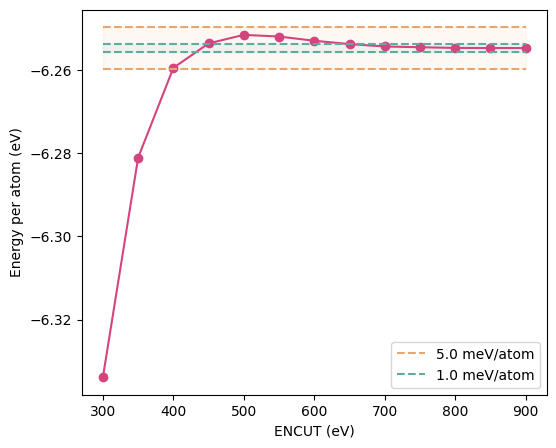

In [52]:
fig = parse_encut(encut_results)

Idem for the kpoints:

In [33]:
kpoint_results = """Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k4,4,4          -12.58620794    -6.2931039
k5,5,5          -12.66431702    -6.3321585        39.0546                   0.0000
k6,6,6          -12.66659966    -6.3332998        1.1413                    0.0000
k7,7,7          -12.66180056    -6.3309002        -2.3996                   0.0000
k8,8,8          -12.64832289    -6.3241614        -6.7388                   0.0000
k9,9,9          -12.65998187    -6.3299909        5.8295                    0.0000
k_10,10,10      -12.66773427    -6.3338671        3.8762                    0.0000
k_11,11,11      -12.66360626    -6.3318031        -2.0640                   0.0000
k_12,12,12      -12.65463699    -6.3273184        -4.4847                   0.0000
k_13,13,13      -12.65957706    -6.3297885        2.4701                    0.0000
k_14,14,14      -12.66096859    -6.3304842        0.6957                    0.0000
k_15,15,15      -12.65856041    -6.3292802        -1.2040                   0.0000
k_16,16,16      -12.65562228    -6.3278111        -1.4691                   0.0000"""

In [48]:
def parse_kpoints(kpoints):
    """Function to parse kpoints convergence results from the string produced by vaspup2.0
    and plot them."""
    # Get values from 3rd column into list
    kpoints_energies_per_atom = [float(line.split()[2]) for line in kpoints.split("\n")[1:]]
    # Get encut values from 1st column into list
    data = [line.split() for line in kpoints.split("\n")[1:]]
    kpoints_values = [line[0].split("k")[1].split("_")[-1].split()[0] for line in data]
    # print(kpoints_values)
    #return kpoints_values, kpoints_energies_per_atom
    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(kpoints_values, kpoints_energies_per_atom, marker="o", color="#D4447E")
    # Draw lines +- 5 meV/atom from the last point (our most accurate value)
    for threshold, color in zip([0.005, 0.001], ("#E9A66C", "#5FABA2")):
        ax.hlines(
            y=kpoints_energies_per_atom[-1] + threshold,
            xmin=kpoints_values[0],
            xmax=kpoints_values[-1],
            color=color,
            linestyles="dashed",
            label=f"{1000*threshold} meV/atom"
        )
        ax.hlines(
            y=kpoints_energies_per_atom[-1] - threshold,
            xmin=kpoints_values[0],
            xmax=kpoints_values[-1],
            color=color,
            linestyles="dashed",
        )
        # Fill the area between the lines
        ax.fill_between(
            kpoints_values,
            kpoints_energies_per_atom[-1] - threshold,
            kpoints_energies_per_atom[-1] + threshold,
            color=color,
            alpha=0.08,
        )
    # Add axis labels
    ax.set_xlabel("KPOINTS")
    ax.set_ylabel("Energy per atom (eV)")
    # Rotate xticks
    ax.set_xticklabels(kpoints_values, rotation=90)
    ax.legend(frameon=True)
    return fig

/tmp/ipykernel_30114/2958063517.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(kpoints_values, rotation=90)


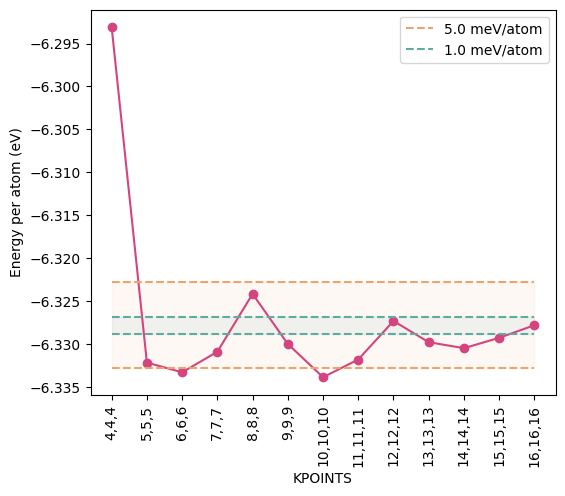

In [50]:
fig = parse_kpoints(kpoint_results)

Converged values to `5 meV/atom`:  # Note that in a proper defect study, you'd converge to 1 meV/atom!
* kpoints: `7x7x7`
* cutoff: `450` eV

### 2.2 Bulk Relaxation

#### Generate input files

We generate the `VASP` input files to relax the primitive structure:


For the `POTCAR`, we use the default [`VASP` `PBE` pseudopotentials](https://www.vasp.at/wiki/index.php/Available_PAW_potentials), which we read from doped:

In [54]:
from monty.serialization import loadfn
from pymatgen.core.structure import Structure

potcar_yaml = "../doped/VASP_sets/PotcarSet.yaml"
potcar_dict = loadfn(potcar_yaml)

if not prim_struc:
    prim_struc = Structure.from_file("MgO/Input_files/prim_struc_POSCAR")
print(f"Default PBE pseudopotentials:")
potcar_names = []
for el in prim_struc.elements:
    print(f"Element {el}: {potcar_dict['POTCAR'][str(el)]}")
    potcar_names.append(potcar_dict["POTCAR"][str(el)])

Default PBE pseudopotentials:
Element Mg: Mg
Element O: O


In [55]:
# Generate input files for VASP
from pymatgen.io.vasp.inputs import Incar, Poscar, Potcar, Kpoints, VaspInput

poscar = Poscar(prim_struc)
kpoints = Kpoints(kpts=((7,7,7),)) # Using converged kgrid from previous section
potcar = Potcar(
    potcar_names # Recommended VASP pseudopotentials for Mg, O
)

Finally, we load the `INCAR` file and update the `ENCUT` value. Note that because we're relaxing the volume of the structure, we need to increase our converged `ENCUT` by 30% (see discussion of [Pulay stress](https://www.vasp.at/wiki/index.php/Energy_vs_volume_Volume_relaxations_and_Pulay_stress#Pulay_Stress)).

In [73]:
incar = Incar.from_file("./MgO/Input_files/INCAR_bulk_relax")
incar.update(
    {
        "ENCUT": 450 * 1.3, # Increase ENCUT by 30% because we're relaxing volume (Pulay stress)
        # Paralelisation
        "KPAR": 2,
        "NCORE": 8, # Might need updating for your HPC!
        # Functional
        "GGA": "PS",
        # Relaxation
        "IBRION": 2,
        "ISIF": 3, # Relax cell
        "NSW": 800, # Max number of steps
        # Accuracy and thresholds
        "ISYM": 2, # Symmetry on
        "PREC": "Accurate",
        "EDIFF": 1e-6, # Electronic convergence
        "EDIFFG": 1e-5, # Ionic convergence
        "ALGO": "Normal",
    }
)
incar

{'GGA': 'PS',
 'ALGO': 'Normal',
 'EDIFF': 1e-06,
 'EDIFFG': 1e-05,
 'ENCUT': 585.0,
 'IBRION': 2,
 'ISIF': 3,
 'ISMEAR': 0,
 'ISPIN': 1,
 'ISYM': 2,
 'KPAR': 2,
 'LCHARG': True,
 'LHFCALC': False,
 'LWAVE': False,
 'NCORE': 8,
 'NELM': 60,
 'NELMIN': 5,
 'NSW': 800,
 'PREC': 'Accurate',
 'SIGMA': 0.1}

In the `INCAR`, remember to adapt the `KPAR` and `NCORE` to values that are appropriate for your computer cluster!

In [74]:
vasp_input = VaspInput(incar, kpoints, poscar, potcar)
# Write to folder
vasp_input.write_input("MgO/Bulk_relax")

We know submit the bulk relaxation in a computer cluster. After the first relaxation is converged, we resubmit with the converged `ENCUT` value (without increasing it by 30%), as we need to use the same `ENCUT` value for the bulk and defect calculations:
```
cp CONTCAR POSCAR
sed -i 's/ENCUT = 585/ENCUT = 450/g' INCAR
qsub -N bulk_relax job # Update for your HPC!
```

After the relaxation is complete, we parse the resulting `vasprun.xml` and `CONTCAR` to the current directory.

In [58]:
# We can check the volume change upon relaxation like this:
from pymatgen.core.structure import Structure

s_poscar = Structure.from_file("MgO/Bulk_relax/POSCAR")
s_contcar = Structure.from_file("MgO/Bulk_relax/CONTCAR")
s_poscar.volume, s_contcar.volume

(19.2793782653415, 18.521290988527692)

In [59]:
from pymatgen.io.vasp.outputs import Vasprun

# Can check if relaxation is converged by parsing the vasprun.xml
if os.path.exists("MgO/Bulk_relax/vasprun.xml"):
    vr = Vasprun("MgO/Bulk_relax/vasprun.xml")
elif os.path.exists("MgO/Bulk_relax/vasprun.xml.gz"):
    vr = Vasprun("MgO/Bulk_relax/vasprun.xml.gz")
else:
    raise FileNotFoundError("No vasprun.xml found in the Bulk_relax directory")
print(f"Relaxation converged?", vr.converged)

Relaxation converged? True


<a id='generate_defects'></a>
## 3. Generate defects

Load the bulk relaxed structure:

In [1]:
import os
from pymatgen.core.structure import Structure

if not os.path.exists("./MgO/Bulk_relax/CONTCAR"):
    print("Please run the bulk relaxation first!")
else:
    prim_struc = Structure.from_file("./MgO/Bulk_relax/CONTCAR")

We can generate all the intrinsic defects for that bulk structure by running the `DefectsGenerator` class:

In [2]:
from doped.generation import DefectsGenerator
# generate all intrinsic defects, enforcing the use of a cubic supercell in this example case:
defect_gen = DefectsGenerator(structure=prim_struc, supercell_gen_kwargs={"force_cubic":True})

Generating DefectEntry objects: 100.0%|██████████| [00:08,  11.75it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  4a
v_O          [+2,+1,0,-1]       [0.500,0.500,0.500]  4b

Substitutions    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Mg_O             [+4,+3,+2,+1,0]    [0.500,0.500,0.500]  4b
O_Mg             [0,-1,-2,-3,-4]    [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges    Conv. Cell Coords    Wyckoff
---------------  -----------------  -------------------  ---------
Mg_i_Td          [+2,+1,0]          [0.250,0.250,0.250]  8c
O_i_Td           [0,-1,-2]          [0.250,0.250,0.250]  8c

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 4 formula unit(s) of MgO.
Note that Wyckoff letters can depend on the ordering of elements in the conventional standa

Note that you can check the documentation of this class by running `DefectsGenerator?`:

In [2]:
from doped.generation import DefectsGenerator
DefectsGenerator?

Init signature:
DefectsGenerator(
    structure: pymatgen.core.structure.Structure,
    extrinsic: Union[str, List, Dict, NoneType] = None,
    interstitial_coords: Optional[List] = None,
    generate_supercell: bool = True,
    charge_state_gen_kwargs: Optional[Dict] = None,
    supercell_gen_kwargs: Optional[Dict] = None,
    interstitial_gen_kwargs: Optional[Dict] = None,
    target_frac_coords: Optional[List] = None,
    processes: Optional[int] = None,
)
Docstring:      Class for generating doped DefectEntry objects.
Init docstring:
Generates doped DefectEntry objects for defects in the input host
structure. By default, generates all intrinsic defects, but extrinsic
defects (impurities) can also be created using the ``extrinsic``
argument.

Interstitial sites are generated using Voronoi tessellation by default (found
to be the most reliable), which can be controlled using the
``interstitial_gen_kwargs`` argument (passed as keyword arguments to the
``VoronoiInterstitialGenerator`` 

Can check the dimensions of the generated supercell by calling the `bulk_supercell` method:

In [15]:
defect_gen.bulk_supercell.lattice

Lattice
    abc : 12.599838 12.599838 12.599838
 angles : 90.0 90.0 90.0
 volume : 2000.298843632019
      A : 12.599838 0.0 0.0
      B : 0.0 12.599838 0.0
      C : 0.0 0.0 12.599838
    pbc : True True True

which corresponds to the following expansion of the primitive cell:

In [16]:
defect_gen.supercell_matrix

array([[-3,  3,  3],
       [ 3, -3,  3],
       [ 3,  3, -3]])

We can see the generated `Defect` objects by calling the `defects` method:

In [21]:
defect_gen.defects

{'vacancies': [v_Mg vacancy defect at site [0.000,0.000,0.000] in structure,
  v_O vacancy defect at site [0.500,0.500,0.500] in structure],
 'substitutions': [Mg_O substitution defect at site [0.500,0.500,0.500] in structure,
  O_Mg substitution defect at site [0.000,0.000,0.000] in structure],
 'interstitials': [Mg_i interstitial defect at site [0.250,0.250,0.250] in structure,
  O_i interstitial defect at site [0.250,0.250,0.250] in structure]}

And the associated `DefectEntry` keys by calling the `defect_entries` method:

In [22]:
# Names of generated defects with their charges
defect_gen.defect_entries.keys()

dict_keys(['v_Mg_-2', 'v_Mg_-1', 'v_Mg_0', 'v_Mg_+1', 'v_O_-1', 'v_O_0', 'v_O_+1', 'v_O_+2', 'Mg_O_0', 'Mg_O_+1', 'Mg_O_+2', 'Mg_O_+3', 'Mg_O_+4', 'O_Mg_-4', 'O_Mg_-3', 'O_Mg_-2', 'O_Mg_-1', 'O_Mg_0', 'Mg_i_Td_0', 'Mg_i_Td_+1', 'Mg_i_Td_+2', 'O_i_Td_-2', 'O_i_Td_-1', 'O_i_Td_0'])

In this tutorial, we'll only consider the Mg substitution (Mg_O in the table above):

In [4]:
defect_gen.defects = {
    "substitutions": [
    defect for defect in defect_gen.defects["substitutions"] if defect.name == "Mg_O"], # select Mg_O
}
defect_gen.defect_entries = {
    k: v for k, v in defect_gen.defect_entries.items() if "Mg_O" in k
}

If we wanted to manually add some extra charge states (e.g. some positive charge states for `Mg_O`), we
 can do so using the `add_charge_states` method:

 ```
 defect_gen.add_charge_states("Mg_O", [-1, ])
 ```

In [24]:
# Check that now we only have the O interstitial
defect_gen.defect_entries.keys()

dict_keys(['Mg_O_0', 'Mg_O_+1', 'Mg_O_+2', 'Mg_O_+3', 'Mg_O_+4'])

And we can save it to a `json` file for later use:

In [25]:
defect_gen.to_json("MgO/defect_gen.json")

Which we can later reload using the `from_json` method:

In [20]:
from doped.generation import DefectsGenerator
# Load from JSON
defect_gen = DefectsGenerator.from_json("MgO/defect_gen.json")

## 4. Determining the ground-state defect structures

**At this point, it's recommended that you use the [ShakeNBreak](https://shakenbreak.readthedocs.io/en/latest/) approach** to quickly identify the groundstate structures of your defects, before continuing on with the formation energy calculation workflow below. As detailed in the [theory paper](https://www.nature.com/articles/s41524-023-00973-1), skipping this step can result in drastically incorrect formation energies, transition levels, carrier capture (basically any property associated with defects). This approach is followed below, with a more in-depth explanation and tutorial given on the [ShakeNBreak](https://shakenbreak.readthedocs.io/en/latest/) website.

### 4.1 Generate distorted structures

To generate our distorted defect structures with `ShakeNBreak` (`SnB`), we can directly input our `DefectsGenerator` object to the `SnB` `Distortions` class:

In [5]:
from shakenbreak.input import Distortions

In [6]:
Dist = Distortions(defect_entries = defect_gen)

Oxidation states were not explicitly set, thus have been guessed as {'Mg': 2.0, 'O': -2.0}. If this is unreasonable you should manually set oxidation_states


```{important}
As with the `doped` functions, `ShakeNBreak` has been built and optimised to adopt reasonable defaults that work well for most host materials, however there is again a lot of customisation and control available, and you should carefully consider the appropriate settings and choices for your system. The `ShakeNBreak` workflow is shown in more detail in the\n", [SnB Python API tutorial](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html) on the [SnB docs](https://shakenbreak.readthedocs.io), and here we just show a brief example of the main steps.
```

Generating VASP input files for the trial distorted structures

In [12]:
defects_dict, distortion_metadata = Dist.write_vasp_files(
    output_path="MgO/SnB",
    # Update INCAR settings to not use GGA and NCORE according to your HPC cluster:
    user_incar_settings={
        # Functional:
        "GGA": "PS",
        "LHFCALC": False,
        "AEXX": 0.0,
        "HFSCREEN": 0.0,
        # Parallelisation:
        "NCORE": 8 # Might need updating for your HPC!
    }
)

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.21 Å 


Defect: Mg_O
Number of extra electrons in neutral state: 4

Defect Mg_O in charge state: 0. Number of distorted neighbours: 4

Defect Mg_O in charge state: +1. Number of distorted neighbours: 3

Defect Mg_O in charge state: +2. Number of distorted neighbours: 2

Defect Mg_O in charge state: +3. Number of distorted neighbours: 1

Defect Mg_O in charge state: +4. Number of distorted neighbours: 0


Our distorted structures and `VASP` input files have now been generated in the folders with names matching the doped naming scheme:

In [33]:
!cat ./MgO/SnB/Mg_O_0/Bond_Distortion_-10.0%/INCAR

# May want to change NCORE, KPAR, AEXX, ENCUT, IBRION, LREAL, NUPDOWN, ISPIN = Typical variable parameters
# ShakeNBreak INCAR with coarse settings to maximise speed with sufficient accuracy for qualitative structure searching = 
AEXX = 0.0
ALGO = Normal  # change to all if zhegv, fexcp/f or zbrent errors encountered (done automatically by snb-run)
EDIFF = 3e-05
EDIFFG = -0.01
ENCUT = 300
GGA = Ps
HFSCREEN = 0.0
IBRION = 2
ICHARG = 1
ICORELEVEL = 0  # needed if using the kumagai-oba (efnv) anisotropic charge correction scheme
ISIF = 2
ISMEAR = 0
ISPIN = 2
ISYM = 0  # symmetry breaking extremely likely for defects
LASPH = True
LCHARG = False
LHFCALC = False
LORBIT = 11
LREAL = Auto
LVHAR = True
LWAVE = False
NCORE = 8
NEDOS = 2000
NELECT = 646.0
NELM = 40
NSW = 300
NUPDOWN = 0
PREC = Accurate
ROPT = 1e-3 1e-3
SIGMA = 0.05


### 4.2 Send to HPCs and run relaxations
Can use the `snb-run` CLI function to quickly run calculations; see the [Submitting the geometry optimisations](https://shakenbreak.readthedocs.io/en/latest/Generation.html#submitting-the-geometry-optimisations) section of the `SnB` CLI tutorial for this.

After the relaxations finish, you can use can parse the energies obtained by running the `snb-parse -a` command from the top-level folder containing your defect folders (e.g. `Mg_O_0` etc. (with subfolders: `Mg_O_0/Bond_Distortion_10.0%` etc.)). This will parse the energies and store them in a `Mg_O_0.yaml` etc file in the defect folders, to allow easy plotting and analysis.

When can copy these files and the relaxed structures (`CONTCAR`s) to our local PC with the following code:
```
shopt -s extglob # ensure extended globbing (pattern matching) is enabled
for defect in ./*{_,_-}[0-9]/; do cd $defect;
scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${defect%?}.yaml .;
for distortion in (Bond_Distortion|Unperturbed|Rattled)*/;
do scp {remote_machine}:{path to ShakeNBreak folders}/${defect}${distortion}CONTCAR ${distortion};
done; cd ..; done
```

### 4.3 Analyse results

Plot final energies versus the applied distortion

To see if `SnB` found any energy-lowering distortions, we can plot the results using the functions in `shakenbreak.plotting`.


In [1]:
from importlib_metadata import version
version('shakenbreak')

'3.3.1'

In [2]:
from shakenbreak import energy_lowering_distortions, plotting

In [3]:
defect_charges_dict = energy_lowering_distortions.read_defects_directories(output_path="MgO/SnB")
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict, output_path="MgO/SnB")


Mg_O
Mg_O_+3: Energy difference between minimum, found with 0.6 bond distortion, and unperturbed: -1.41 eV.
Energy lowering distortion found for Mg_O with charge +3. Adding to low_energy_defects dictionary.
Mg_O_+4: Energy difference between minimum, found with Rattled bond distortion, and unperturbed: -1.41 eV.
New (according to structure matching) low-energy distorted structure found for Mg_O_+4, adding to low_energy_defects['Mg_O'] list.
Mg_O_+2: Energy difference between minimum, found with 0.6 bond distortion, and unperturbed: -1.23 eV.
Low-energy distorted structure for Mg_O_+2 already found with charge states ['+3'], storing together.
Mg_O_0: Energy difference between minimum, found with 0.4 bond distortion, and unperturbed: -1.02 eV.
Low-energy distorted structure for Mg_O_0 already found with charge states ['+3', '+2'], storing together.
Mg_O_+1: Energy difference between minimum, found with 0.4 bond distortion, and unperturbed: -0.99 eV.
Low-energy distorted structure for Mg

Because the above cell takes a while to run, we can save the results in case we want to use them later on:

In [63]:
import pickle

# Save the low energy defects to a pickle file
with open("MgO/SnB/low_energy_defects.pkl", "wb") as f:
    pickle.dump(low_energy_defects, f)

The `low_energy_defects` is a dictionary of defects for which bond distortion found an energy-lowering reconstruction (which is missed with normal unperturbed relaxation), of the form {defect: [list of
distortion dictionaries (with corresponding charge states,
energy lowering, distortion factors, structures and charge
states for which these structures weren't found)]}:

In [66]:
low_energy_defects.keys() # Show defect keys in dict

dict_keys(['Mg_O'])

In [69]:
low_energy_defects["Mg_O"][0].keys(), low_energy_defects["Mg_O"][0]

(dict_keys(['charges', 'structures', 'energy_diffs', 'bond_distortions', 'excluded_charges']),
 [1, 2, 3, 0, 4])

Energy lowering distortion found for Mg_O with charge +1. Generating distortion plot...
Trying to install ShakeNBreak custom font...
Copying /home/ireaml/miniconda3/envs/doped/lib/python3.11/site-packages/shakenbreak/../fonts/Montserrat-Regular.ttf -> /home/ireaml/miniconda3/envs/doped/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/Montserrat-Regular.ttf
Couldn't find matplotlib cache, so will continue.
Adding Montserrat-Regular.ttf font to matplotlib fonts.
Plot saved to Mg_O_+1/Mg_O_+1.png
Energy lowering distortion found for Mg_O with charge +2. Generating distortion plot...
Plot saved to Mg_O_+2/Mg_O_+2.png
Energy lowering distortion found for Mg_O with charge +3. Generating distortion plot...
Plot saved to Mg_O_+3/Mg_O_+3.png
Energy lowering distortion found for Mg_O with charge +4. Generating distortion plot...
Plot saved to Mg_O_+4/Mg_O_+4.png
Energy lowering distortion found for Mg_O with charge 0. Generating distortion plot...
Plot saved to Mg_O_0/Mg_O_0.png


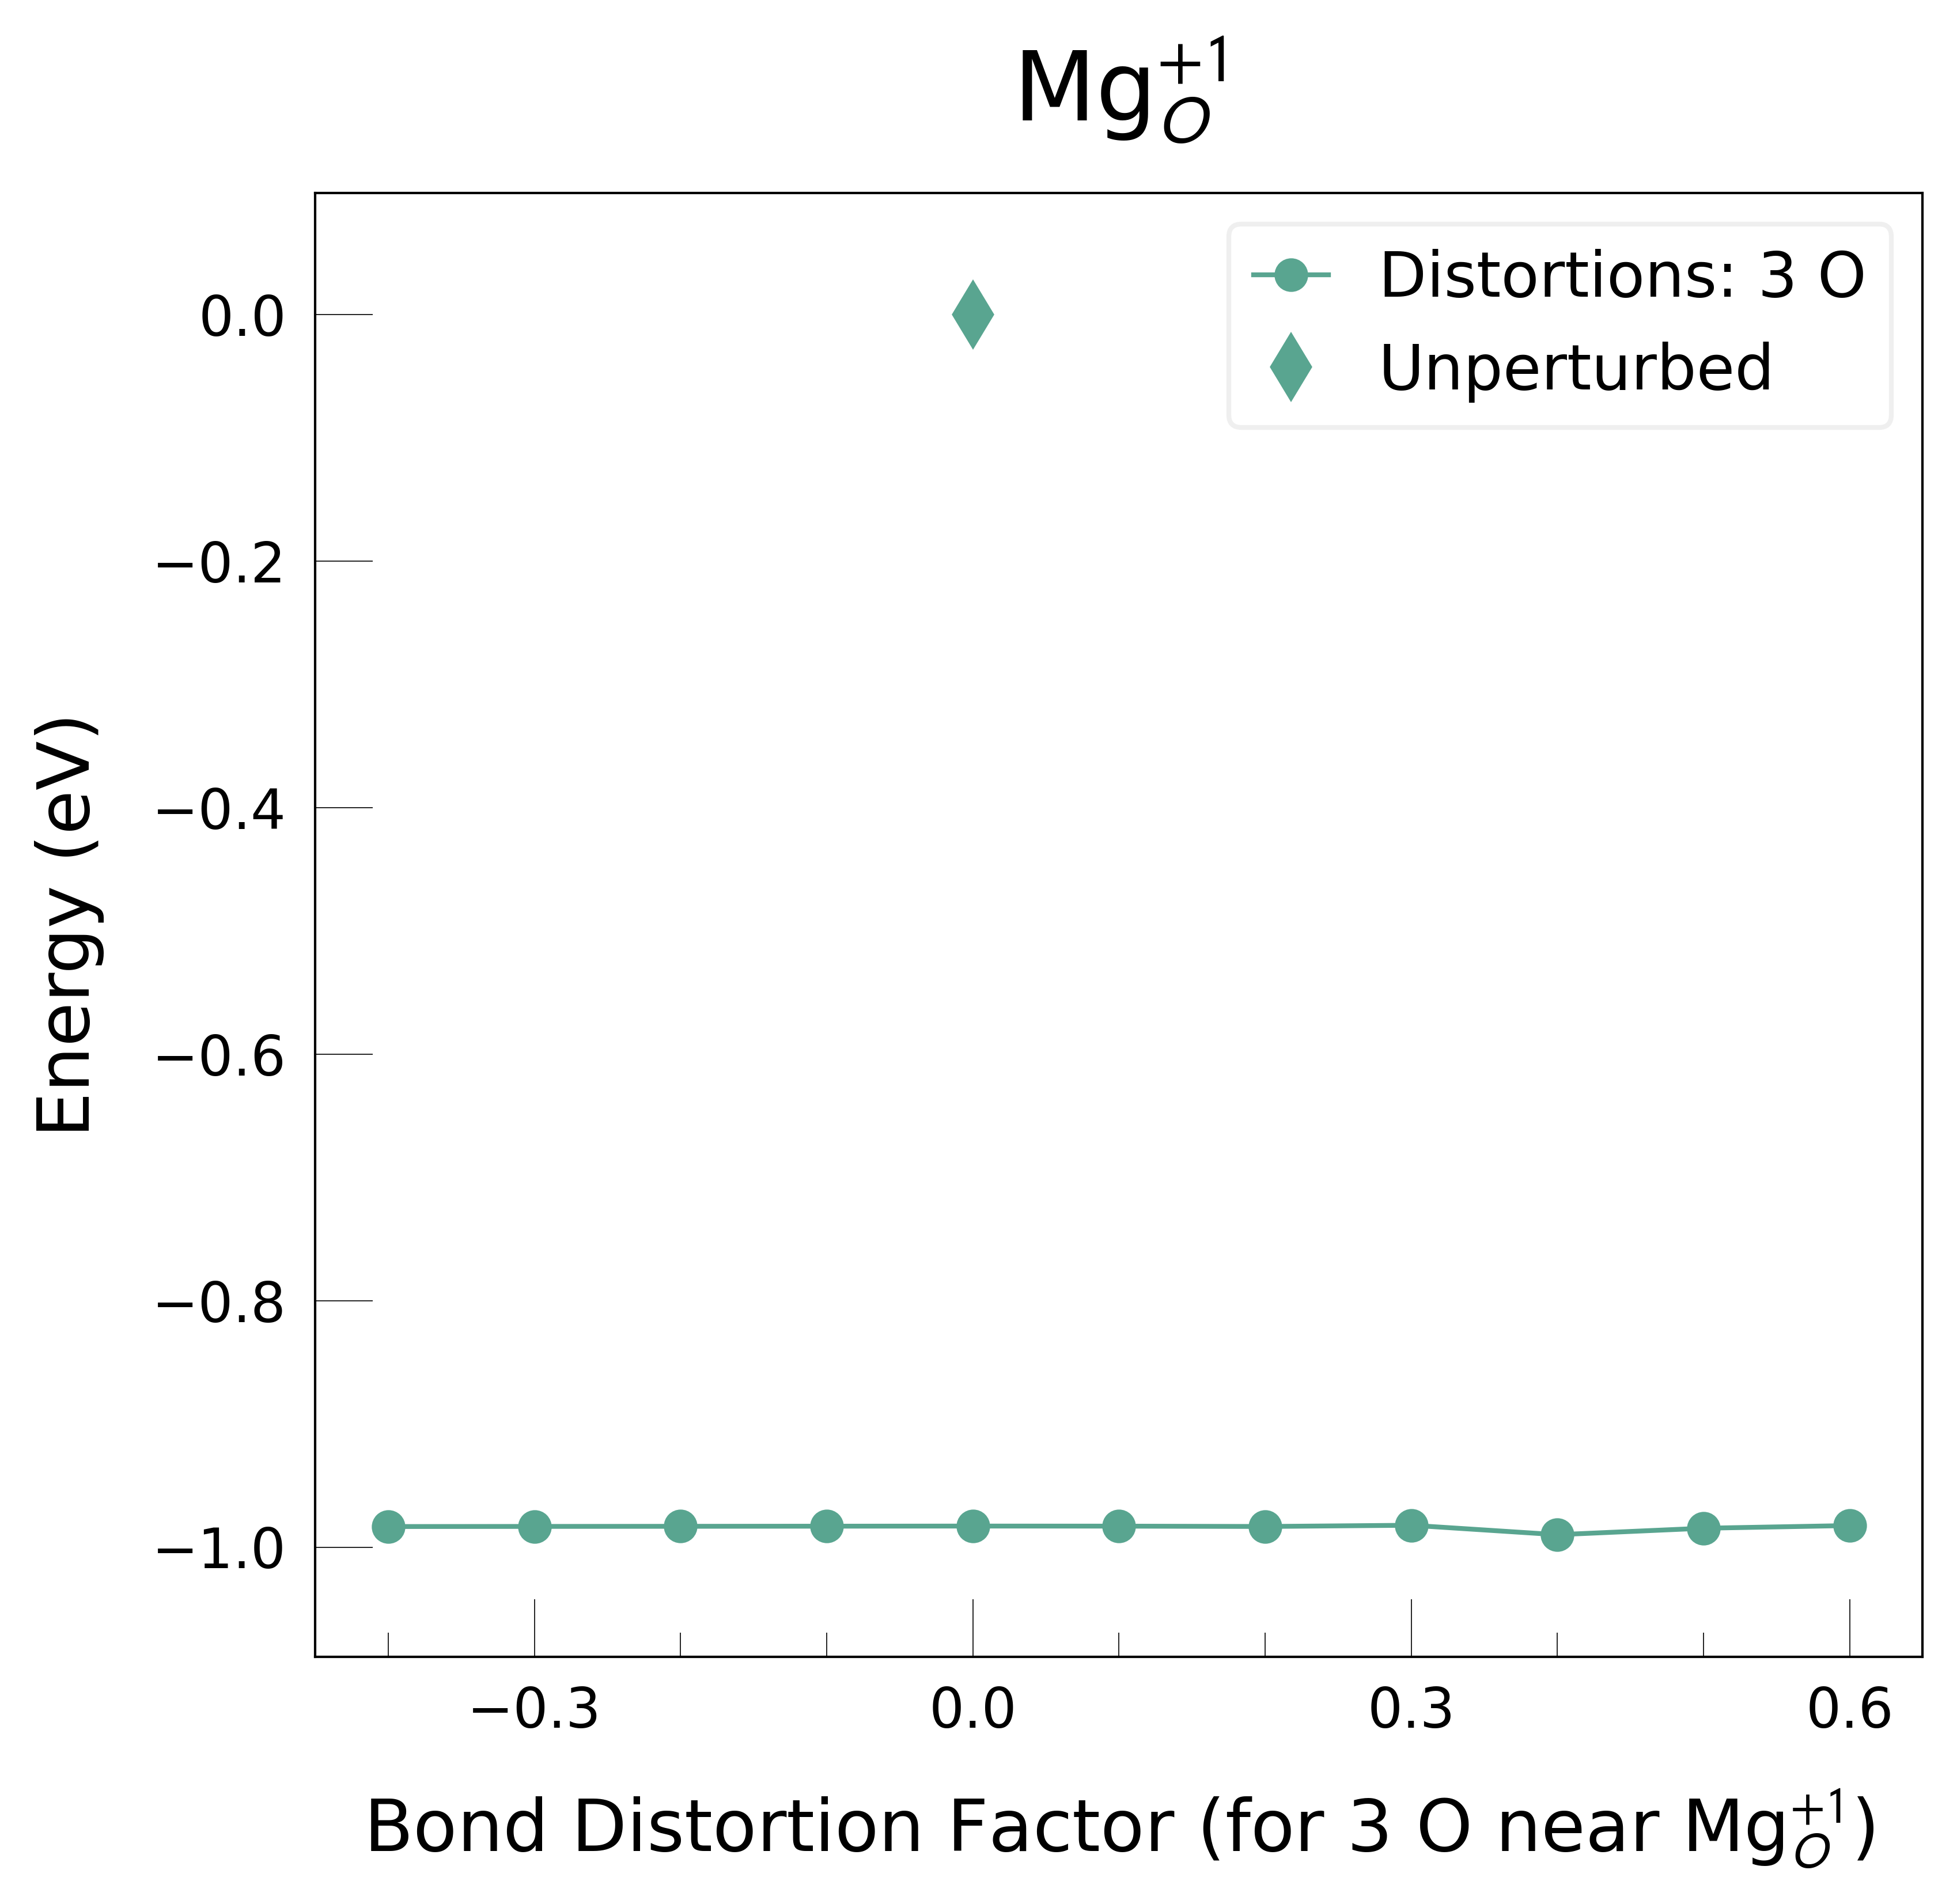

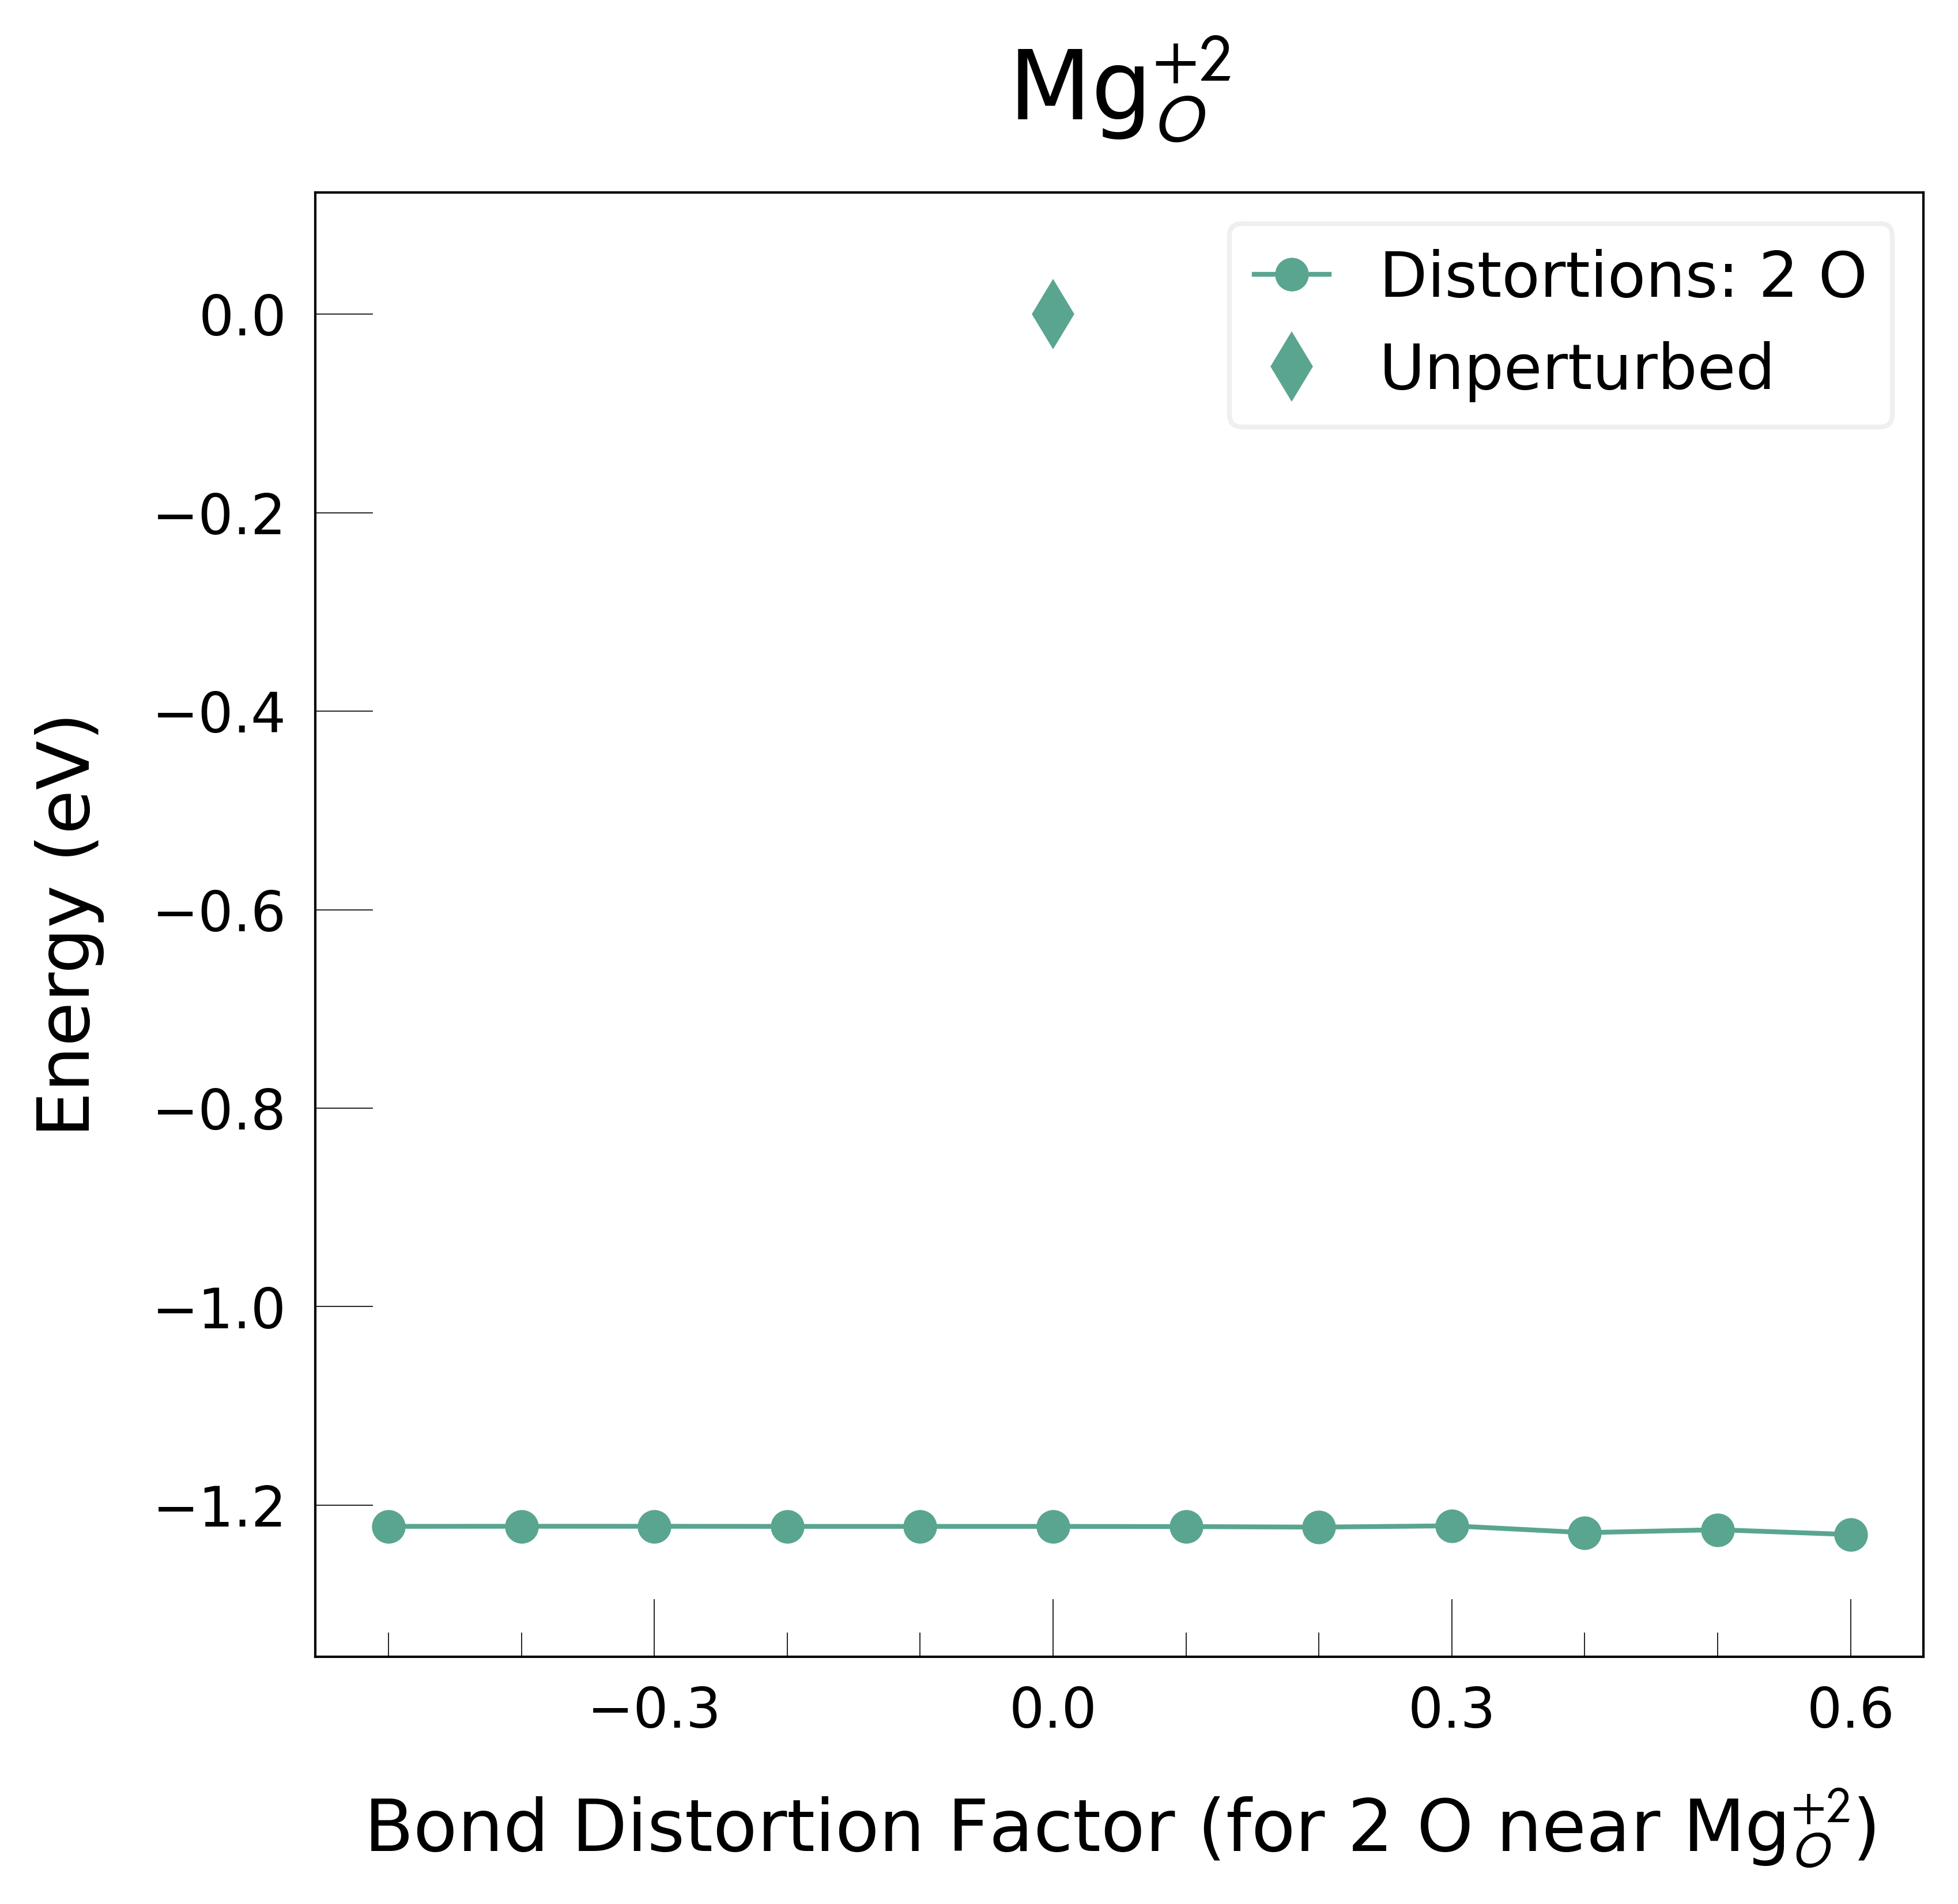

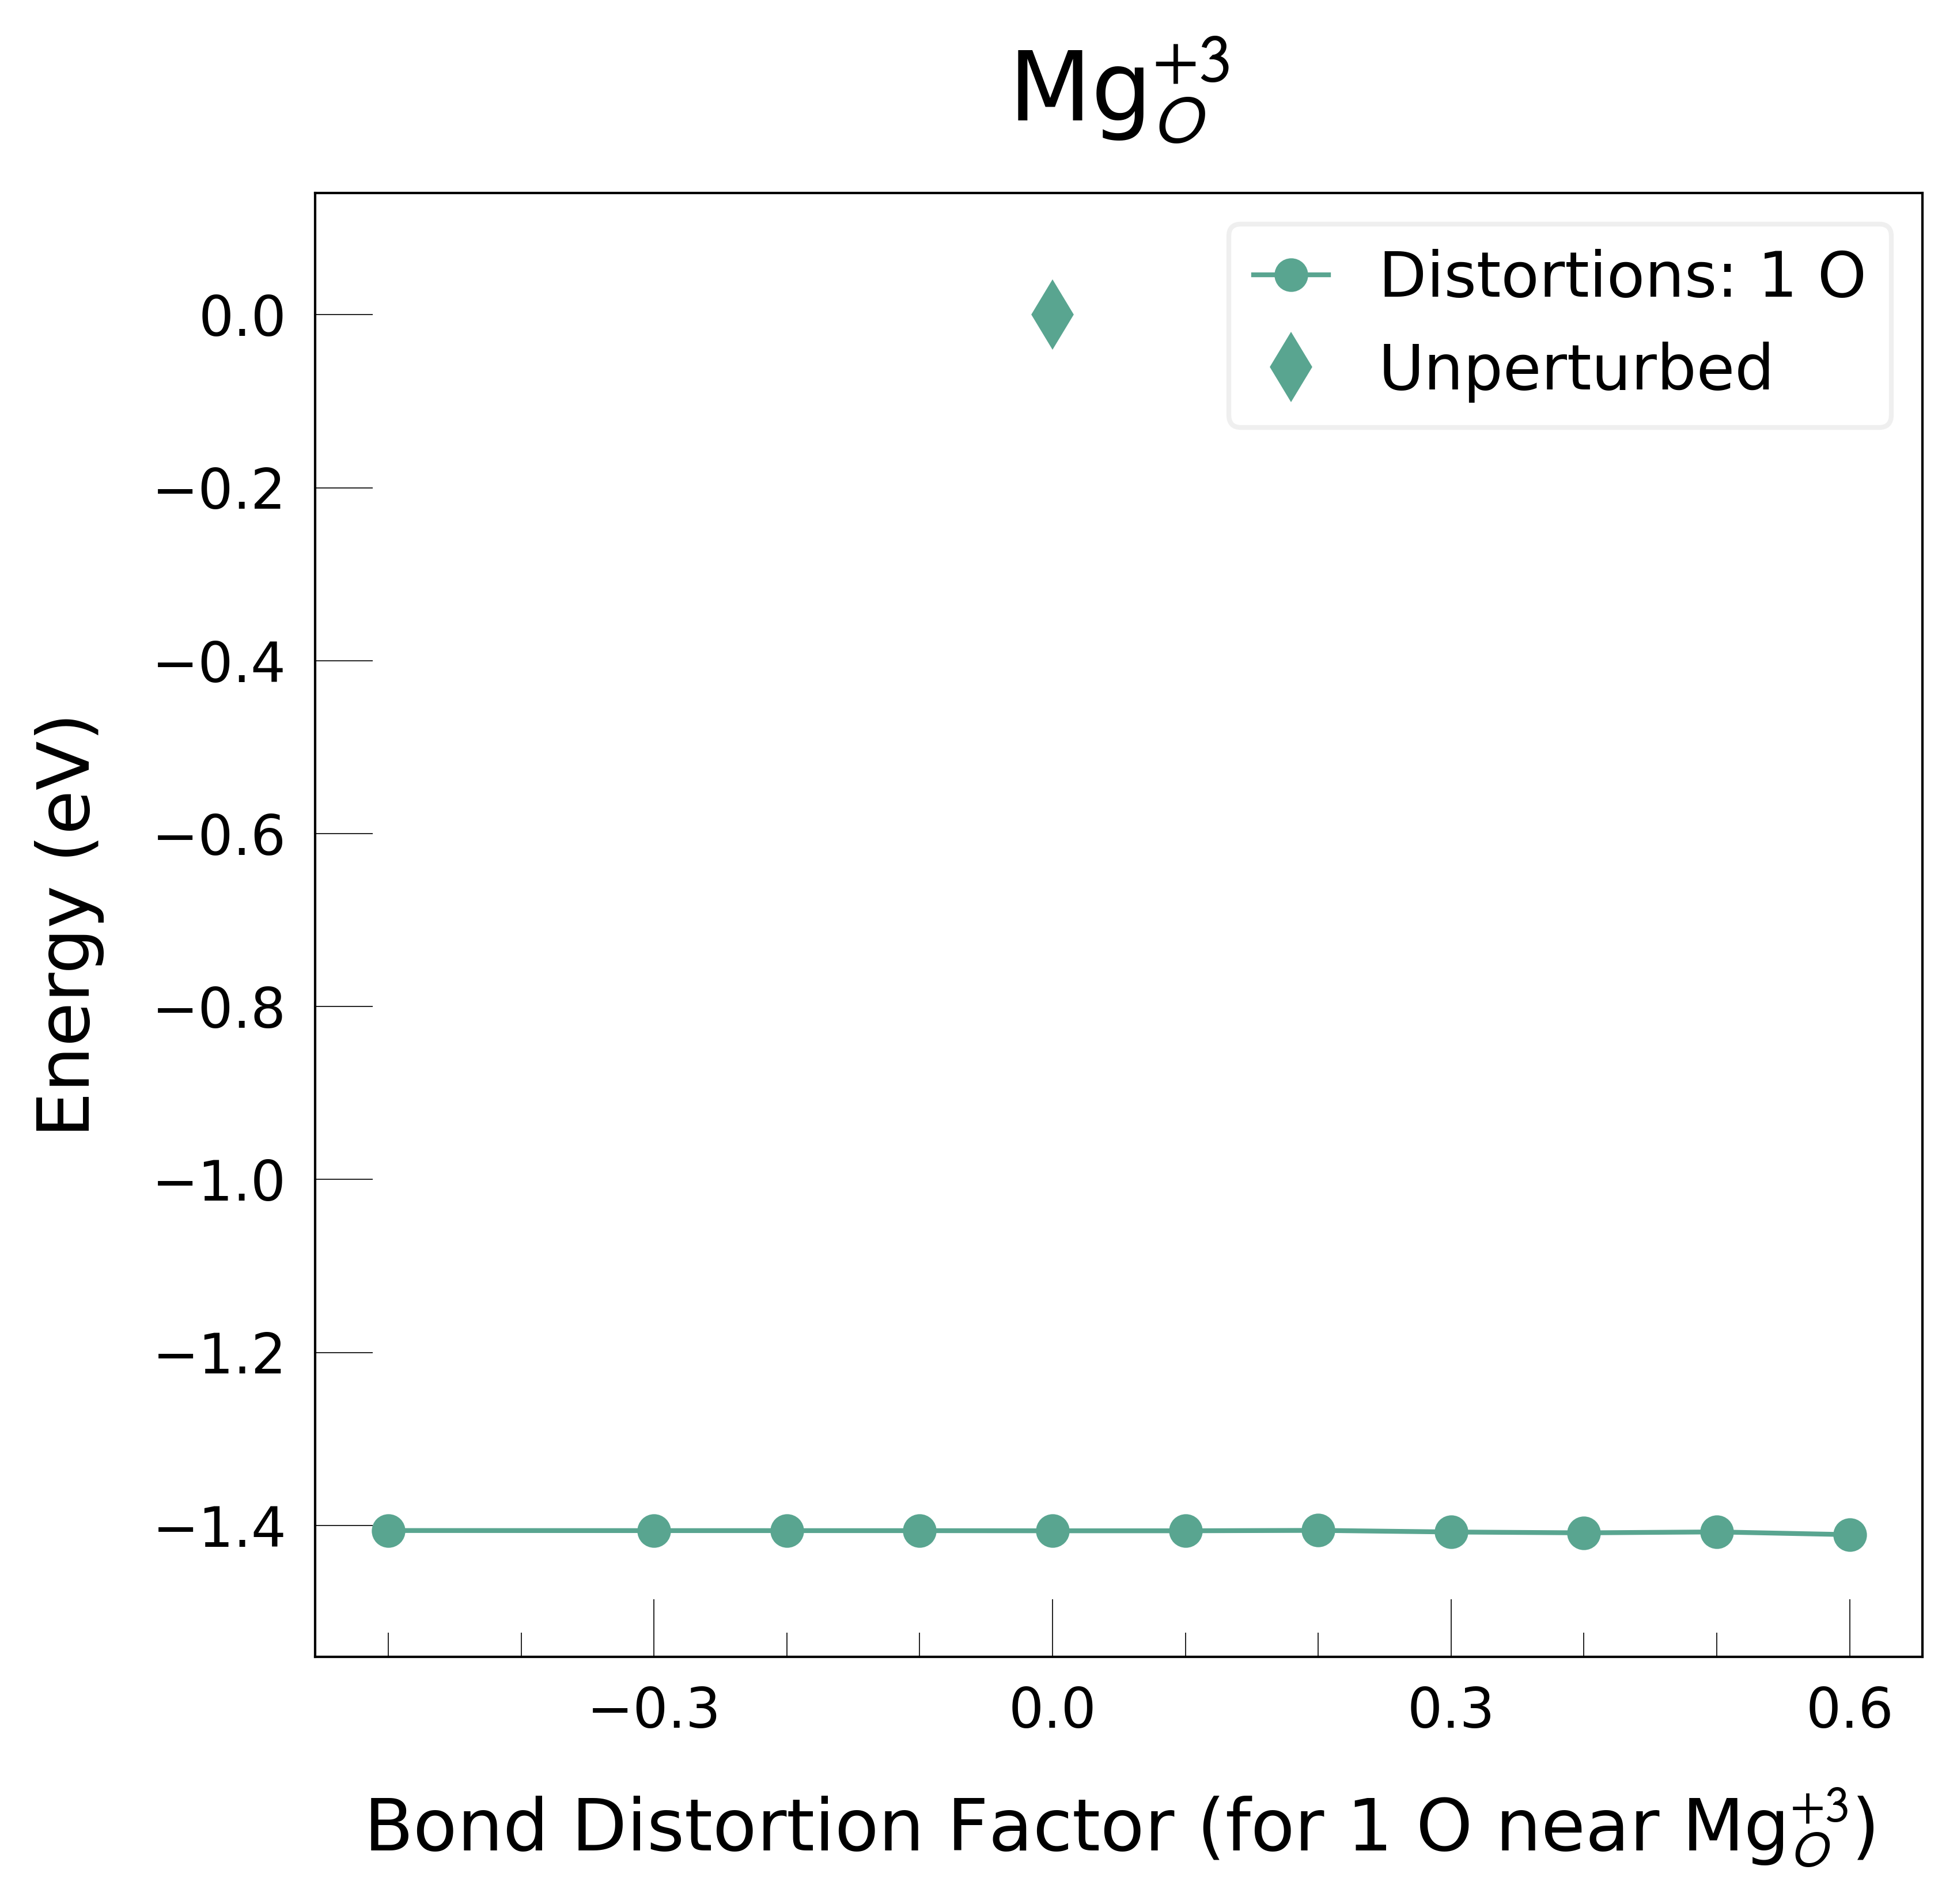

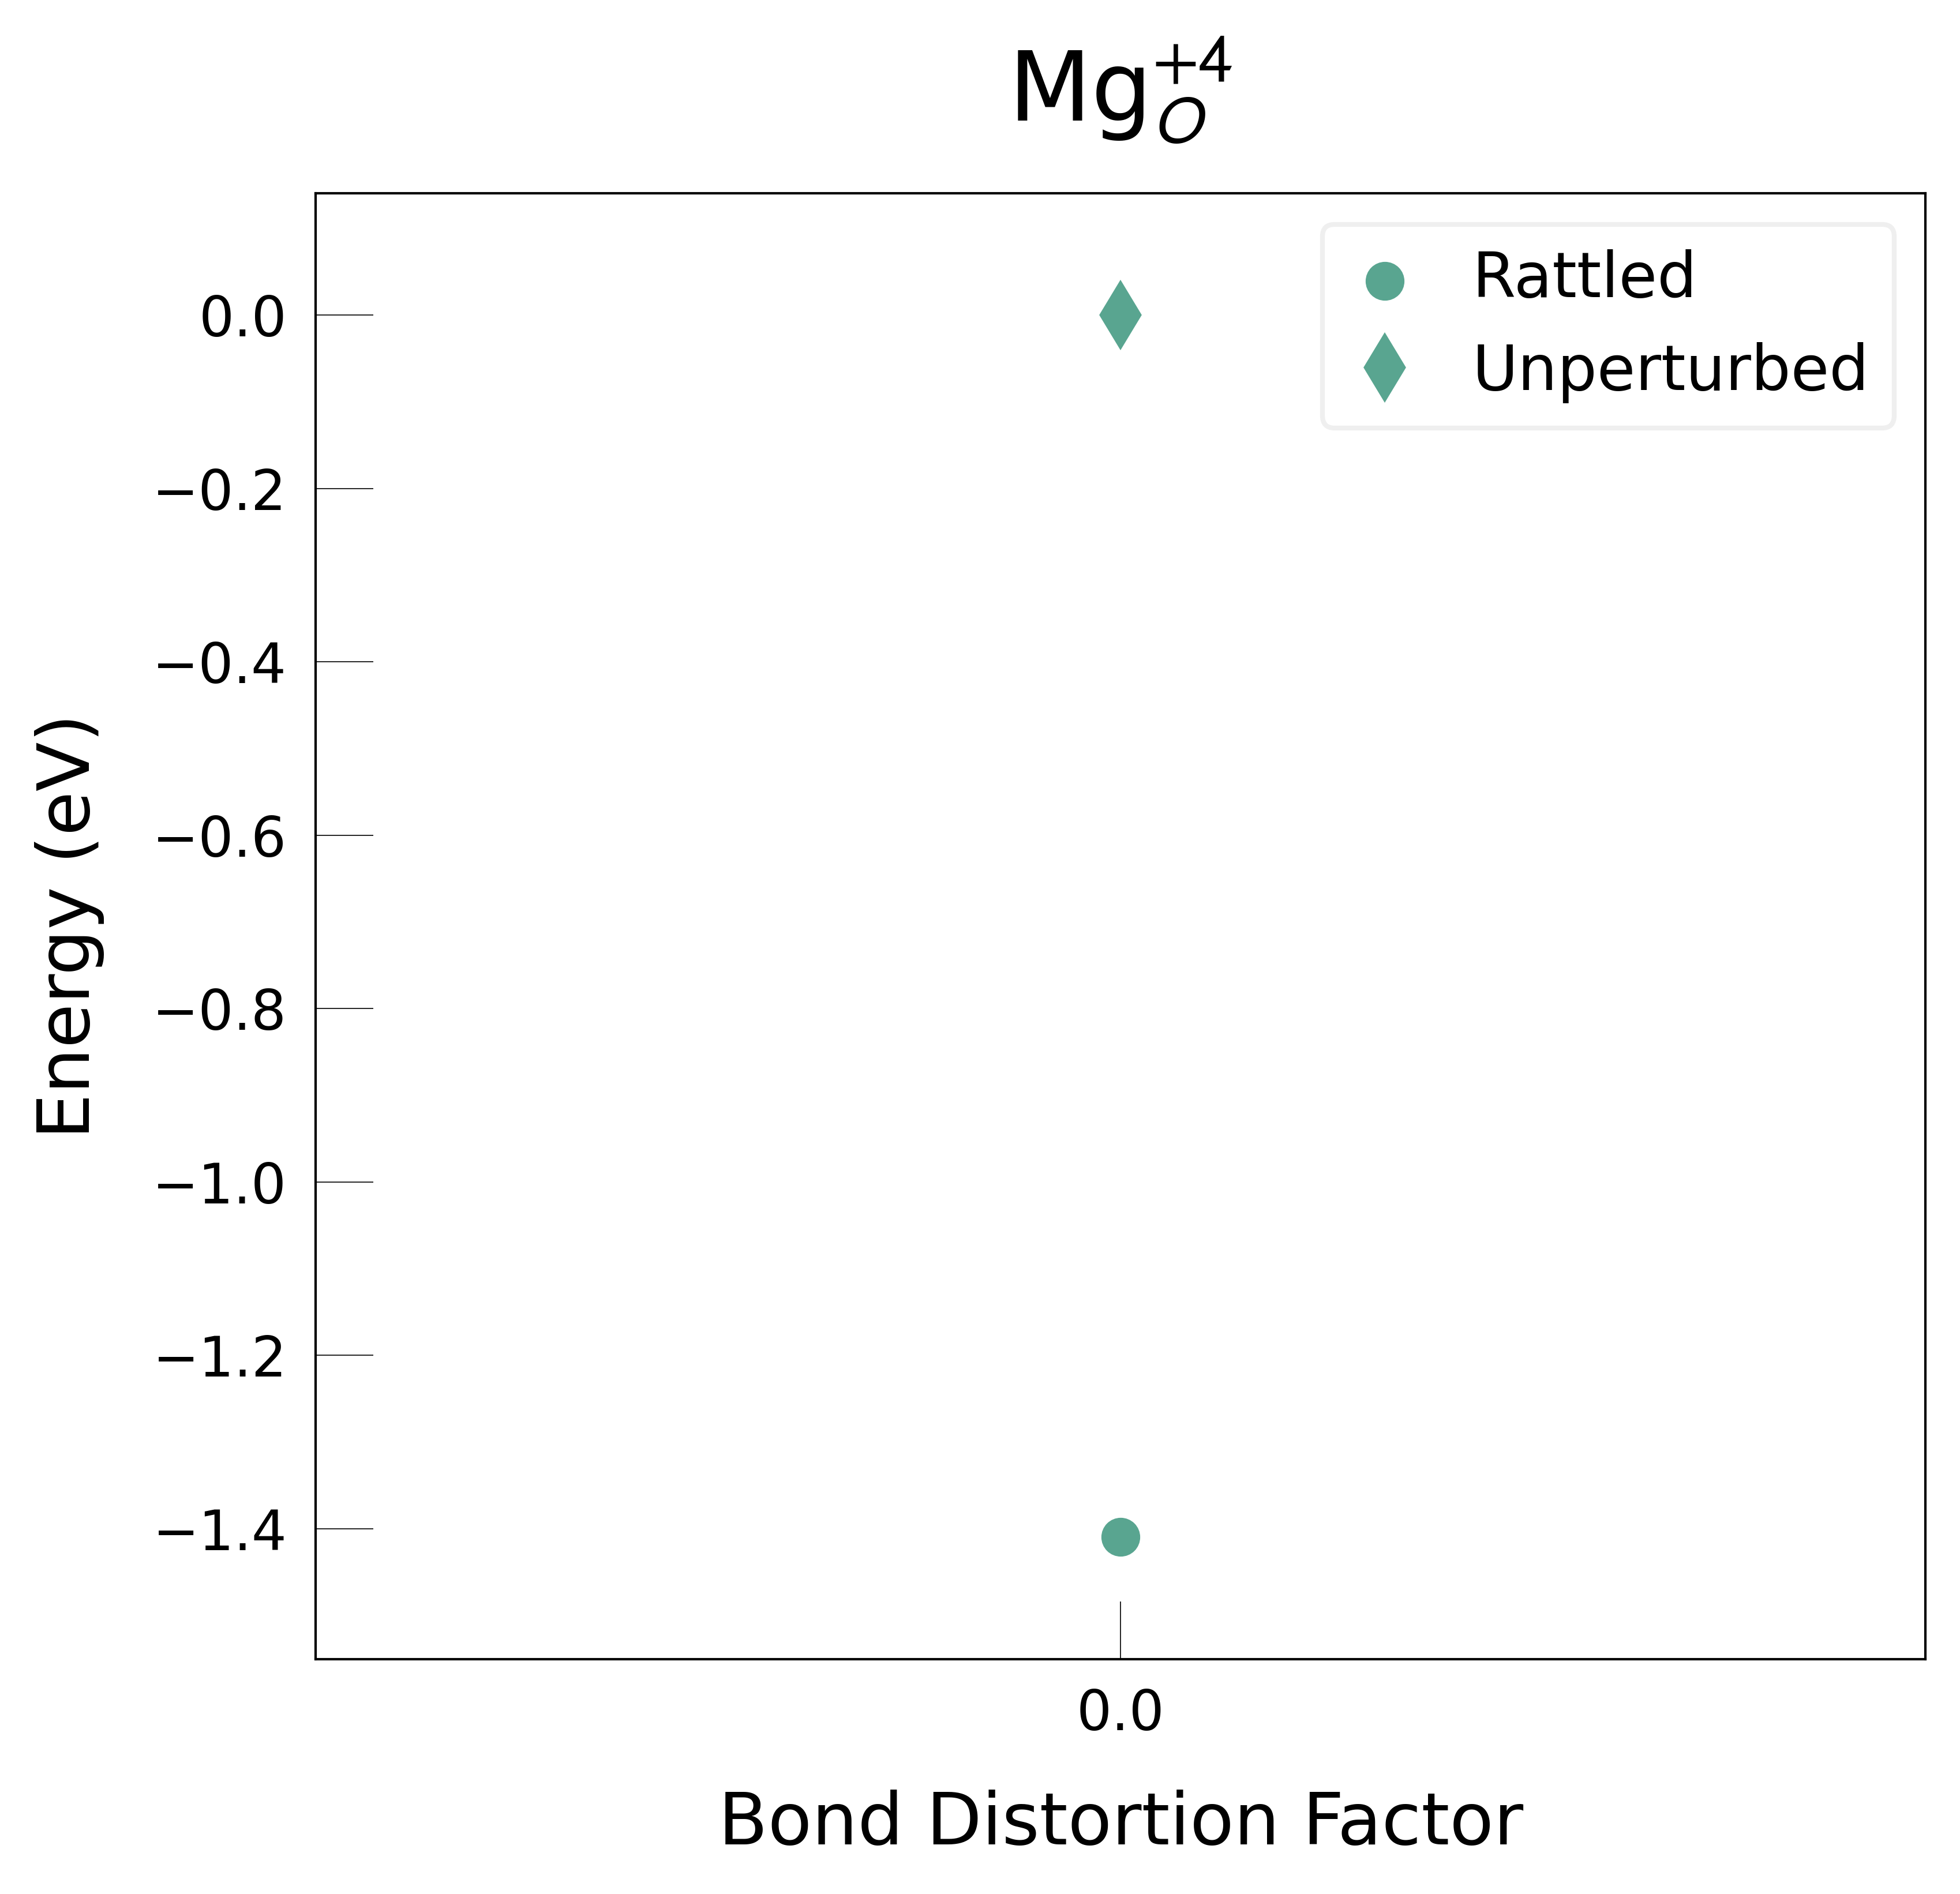

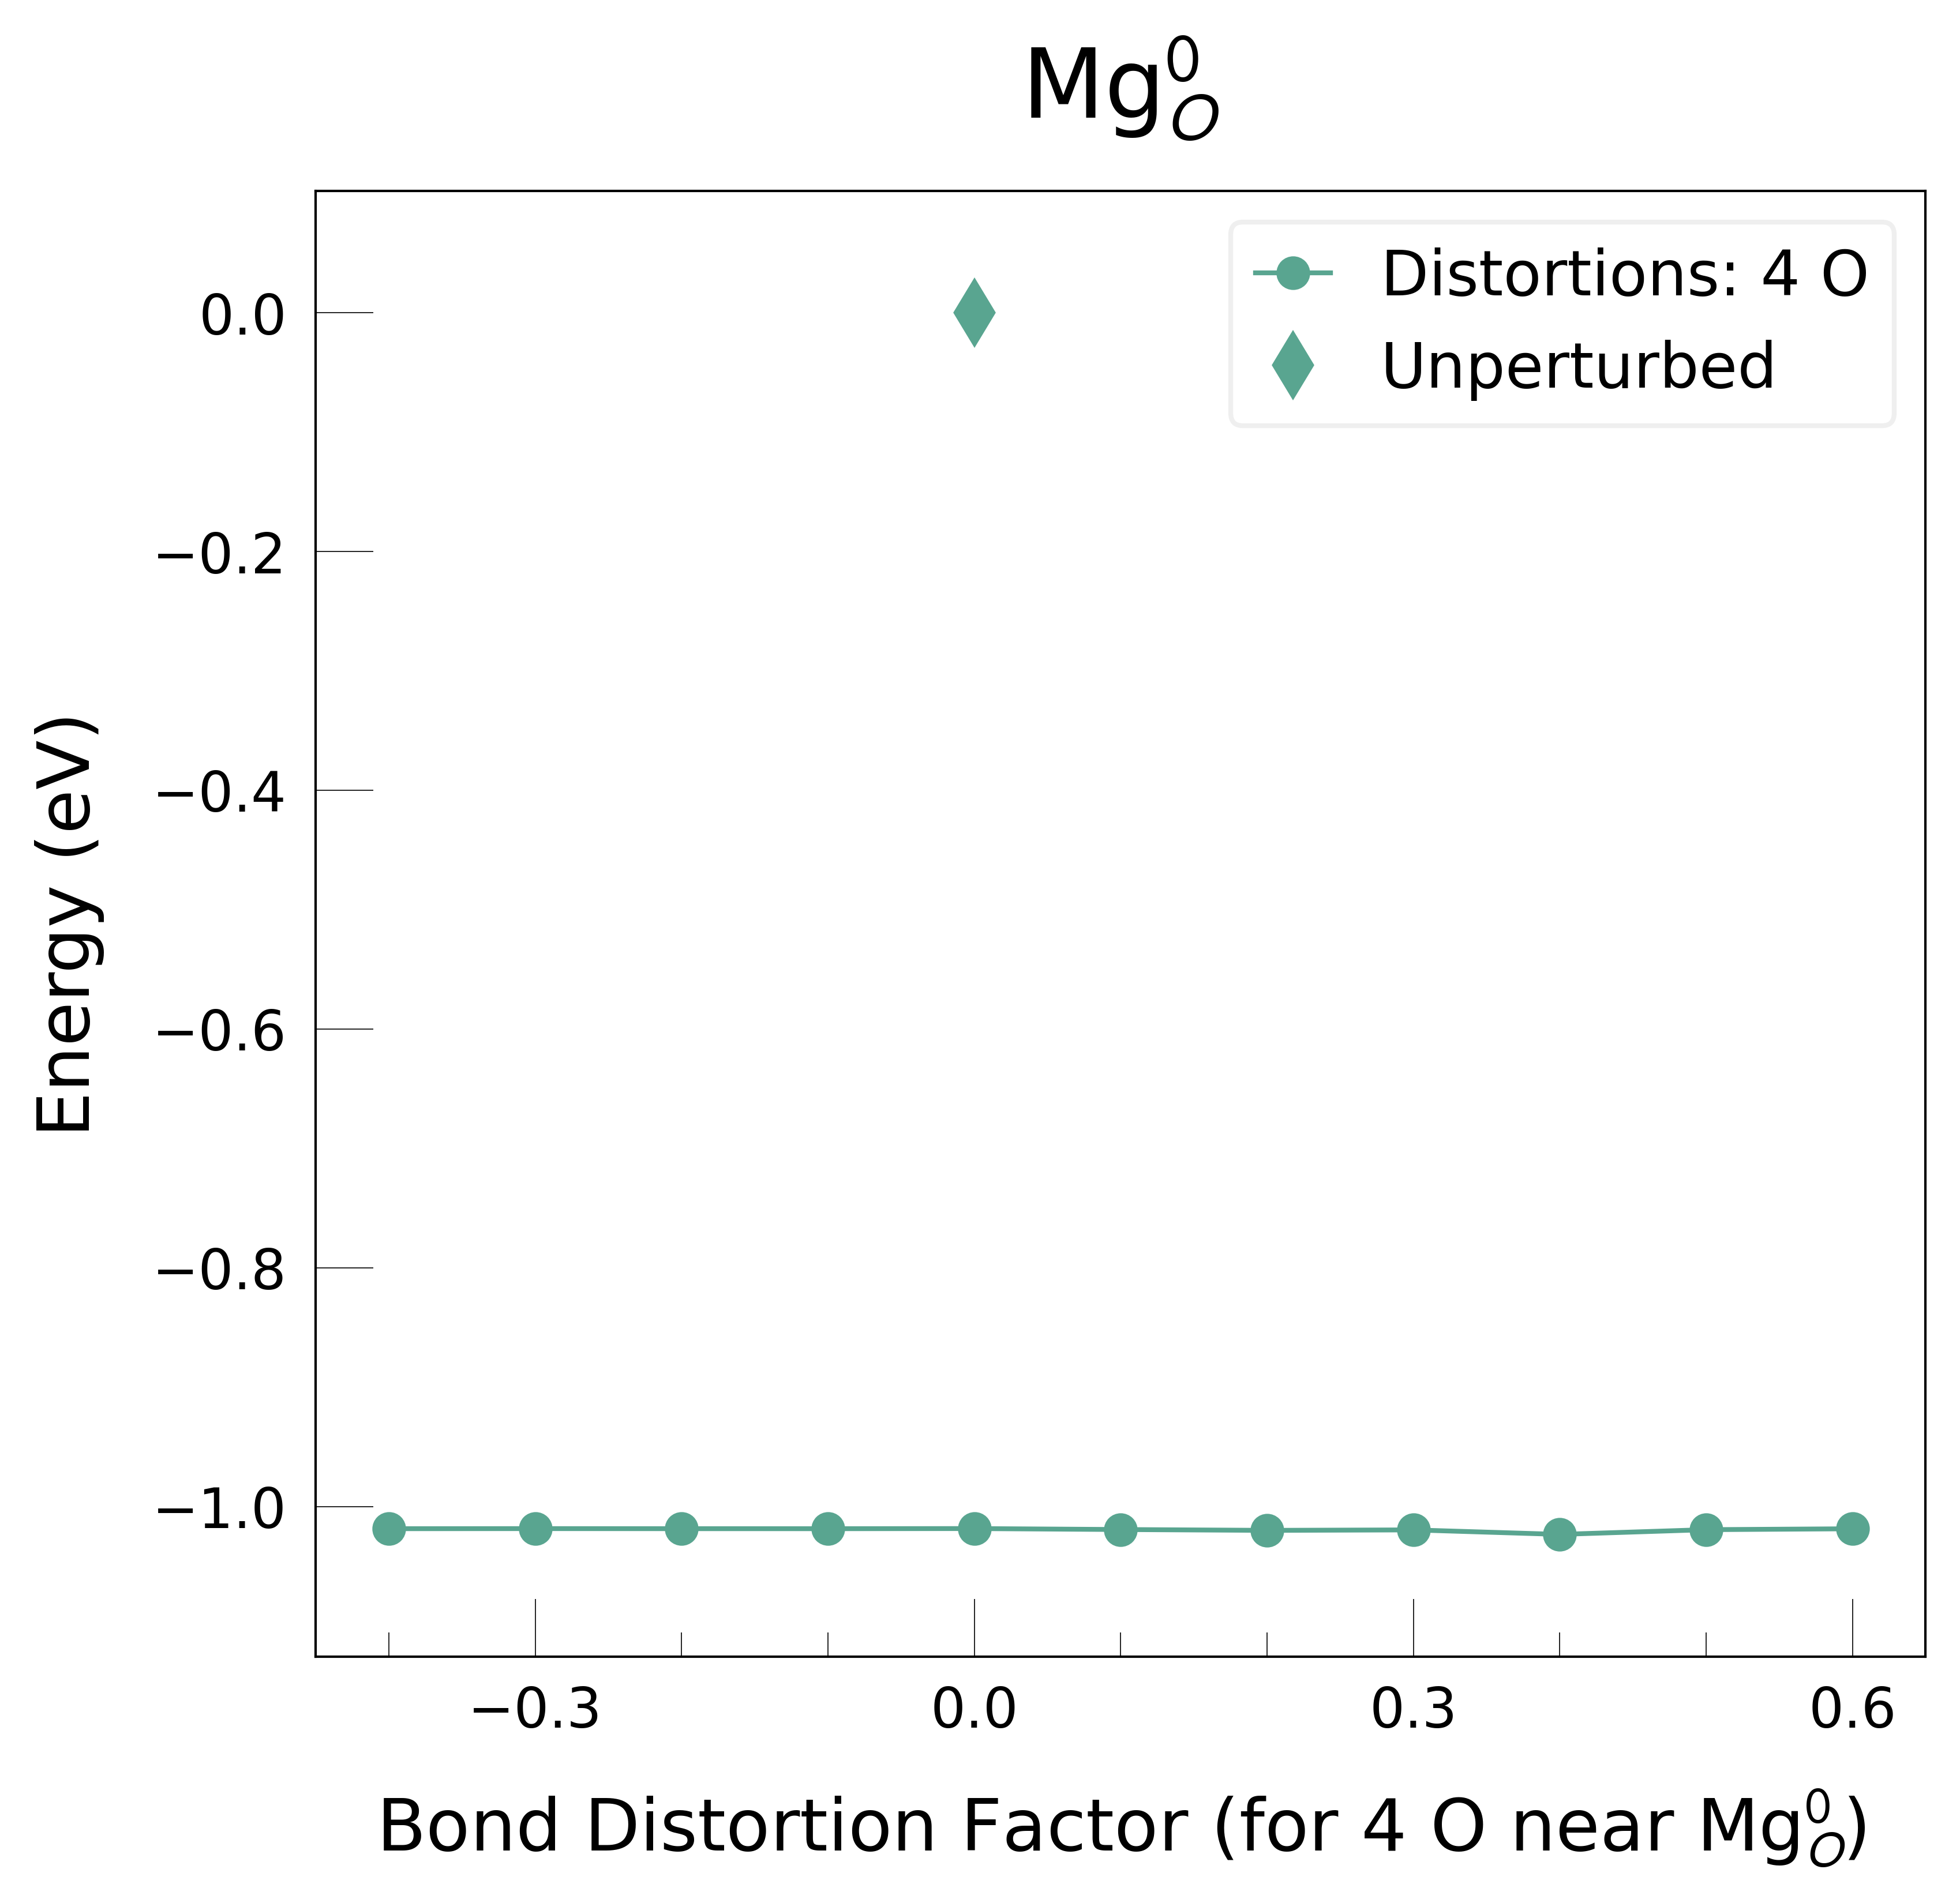

In [16]:
figs = plotting.plot_all_defects(defect_charges_dict, output_path="./MgO/SnB", add_colorbar=False)

From the plots above, we see that SnB finds energy lowering reconstructions for all charge states of Mg_O. Since the energy lowering is quite high (>0.5 eV), we expect some rebonding to be driving it. We can check this with the SnB function `get_homoionic_bonds`:

In [73]:
from shakenbreak.analysis import get_energies, get_structures, get_gs_distortion

# Check neutral charge state
energies_mg_0 = get_energies(defect_species="Mg_O_0", output_path="MgO/SnB")
structs_mg_0 = get_structures(defect_species="Mg_O_0", output_path="MgO/SnB")
energy_diff, gs_distortion = get_gs_distortion(energies_mg_0)
s_gs = structs_mg_0[gs_distortion]
s_unperturbed = structs_mg_0["Unperturbed"]

Mg_O_0: Energy difference between minimum, found with 0.4 bond distortion, and unperturbed: -1.02 eV.


The initial ideal structure of the Mg antisite involves a Mg atom surrounded by 6 other Mg. We can check the bond lengths of these bonds in the `Unperturbed` structure and in the ground state:

In [45]:
from shakenbreak.analysis import get_homoionic_bonds

print("Unperturbed structure:")
unperturbed_bonds = get_homoionic_bonds(
    structure=s_unperturbed,
    element="Mg",
    radius=2.5,
)
print(f"Ground state structure:")
gs_bonds = get_homoionic_bonds(
    structure=s_gs,
    element="Mg",
    radius=2.5,
)

Unperturbed structure:
Mg(46): {'Mg(108)': '2.39 A'} 

Mg(51): {'Mg(108)': '2.39 A'} 

Mg(52): {'Mg(108)': '2.39 A'} 

Mg(72): {'Mg(108)': '2.39 A'} 

Mg(73): {'Mg(108)': '2.39 A'} 

Mg(78): {'Mg(108)': '2.39 A'} 

Ground state structure:
Mg(46): {'Mg(108)': '2.24 A'} 

Mg(52): {'Mg(108)': '2.24 A'} 

Mg(73): {'Mg(108)': '2.24 A'} 


So the reconstruction involves replacing 6 Mg-Mg bonds of 2.39 Å by 3 shorter (2.24 Å) and 3 longer bonds. We can visualise the structures with `CrystalMaker` or `Vesta` to see the reconstruction:

Unperturbed:
<img src="../examples/MgO/Figures/Mg_O_0_Unperturbed.png" width="400"/>

Ground state:
<img src="../examples/MgO/Figures/Mg_O_0_-0p4.png" width="400"/>

where Mg is shown in yellow, O in red and the Mg antisite is shown in a different pattern.

This distortion likely lowers the electrostatic energy. We can quickly check this by calculating the Madelung energy with `pymatgen`:

In [56]:
# calculate Madelung energy with pymatgen
from pymatgen.analysis.energy_models import EwaldElectrostaticModel

ewald =  EwaldElectrostaticModel()
# Add oxidation states to structure
s_gs.add_oxidation_state_by_element({"Mg": 2, "O": -2})
s_unperturbed.add_oxidation_state_by_element({"Mg": 2, "O": -2})
ewald_E_gs = ewald.get_energy(s_gs)
ewald_E_unperturbed = ewald.get_energy(s_unperturbed)
print(f"Madelung energy of ground state structure: {ewald_E_gs:.1f} eV")
print(f"Madelung energy of unperturbed structure: {ewald_E_unperturbed:.1f} eV")
print(f"Energy difference (GS - Unperturbed): {ewald_E_gs - ewald_E_unperturbed:.1f} eV")

Madelung energy of ground state structure: -5156.2 eV
Madelung energy of unperturbed structure: -5140.7 eV
Energy difference (GS - Unperturbed): -15.5 eV


Indeed, the ground state structure has a significantly lower Ewald or electrostatic energy. We expect similar driving factors for the other charge states, but you can check them with a similar analysis.   
Other functions that may be `SnB` useful for this analysis are `compare_structures()`, `analyse_structure()` and `get_site_magnetization()` from `shakenbreak.analysis`; see the [distortion analysis section](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#optional-analyse-the-defect-distortions-found-with-snb) of the [SnB Python API tutorial](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html) for more.

Below we show the ground state structures for the other charge states:


+1:
<img src="../examples/MgO/Figures/Mg_O_+1_0p4.png" width="200"/> 

+2:
<img src="../examples/MgO/Figures/Mg_O_+2_0p6.png" width="200"/> 

+3:
<img src="../examples/MgO/Figures/Mg_O_+3_0p6.png" width="200"/> 

+4:
<img src="../examples/MgO/Figures/Mg_O_+4_Rattled.png" width="200"/> 

For these example results, we find energy lowering distortions for all charge states of Mg<sub>O</sub>. 
 We should re-test these distorted structures for the other charge states where these distortions were not found, in case they also give lower energies.

The `get_energy_lowering_distortions()` function above automatically performs structure comparisons to determine which distortions should be tested in other charge states of the same defect, and which have already been found (see docstring for more details).

In [58]:
# generates the new distorted structures and VASP inputs, to do our quick 2nd round of structure testing:
energy_lowering_distortions.write_retest_inputs(low_energy_defects, output_path="MgO/SnB")

Writing low-energy distorted structure to MgO/SnB/Mg_O_+4/Bond_Distortion_40.0%_from_+1
Writing low-energy distorted structure to MgO/SnB/Mg_O_0/Rattled_from_+4
Writing low-energy distorted structure to MgO/SnB/Mg_O_+1/Rattled_from_+4
Writing low-energy distorted structure to MgO/SnB/Mg_O_+2/Rattled_from_+4
Writing low-energy distorted structure to MgO/SnB/Mg_O_+3/Rattled_from_+4


Again we run the calculations on the HPCs, then parse and plot the results either using the `SnB` CLI
functions, or through the python API as exemplified here.

In [9]:
from shakenbreak import energy_lowering_distortions

# re-parse with the same `get_energy_lowering_distortions()` function from before:
defect_charges_dict = energy_lowering_distortions.read_defects_directories(output_path="MgO/SnB")
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict, output_path="MgO/SnB")


Mg_O
Mg_O_+3: Energy difference between minimum, found with 0.6 bond distortion, and unperturbed: -1.41 eV.
Energy lowering distortion found for Mg_O with charge +3. Adding to low_energy_defects dictionary.
Mg_O_+4: Energy difference between minimum, found with Rattled bond distortion, and unperturbed: -1.41 eV.
New (according to structure matching) low-energy distorted structure found for Mg_O_+4, adding to low_energy_defects['Mg_O'] list.
Mg_O_+2: Energy difference between minimum, found with 0.6 bond distortion, and unperturbed: -1.23 eV.
Low-energy distorted structure for Mg_O_+2 already found with charge states ['+3'], storing together.
Mg_O_0: Energy difference between minimum, found with 0.4 bond distortion, and unperturbed: -1.02 eV.
Low-energy distorted structure for Mg_O_0 already found with charge states ['+3', '+2'], storing together.
Mg_O_+1: Energy difference between minimum, found with 0.4 bond distortion, and unperturbed: -0.99 eV.
Low-energy distorted structure for Mg

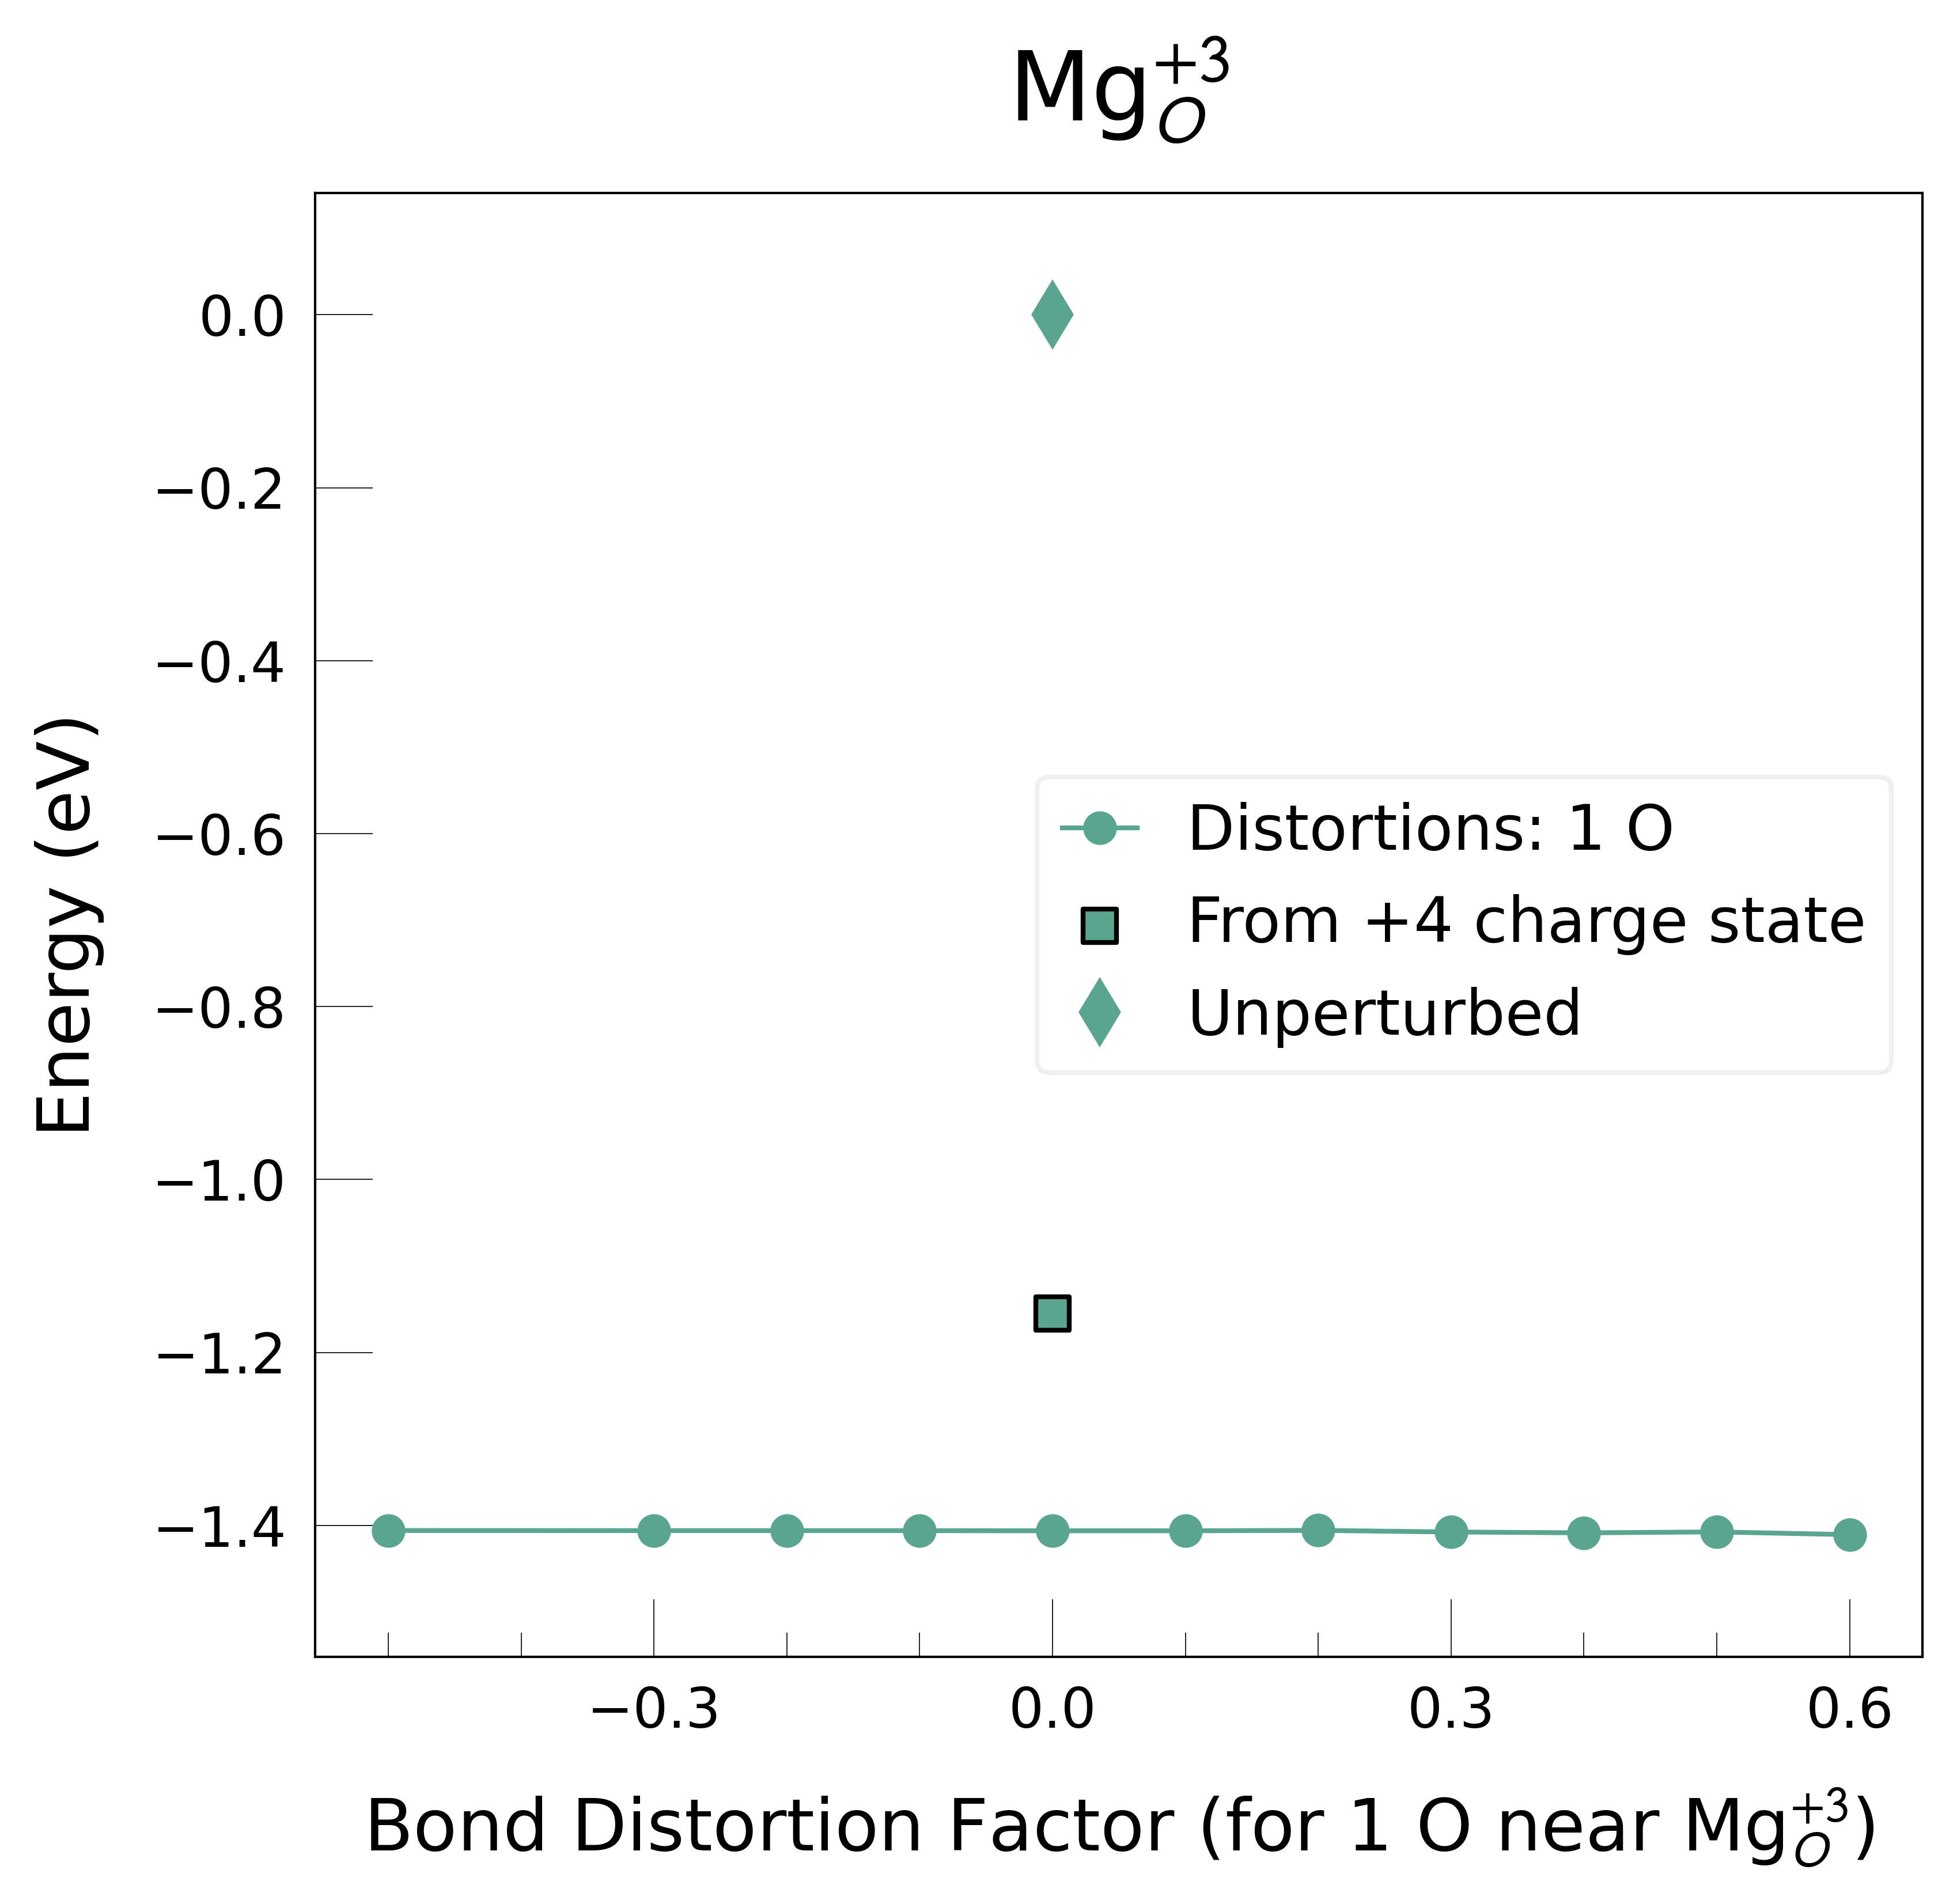

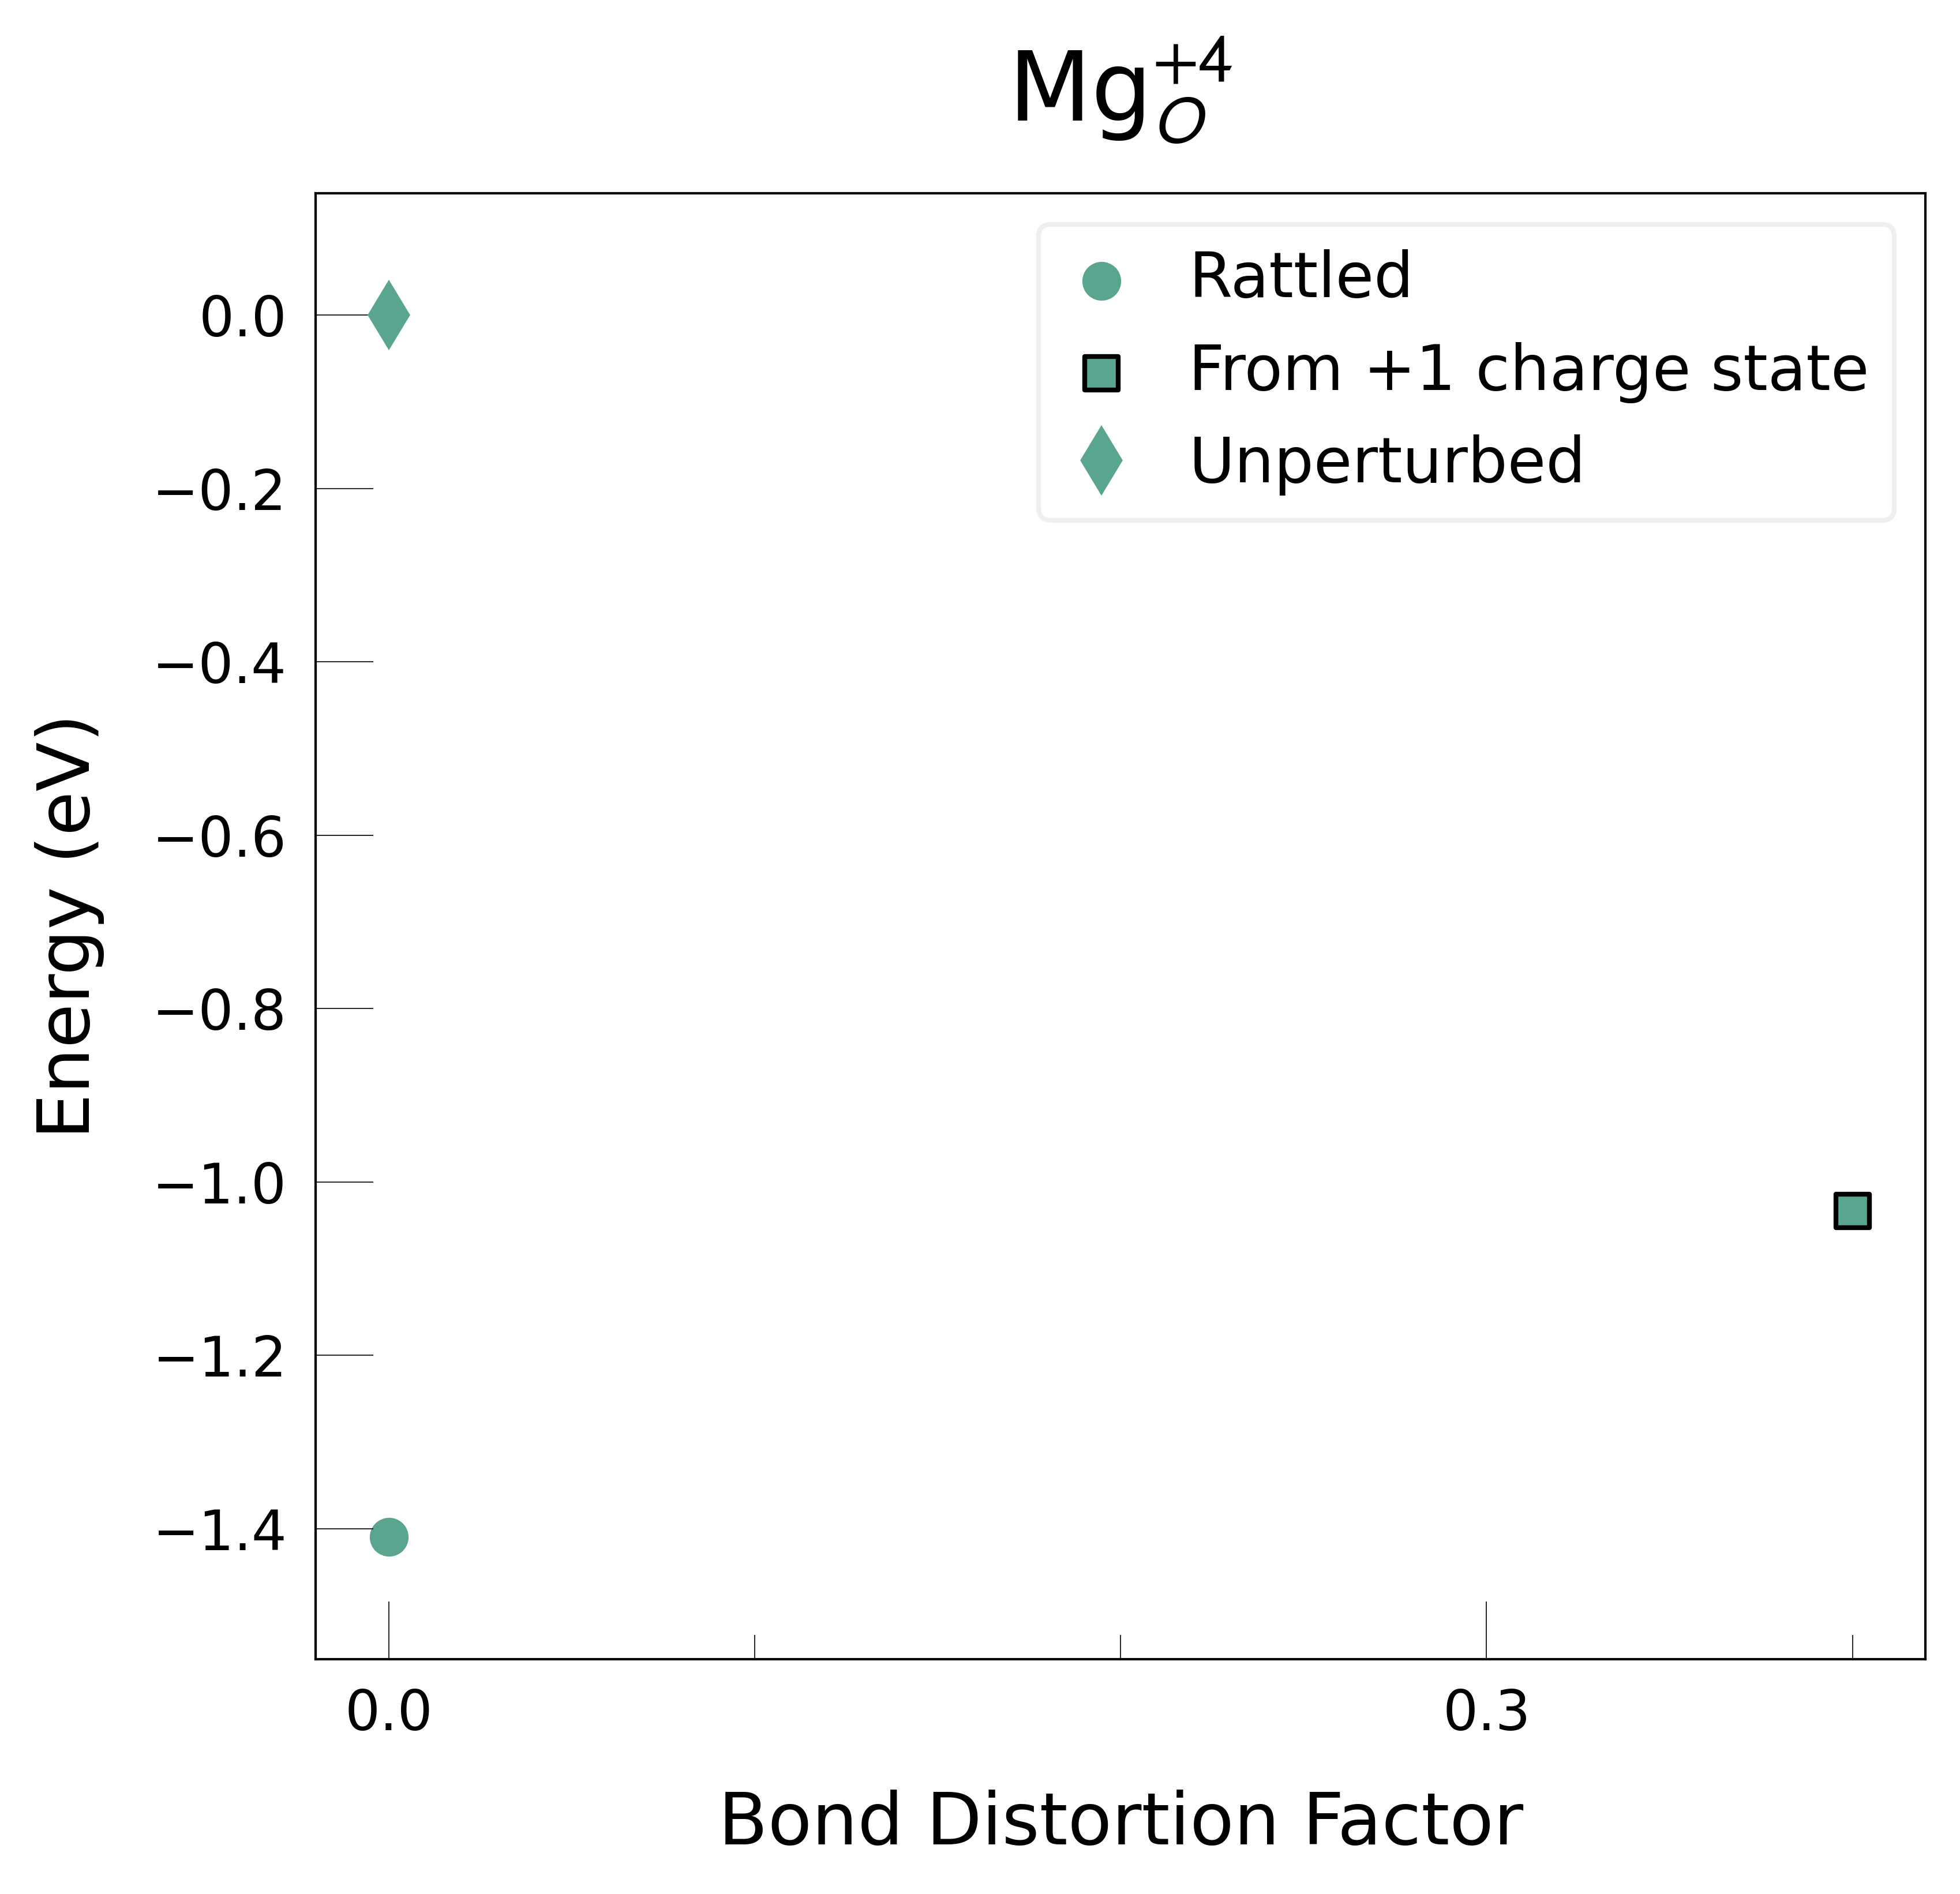

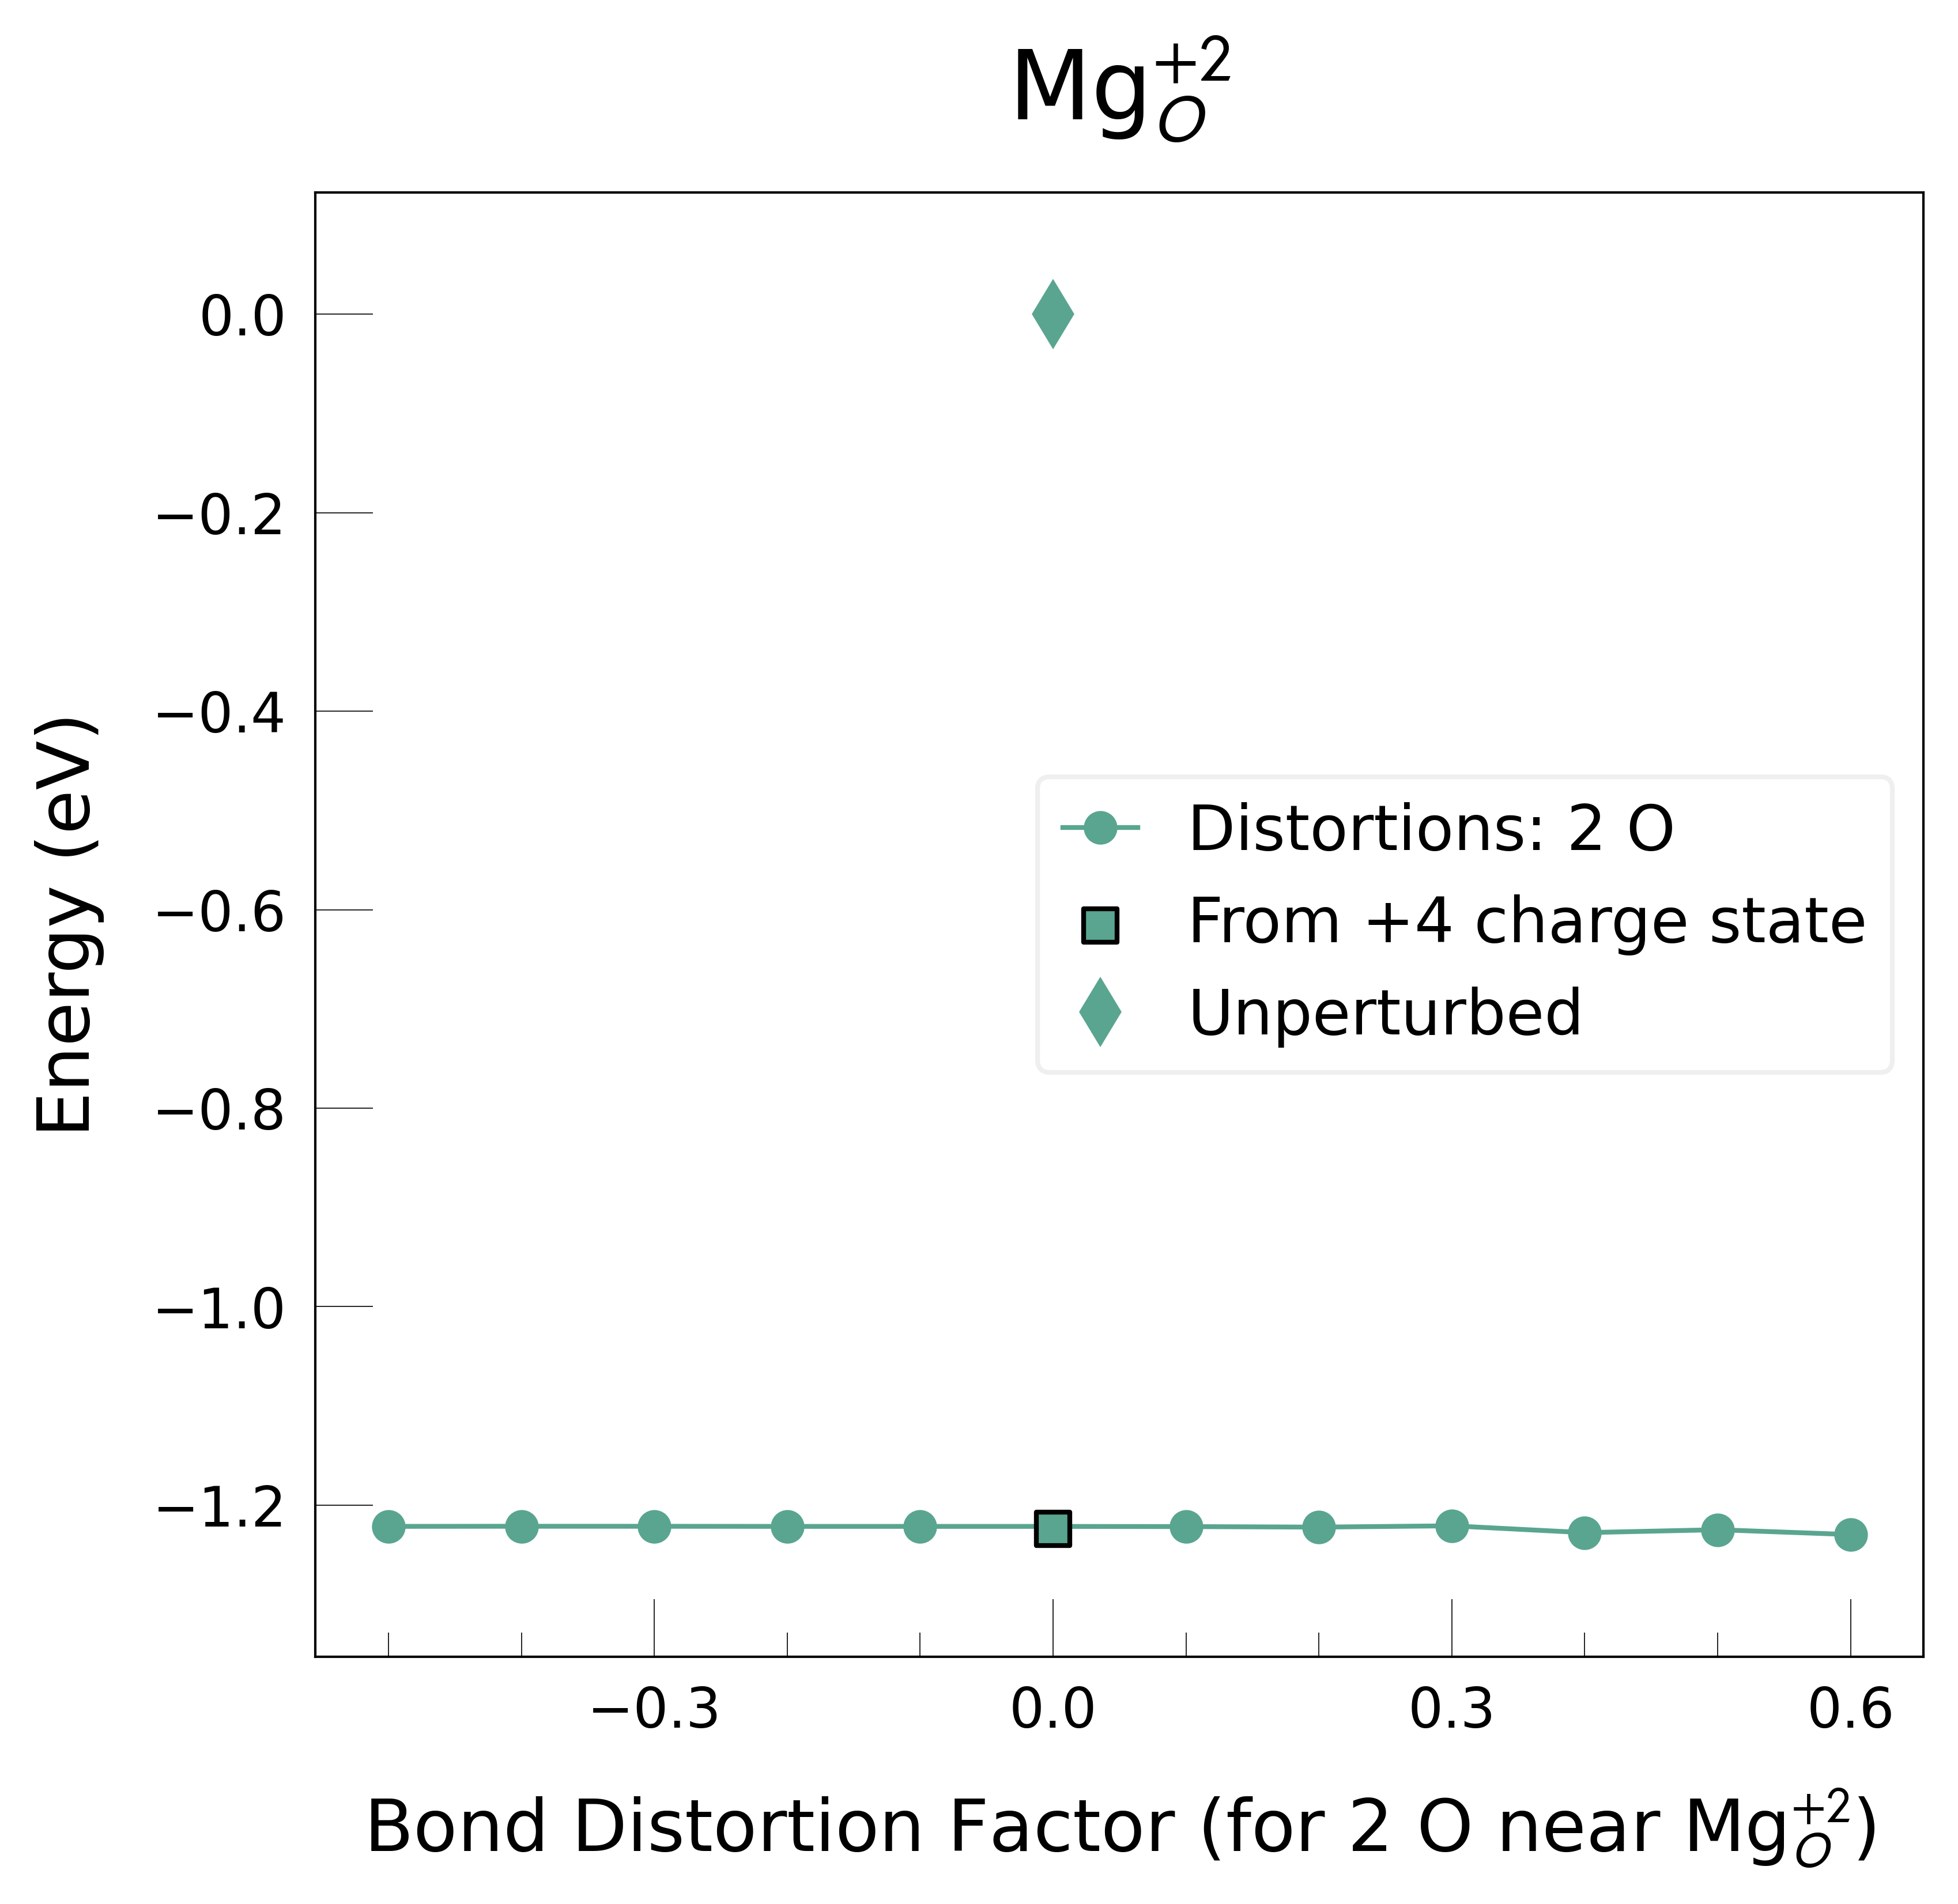

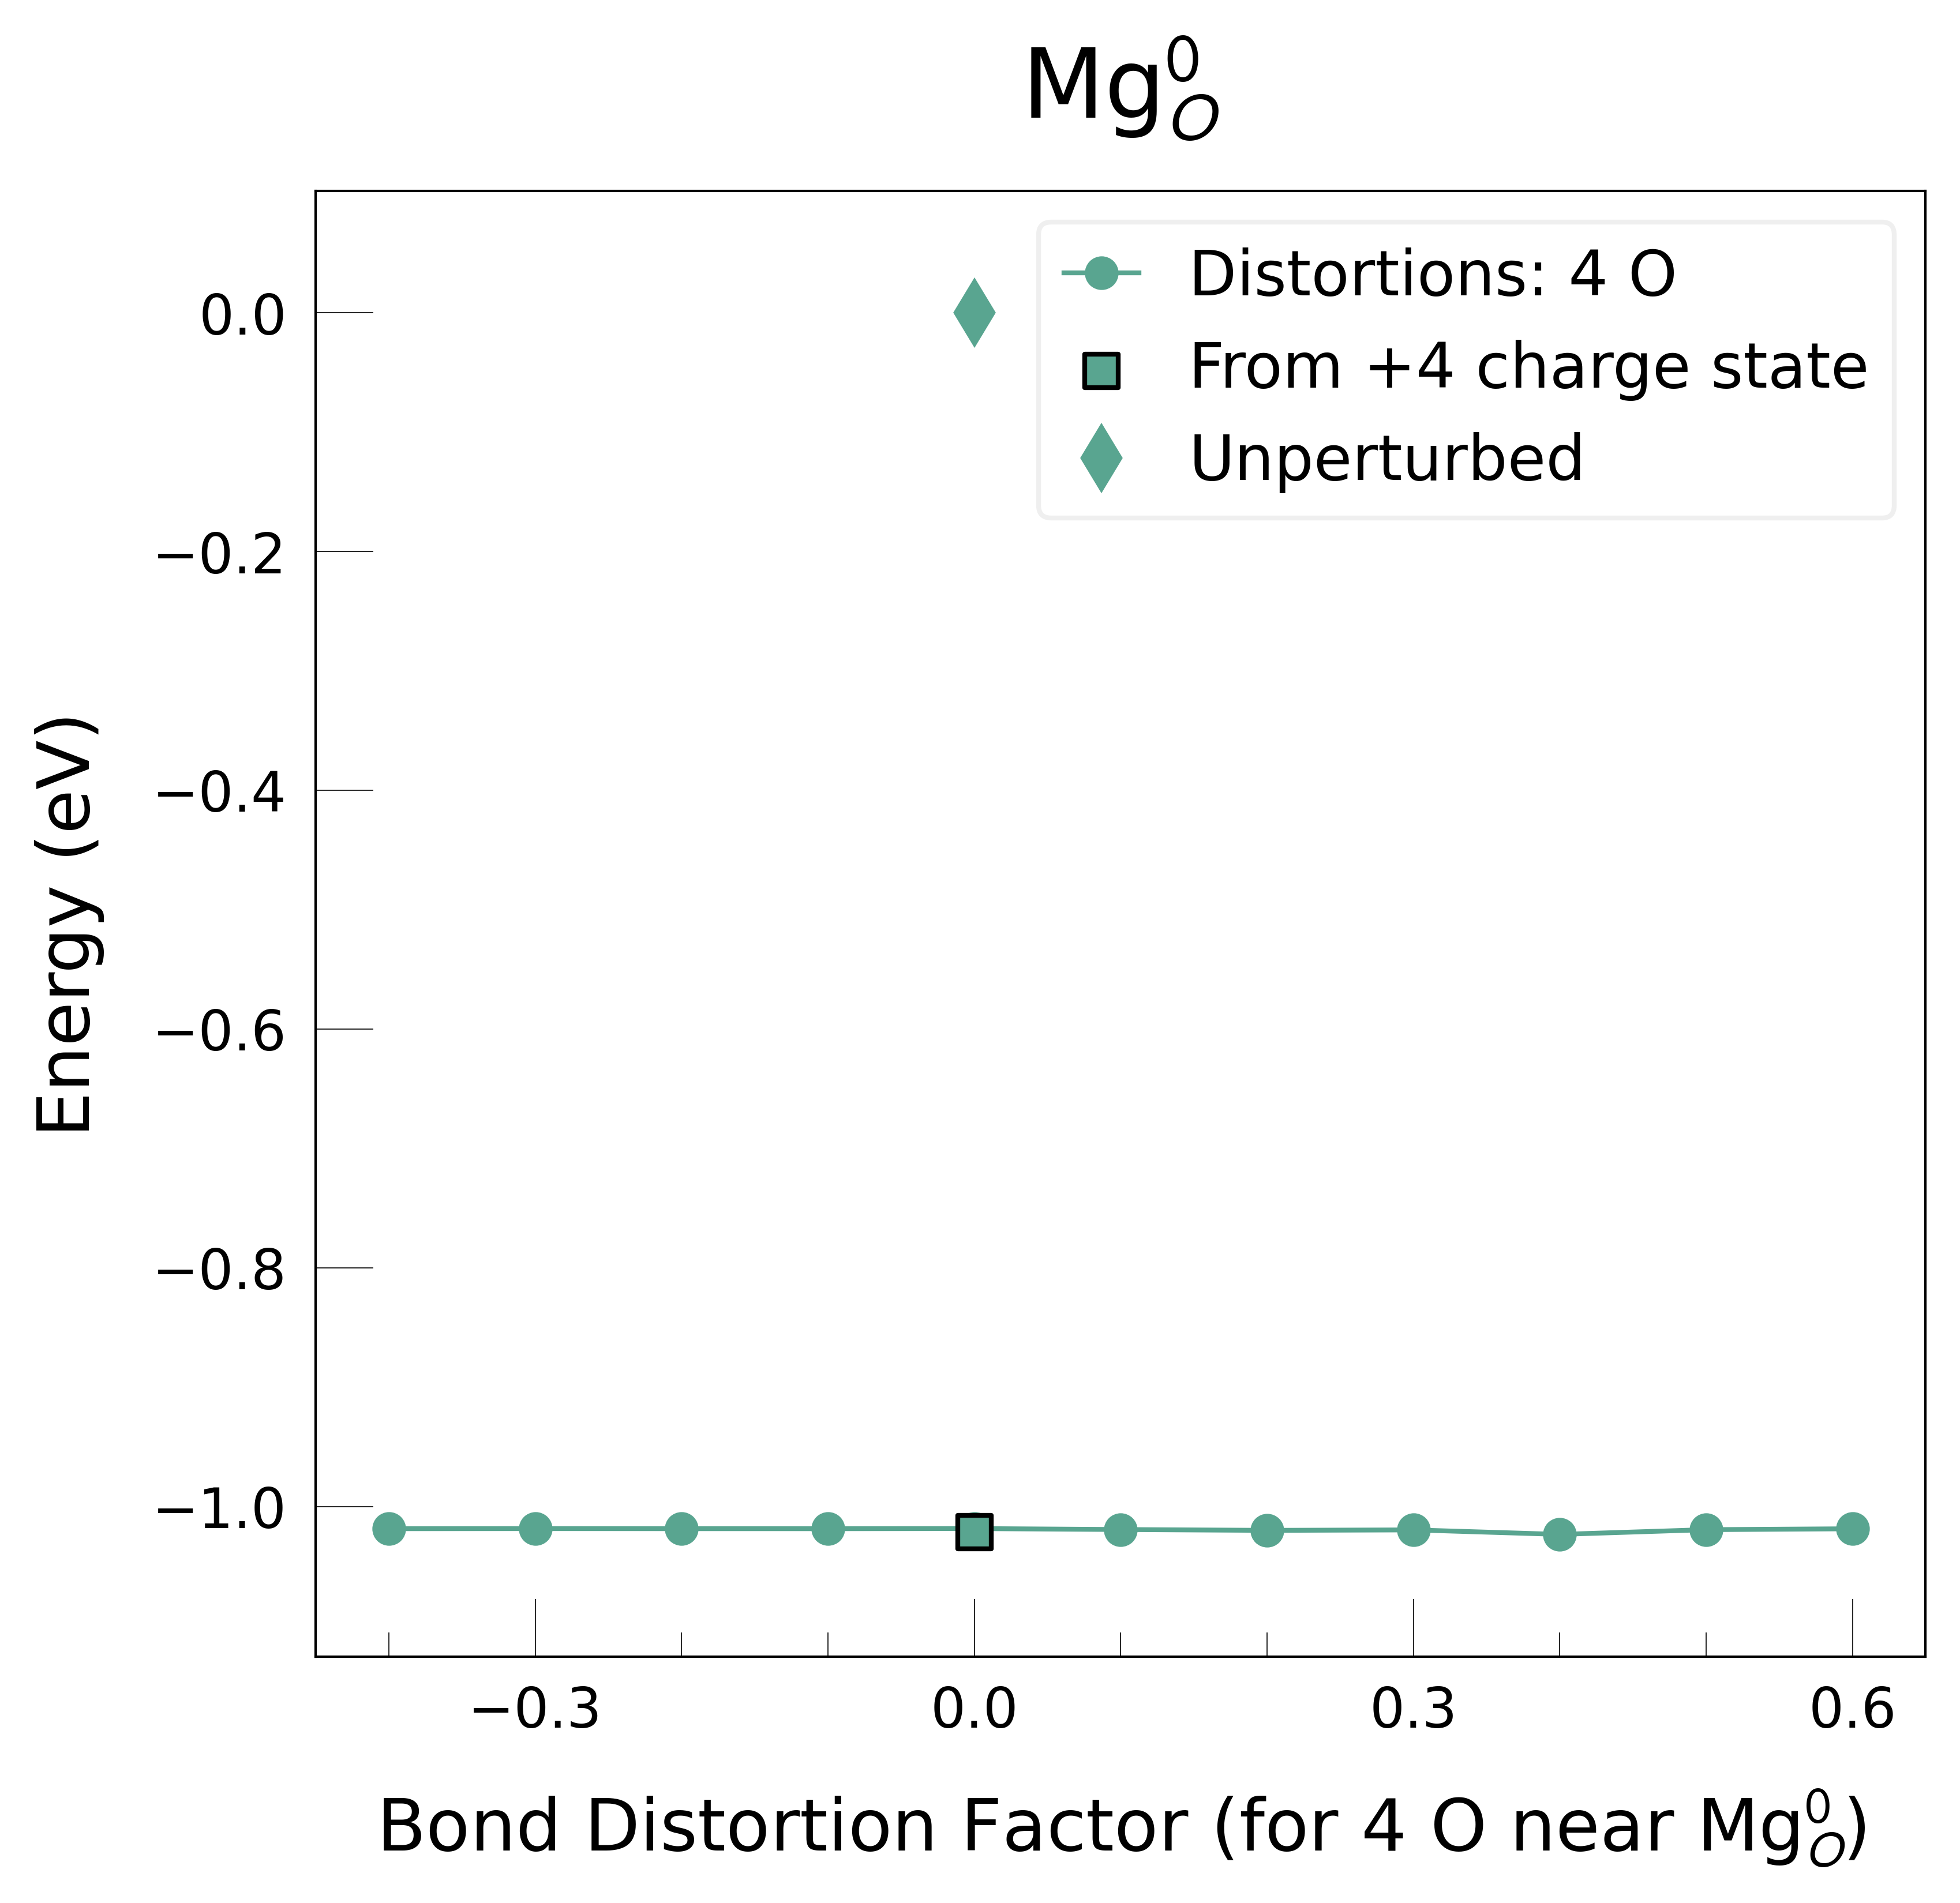

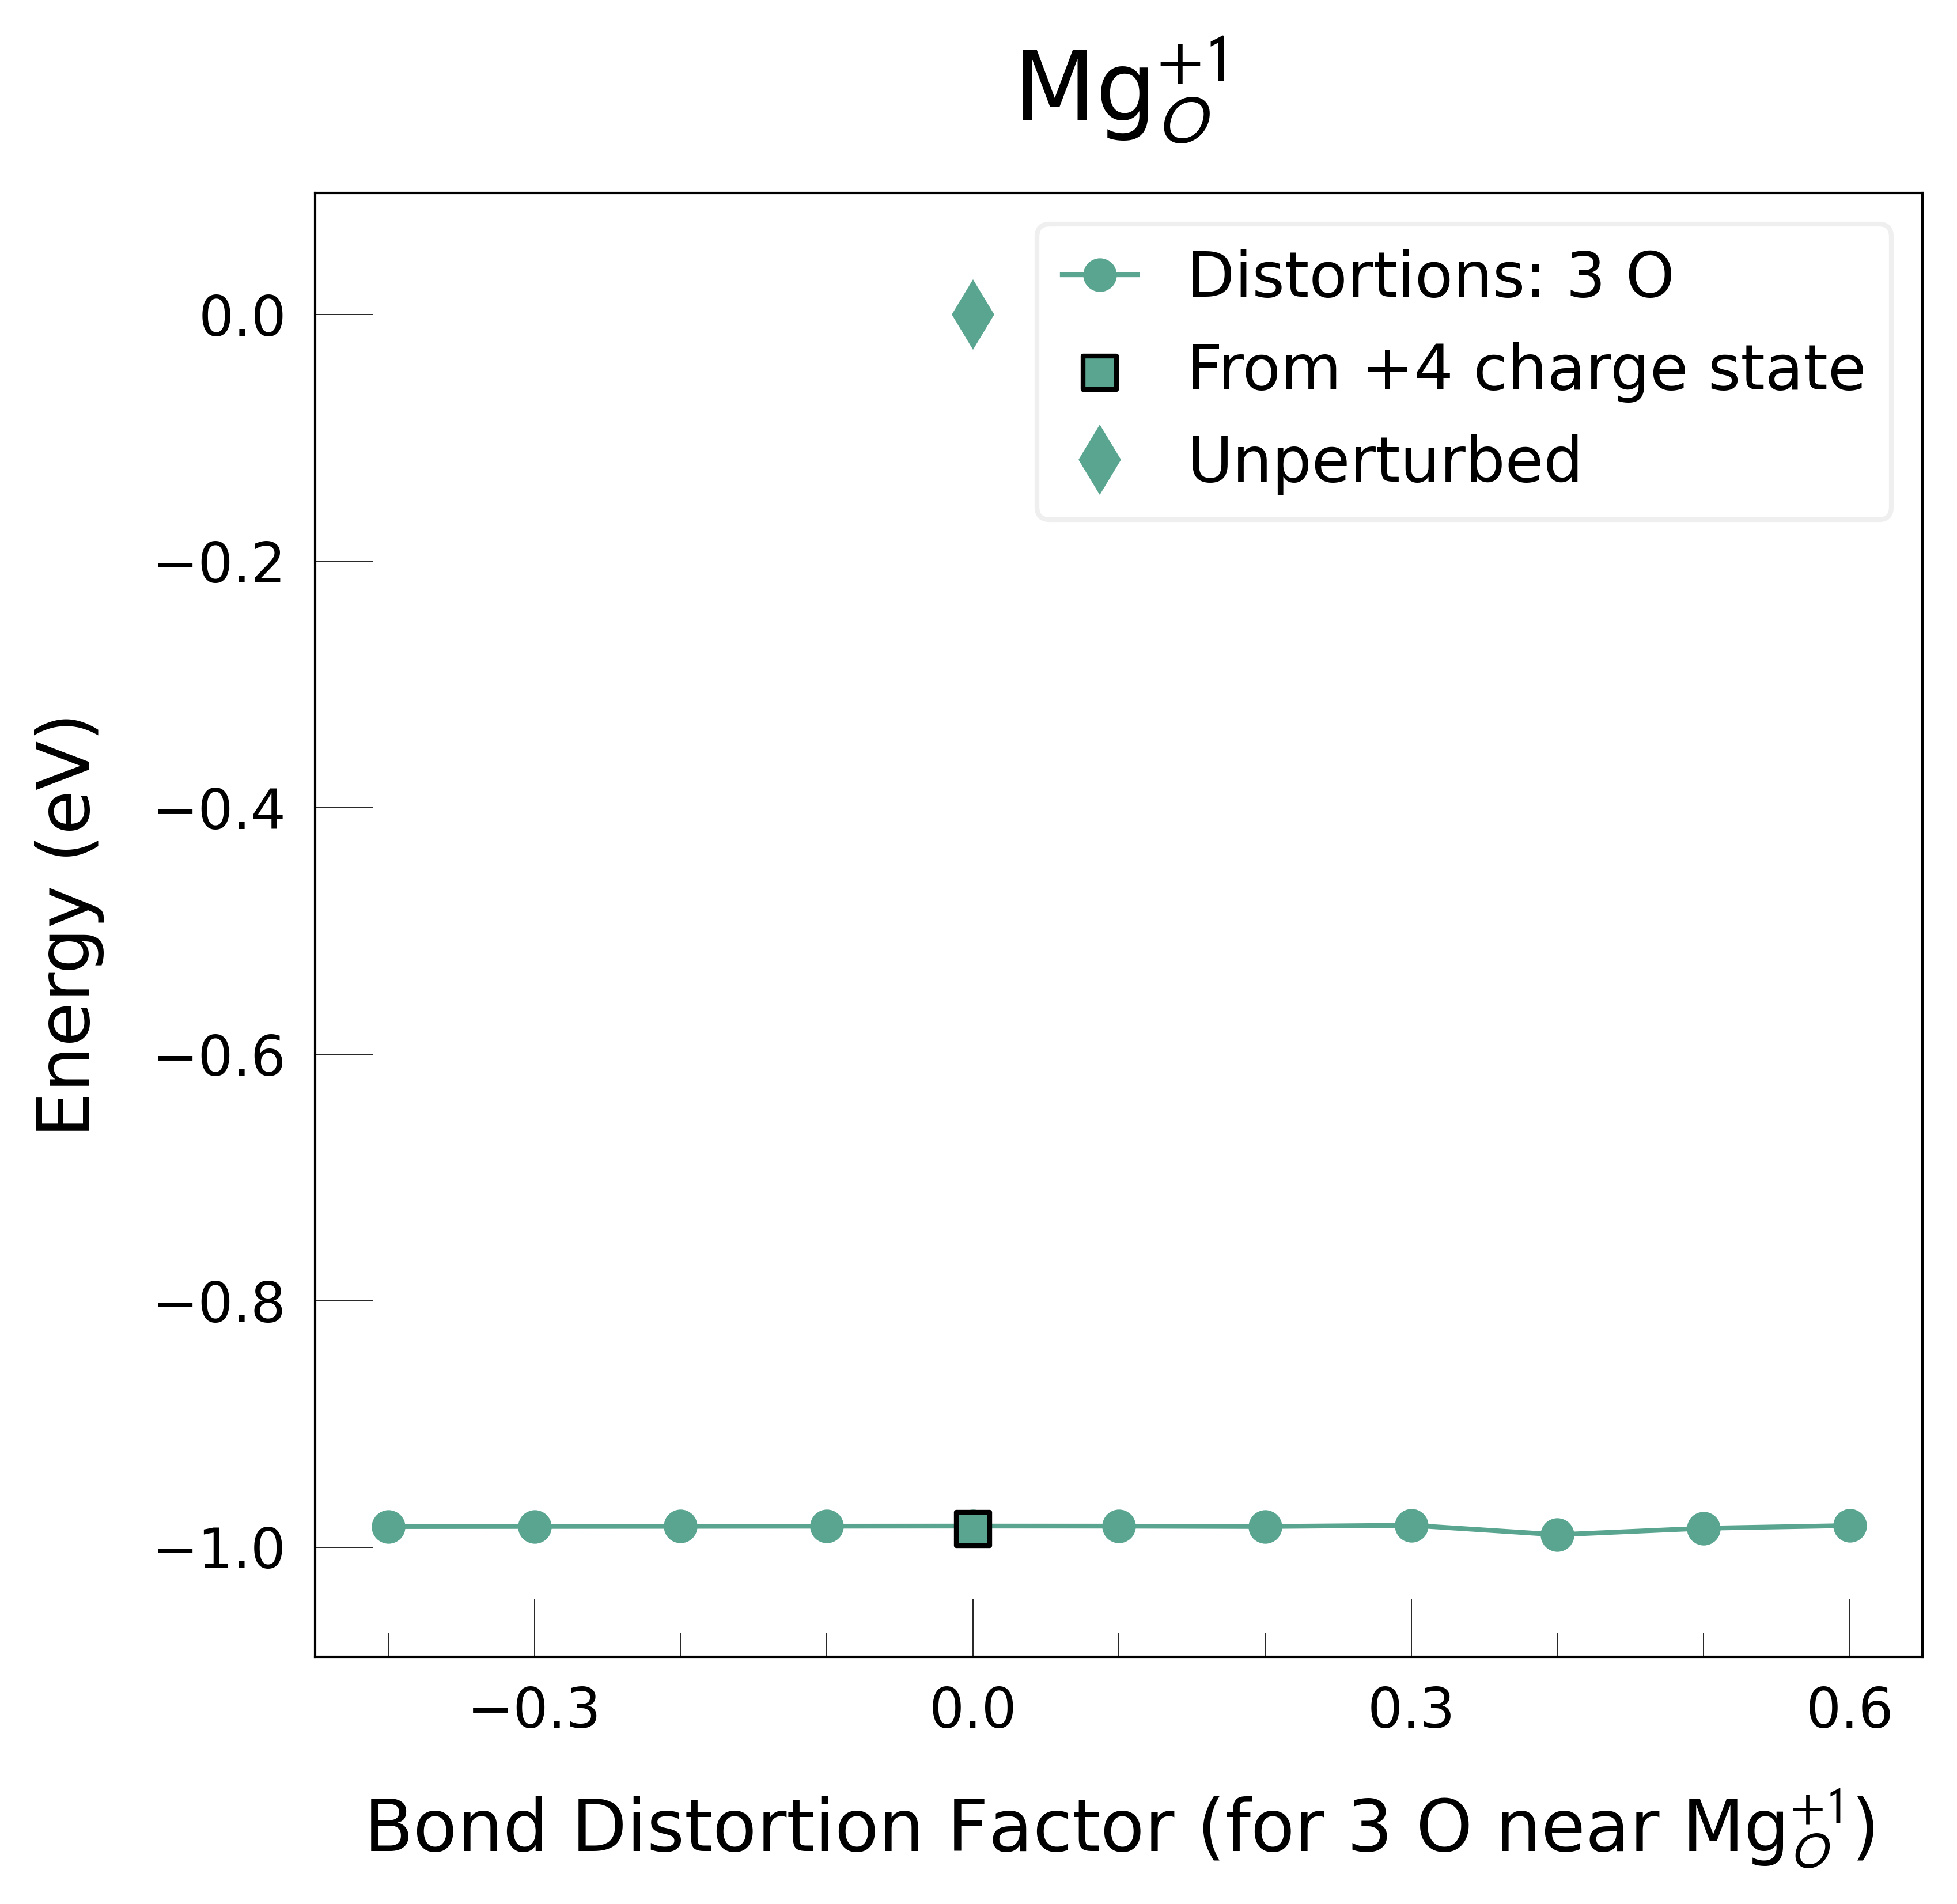

In [3]:
from shakenbreak import plotting

figs = plotting.plot_all_defects(defect_charges_dict, output_path="./MgO/SnB", add_colorbar=False)

We now continue our defect calculations using the ground-state `CONTCAR`s we've obtained for each
defect, with our fully-converged `INCAR` and `KPOINTS` settings (via the `doped` `vasp.DefectsSet`
class below, to get our final defect formation energies (confident that we've identified the ground-state
defect structure!)). The `energy_lowering_distortions.write_groundstate_structure()` function automatically writes these lowest-energy structures to our defect folders:

In [11]:
energy_lowering_distortions.write_groundstate_structure(output_path="MgO/SnB")

```{tip}
Usually we would use something like `write_groundstate_structure(groundstate_folder="vasp_std", groundstate_filename="POSCAR")` (or `snb-groundstate -d vasp_std ...` on the CLI) as shown in the main `doped` generation tutorial, which saves the ground-state `POSCAR`s directly to the `vasp_std` defect subfolders to be used with our later calculations with `doped`.
However here because we have separated our SnB calculations and `doped` defect calculations to different folders, we just use the default behaviour (which saves the ground-state structures to `groundstate_POSCAR` in each defect directory) and will later copy over these `POSCAR` files.
```

## 5. Prepare `VASP` calculation files with `doped`

We can estimate the kpoint grid needed for the supercell by calculating the ratio of the supercell lattice parameters to the primitive lattice parameters. For this, we load the `DefectGenerator` object that we saved earlier:

In [26]:
from doped.generation import DefectsGenerator

defect_gen = DefectsGenerator.from_json("MgO/defect_gen.json")

In [28]:
from pymatgen.core.structure import Structure
import numpy as np

prim_struc = Structure.from_file("MgO/Bulk_relax/CONTCAR")
supercell = defect_gen.bulk_supercell
converged_kgrid = (7, 7, 7)

ratio = np.array(supercell.lattice.abc) / np.array(prim_struc.lattice.abc)
print(f"Ratio of supercell lattice to primitive lattice: {ratio}")
kgrid = tuple(np.array(converged_kgrid) / ratio) # Divide by supercell expansion to get kgrid for supercell
print(f"Kgrid for supercell:", kgrid)
# Round kgrid to next highest integer
print(f"Rounded kgrid for supercell:", [int(np.ceil(k)) for k in kgrid])

Ratio of supercell lattice to primitive lattice: [4.24264027 4.24264027 4.24264027]
Kgrid for supercell: (1.6499159830969252, 1.6499159830969252, 1.6499159830969252)
Rounded kgrid for supercell: [2, 2, 2]


To generate our VASP input files for the defect calculations, we can use the `DefectsSet` class in the
`vasp` module of `doped`:

In [3]:
from doped.vasp import DefectsSet  # append "?" to function/class to see the help docstrings:
DefectsSet?

Init signature:
DefectsSet(
    defect_entries: Union[doped.generation.DefectsGenerator, Dict[str, doped.core.DefectEntry], List[doped.core.DefectEntry], doped.core.DefectEntry],
    soc: Optional[bool] = None,
    user_incar_settings: Optional[dict] = None,
    user_kpoints_settings: Union[dict, pymatgen.io.vasp.inputs.Kpoints, NoneType] = None,
    user_potcar_functional: Optional[Literal['PBE', 'PBE_52', 'PBE_54', 'LDA', 'LDA_52', 'LDA_54', 'PW91', 'LDA_US', 'PW91_US']] = 'PBE',
    user_potcar_settings: Optional[dict] = None,
    **kwargs,
)
Docstring:     
An object for generating input files for VASP defect calculations from
doped/pymatgen ``DefectEntry`` objects.
Init docstring:
Creates a dictionary of: {defect_species: DefectRelaxSet}.

DefectRelaxSet has the attributes:

- ``DefectRelaxSet.vasp_gam``:
    ``DefectDictSet`` for Gamma-point only relaxation. Usually not needed if
    ShakeNBreak structure searching has been performed (recommended), unless
    only Γ-point `k`-poi

In [3]:
from doped.vasp import DefectsSet  # append "?" to function/class to see the help docstrings:
from pymatgen.io.vasp.inputs import Kpoints

defect_set = DefectsSet(
    defect_gen,  # our DefectsGenerator object, can also input individual DefectEntry objects if desired
    user_incar_settings={
        "ENCUT": 450,
        "GGA": "PS",  # Functional (PBEsol for this tutorial)
        "LHFCALC": False, # Disable Hybrid functional
        "NCORE": 8, # Parallelisation, might need updating for your HPC!
    },  # custom INCAR settings, any that aren't numbers or True/False need to be input as strings with quotation marks!
    user_kpoints_settings=Kpoints(kpts=[(2,2,2)]),
)
# We can also customise the POTCAR settings (and others), see the docstrings above for more info

The `DefectsSet` class prepares a dictionary in the form `{defect_species: DefectRelaxSet}`, where
`DefectRelaxSet` has attributes: `vasp_nkred_std` (if using hybrid DFT; not the case here), `vasp_std` (if our final _k_-point sampling is
non-Γ-only with multiple _k_-points), `vasp_ncl` (if SOC included; not the case here as Mg/O are not heavy atoms where SOC is relevant, see docstrings for default behaviour)
and/or `vasp_gam` (if our final _k_-point sampling is Γ-only).
These attributes are `DefectDictSet` objects, subclasses of the `pymatgen` `DictSet` object, and contain
 information about the calculation inputs.

In [4]:
defect_set.defect_sets

{'v_Mg_+1': doped DefectRelaxSet for bulk composition MgO, and defect entry v_Mg_+1. Available attributes:
 {'defect_entry', 'user_potcar_settings', 'bulk_vasp_std', 'poscar_comment', 'vasp_nkred_std', 'bulk_supercell', 'vasp_gam', 'defect_supercell', 'soc', 'vasp_ncl', 'bulk_vasp_nkred_std', 'dict_set_kwargs', 'user_kpoints_settings', 'user_incar_settings', 'bulk_vasp_gam', 'bulk_vasp_ncl', 'user_potcar_functional', 'charge_state', 'vasp_std'}
 
 Available methods:
 {'validate_monty_v1', 'validate_monty_v2', 'write_all', 'write_std', 'unsafe_hash', 'as_dict', 'from_dict', 'write_nkred_std', 'write_ncl', 'to_json', 'write_gam'},
 'v_Mg_0': doped DefectRelaxSet for bulk composition MgO, and defect entry v_Mg_0. Available attributes:
 {'defect_entry', 'user_potcar_settings', 'bulk_vasp_std', 'poscar_comment', 'vasp_nkred_std', 'bulk_supercell', 'vasp_gam', 'defect_supercell', 'soc', 'vasp_ncl', 'bulk_vasp_nkred_std', 'dict_set_kwargs', 'user_kpoints_settings', 'user_incar_settings', 'bul

In [5]:
# for example, let's look at the generated inputs for a `vasp_std` calculation for Mg_O_0:
print(f"INCAR:\n{defect_set.defect_sets['Mg_O_0'].vasp_std.incar}")
print(f"KPOINTS:\n{defect_set.defect_sets['Mg_O_0'].vasp_std.kpoints}")
print(f"POTCAR (symbols):\n{defect_set.defect_sets['Mg_O_0'].vasp_std.potcar_symbols}")

INCAR:
# May want to change NCORE, KPAR, AEXX, ENCUT, IBRION, LREAL, NUPDOWN, ISPIN = Typical variable parameters
ALGO = Normal  # change to all if zhegv, fexcp/f or zbrent errors encountered
EDIFF = 4e-05
EDIFFG = -0.01
ENCUT = 450
GGA = Ps
IBRION = 2
ICHARG = 1
ICORELEVEL = 0  # needed if using the kumagai-oba (efnv) anisotropic charge correction scheme
ISIF = 2
ISMEAR = 0
ISPIN = 2
ISYM = 0  # symmetry breaking extremely likely for defects
KPAR = 2
LASPH = True
LHFCALC = False
LORBIT = 11
LREAL = Auto
LVHAR = True
NCORE = 8
NEDOS = 2000
NELECT = 860.0
NSW = 200
NUPDOWN = 0
PREC = Accurate
SIGMA = 0.05

KPOINTS:
KPOINTS from doped, with reciprocal_density = 100/Å⁻³
0
Gamma
2 2 2

POTCAR (symbols):
['Mg', 'O']


```{tip}
The use of (subclasses of) `pymatgen` `DictSet` objects here allows these functions to be readily used with high-throughput frameworks such as `atomate(2)` or `AiiDA`.
```

We can then write these files to disk with the `write_files()` method:

In [39]:
defect_set.write_files?

Signature:
defect_set.write_files(
    output_path: str = '.',
    unperturbed_poscar: bool = False,
    vasp_gam: bool = False,
    bulk: Union[bool, str] = True,
    processes: Optional[int] = None,
    **kwargs,
)
Docstring:
Write VASP input files to folders for all defects in
`self.defect_entries`. Folder names are set to the key of the
DefectRelaxSet in `self.defect_sets` (same as self.defect_entries keys,
see `DefectsSet` docstring).

For each defect folder, the following subfolders are generated:
- vasp_nkred_std -> Defect relaxation with a kpoint mesh and using `NKRED`.
    Not generated for GGA calculations (if `LHFCALC` is set to `False` in
    user_incar_settings) or if only Γ-point sampling required.
- vasp_std -> Defect relaxation with a kpoint mesh, not using `NKRED`. Not
    generated if only Γ-point sampling required.
- vasp_ncl -> Singlepoint (static) energy calculation with SOC included.
    Generated if `soc=True`. If `soc` is not set, then by default is only
    gen

In [40]:
defect_set.write_files(output_path="./MgO/Defects")  # again add "?" to see the docstring and options

Generating and writing input files: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


```{note}
The recommended defects workflow is to use the `ShakeNBreak` approach with the initial generated defect configurations, which allows us to identify the ground-state structures and also accelerates the defect calculations by performing the initial fast `vasp_gam` relaxations, which 'pre-converge' our structures by bringing us very close to the final converged relaxed structure, much quicker (10-100x) than if we performed the fully-converged `vasp_std` relaxations from the beginning.

As such, `DefectsSet.write_files()` assumes by default that the defect structures (`POSCAR`s) have
already been generated and pre-relaxed with `ShakeNBreak`, and that you will then copy in the
ground-state `POSCAR`s (as shown below) to continue with the final defect relaxations in these folders.
If for some reason you are not following this recommended approach, you can either set `vasp_gam = True`
 in `write_files()` to generate the unperturbed defect structures and input files for `vasp_gam`
relaxations, or you can use `unperturbed_poscar = True` to also write the unperturbed defect `POSCAR`s
to the defect folders.
```

In [41]:
!ls ./MgO/Defects/*Mg_O*/*vasp* # list the generated VASP input files

./MgO/Defects/Mg_O_+1/vasp_std:
INCAR  KPOINTS	Mg_O_+1.json  POTCAR

./MgO/Defects/Mg_O_+2/vasp_std:
INCAR  KPOINTS	Mg_O_+2.json  POTCAR

./MgO/Defects/Mg_O_+3/vasp_std:
INCAR  KPOINTS	Mg_O_+3.json  POTCAR

./MgO/Defects/Mg_O_+4/vasp_std:
INCAR  KPOINTS	Mg_O_+4.json  POTCAR

./MgO/Defects/Mg_O_0/vasp_std:
INCAR  KPOINTS	Mg_O_0.json  POTCAR


We can see that for each defect species, we have a  `vasp_std` folder
with corresponding VASP input files. This follows our recommended defect workflow (see the [YouTube
defects tutorial](https://doped.readthedocs.io/en/latest/YT_defects_tutorial.html)), which is to first
perform defect structure-searching with `ShakeNBreak` using `vasp_gam`, then copy in the pre-relaxed ground-state
`POSCAR`s to continue the final fully-converged defect relaxations with `vasp_std`/`vasp_gam` (depending on the converged _k_-point set).
* Note that *if you were using a hybrid functional*, there will be an extra step before the final `vasp_std` where we 
would use `NKRED` to reduce the cost of hybrid DFT calculations (typically good accuracy for forces)(-> `vasp_nkred_std`
input files). Then we would continue the relaxation without `NKRED` (-> `vasp_std` folder). 
* Additionally, if SOC is important for your system (typicallly with elements in period 5 and below), we'd do a final SOC singlepoint calculation with `vasp_ncl`.

Copy over our ground-state `POSCAR`s (from the `MgO/SnB` folders) to the defect folders (in `MgO/Defects`):

In [44]:
import shutil
import os

for defect in os.listdir("./MgO/SnB/"):
    # if last character of defect is a number (i.e. charge state)
    if defect[-1].isnumeric():
        shutil.copy(
            os.path.join("./MgO/SnB/", defect, "groundstate_POSCAR"),
            os.path.join("./MgO/Defects/", defect, "vasp_std", "POSCAR")
        )

```{note}
The `NELECT` `INCAR` tag (-> number of electrons, sets the defect charge state in the calculation) is
automatically determined based on the choice of `POTCAR`s. The default in both `doped` and `ShakeNBreak`
 is to use the [`MPRelaxSet` `POTCAR` choices](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/io/vasp/MPRelaxSet.yaml), but if
you're using different ones, make sure to set `potcar_settings` in the `VASP` file generation functions,
 so that `NELECT` is then set accordingly. This requires the `pymatgen` config file `$HOME/.pmgrc.yaml`
to be properly set up as detailed on the [Installation docs page](https://doped.readthedocs.io/en/latest/Installation.html)
```

As well as the `INCAR`, `POTCAR` and `KPOINTS` files for each calculation in the defects workflow, we
also see that a `{defect_species}.json` file is created by default, which contains the corresponding
`DefectEntry` python object, which can later be reloaded with `DefectEntry.from_json()` (useful if we
later want to recheck some of the defect generation info).
The `DefectsGenerator` object is also saved to `JSON` by default here, which can be reloaded with
`DefectsGenerator.from_json()`.

A folder with the input files for calculating the reference bulk (pristine, defect-free) supercell is also
generated (this calculation is needed to later compute defect formation energies and charge corrections):

In [45]:
!ls MgO/Defects/MgO_bulk/vasp_std  # only the final workflow VASP calculation is required for the bulk, see docstrings

INCAR  KPOINTS	POSCAR	POTCAR


<a id='chemical_potentials'></a>
## 6. Chemical Potentials

Here we show a quick guide on how to do this. For a more extensive guide, check [this tutorial](https://doped.readthedocs.io/en/latest/chemical_potentials_tutorial.html).

To calculate the limiting chemical potentials of elements in the material (needed for calculating the defect formation energies) we need to consider the energies of all competing phases. `doped` does this by calling the `CompetingPhases` Class, which then queries Materials Project to obtain all the relevant competing phases to be calculated.
In some cases the Materials Project may not have all known phases in a certain chemical space, so it's a good idea to cross-check the generated competing phases with the [ICSD](https://icsd.products.fiz-karlsruhe.de/) in case you suspect any are missing.

For this functionality to work correctly, you must have POTCARs set up to work with `pymatgen` and you will also need an [API key](https://legacy.materialsproject.org/open) for the Materials Project (both of which are described on the [Installation docs page](https://doped.readthedocs.io/en/latest/Installation.html)).

- Note that at present this uses the 'Legacy API' from the Materials Project, and so the API key you use (either in `~/.pmgrc.yaml` or supplied to `CompetingPhases` with the `api_key` parameter) should correspond to the Materials Project legacy API. This key can be found [here](https://legacy.materialsproject.org/dashboard) and should be between 15 and 20 characters long.

In [1]:
from doped.chemical_potentials import CompetingPhases

In [15]:
e_above_hull = 0.01  #  default e_above_hull = 0.1 eV/atom but for this tutorial here we use a slightly less strict value
cp = CompetingPhases("MgO", e_above_hull=e_above_hull)
# if you don't have your MP API key set up in ~/.pmgrc.yaml, you can supply it with the parameter "api_key" to this function

If the above cell is not working, check your MP API key and try supplying it manually using the parameter `api_key` in the `CompetingPhases` class. Remember that this key should be between 15 and 20 characters long (corresponding to the "Legacy API").

```{note}
The current algorithm for how `doped` queries the Materials Project (MP) and determines relevant competing phases to be calculated, is that it first queries the MP for all phases with energies above hull less than `e_above_hull` (optional parameter in `CompetingPhases()`) in eV/atom in the chemical space of the host material. It then determines which of these phases border the host material in the phase diagram (i.e. which are competing phases and thus determine the chemical potentials), as well as which phases _would_ border the host material if their energies were downshifted by `e_above_hull`. The latter are included as well, and so `e_above_hull` acts as an uncertainty range for the MP-calculated formation energies, which may not be accurate due to functional choice (GGA vs hybrid DFT / GGA+U / RPA etc.), lack of vdW corrections etc. 

In this qualitative tutorial, since we're using GGA, we use a less strict `e_above_hull` than the default (0.01 vs 0.1 eV/atom). But in general, it's recommended to use the default `e_above_hull` of 0.1 eV/atom, which is a reasonable value.
```

`cp.entries` contains `pymatgen` `ComputedStructureEntry` objects for all the relevant competing phases, which includes useful data such as their structures, magnetic moment and (MP-calculated GGA) band gaps.

In [19]:
print(len(cp.entries))
print([entry.name for entry in cp.entries])

5
['Mg', 'O2', 'MgO', 'Mg', 'Mg']


We can plot our phase diagram like this, which can show why certain phases are included as competing phases:

<Axes: xlabel='Fraction', ylabel='Formation energy (eV/atom)'>

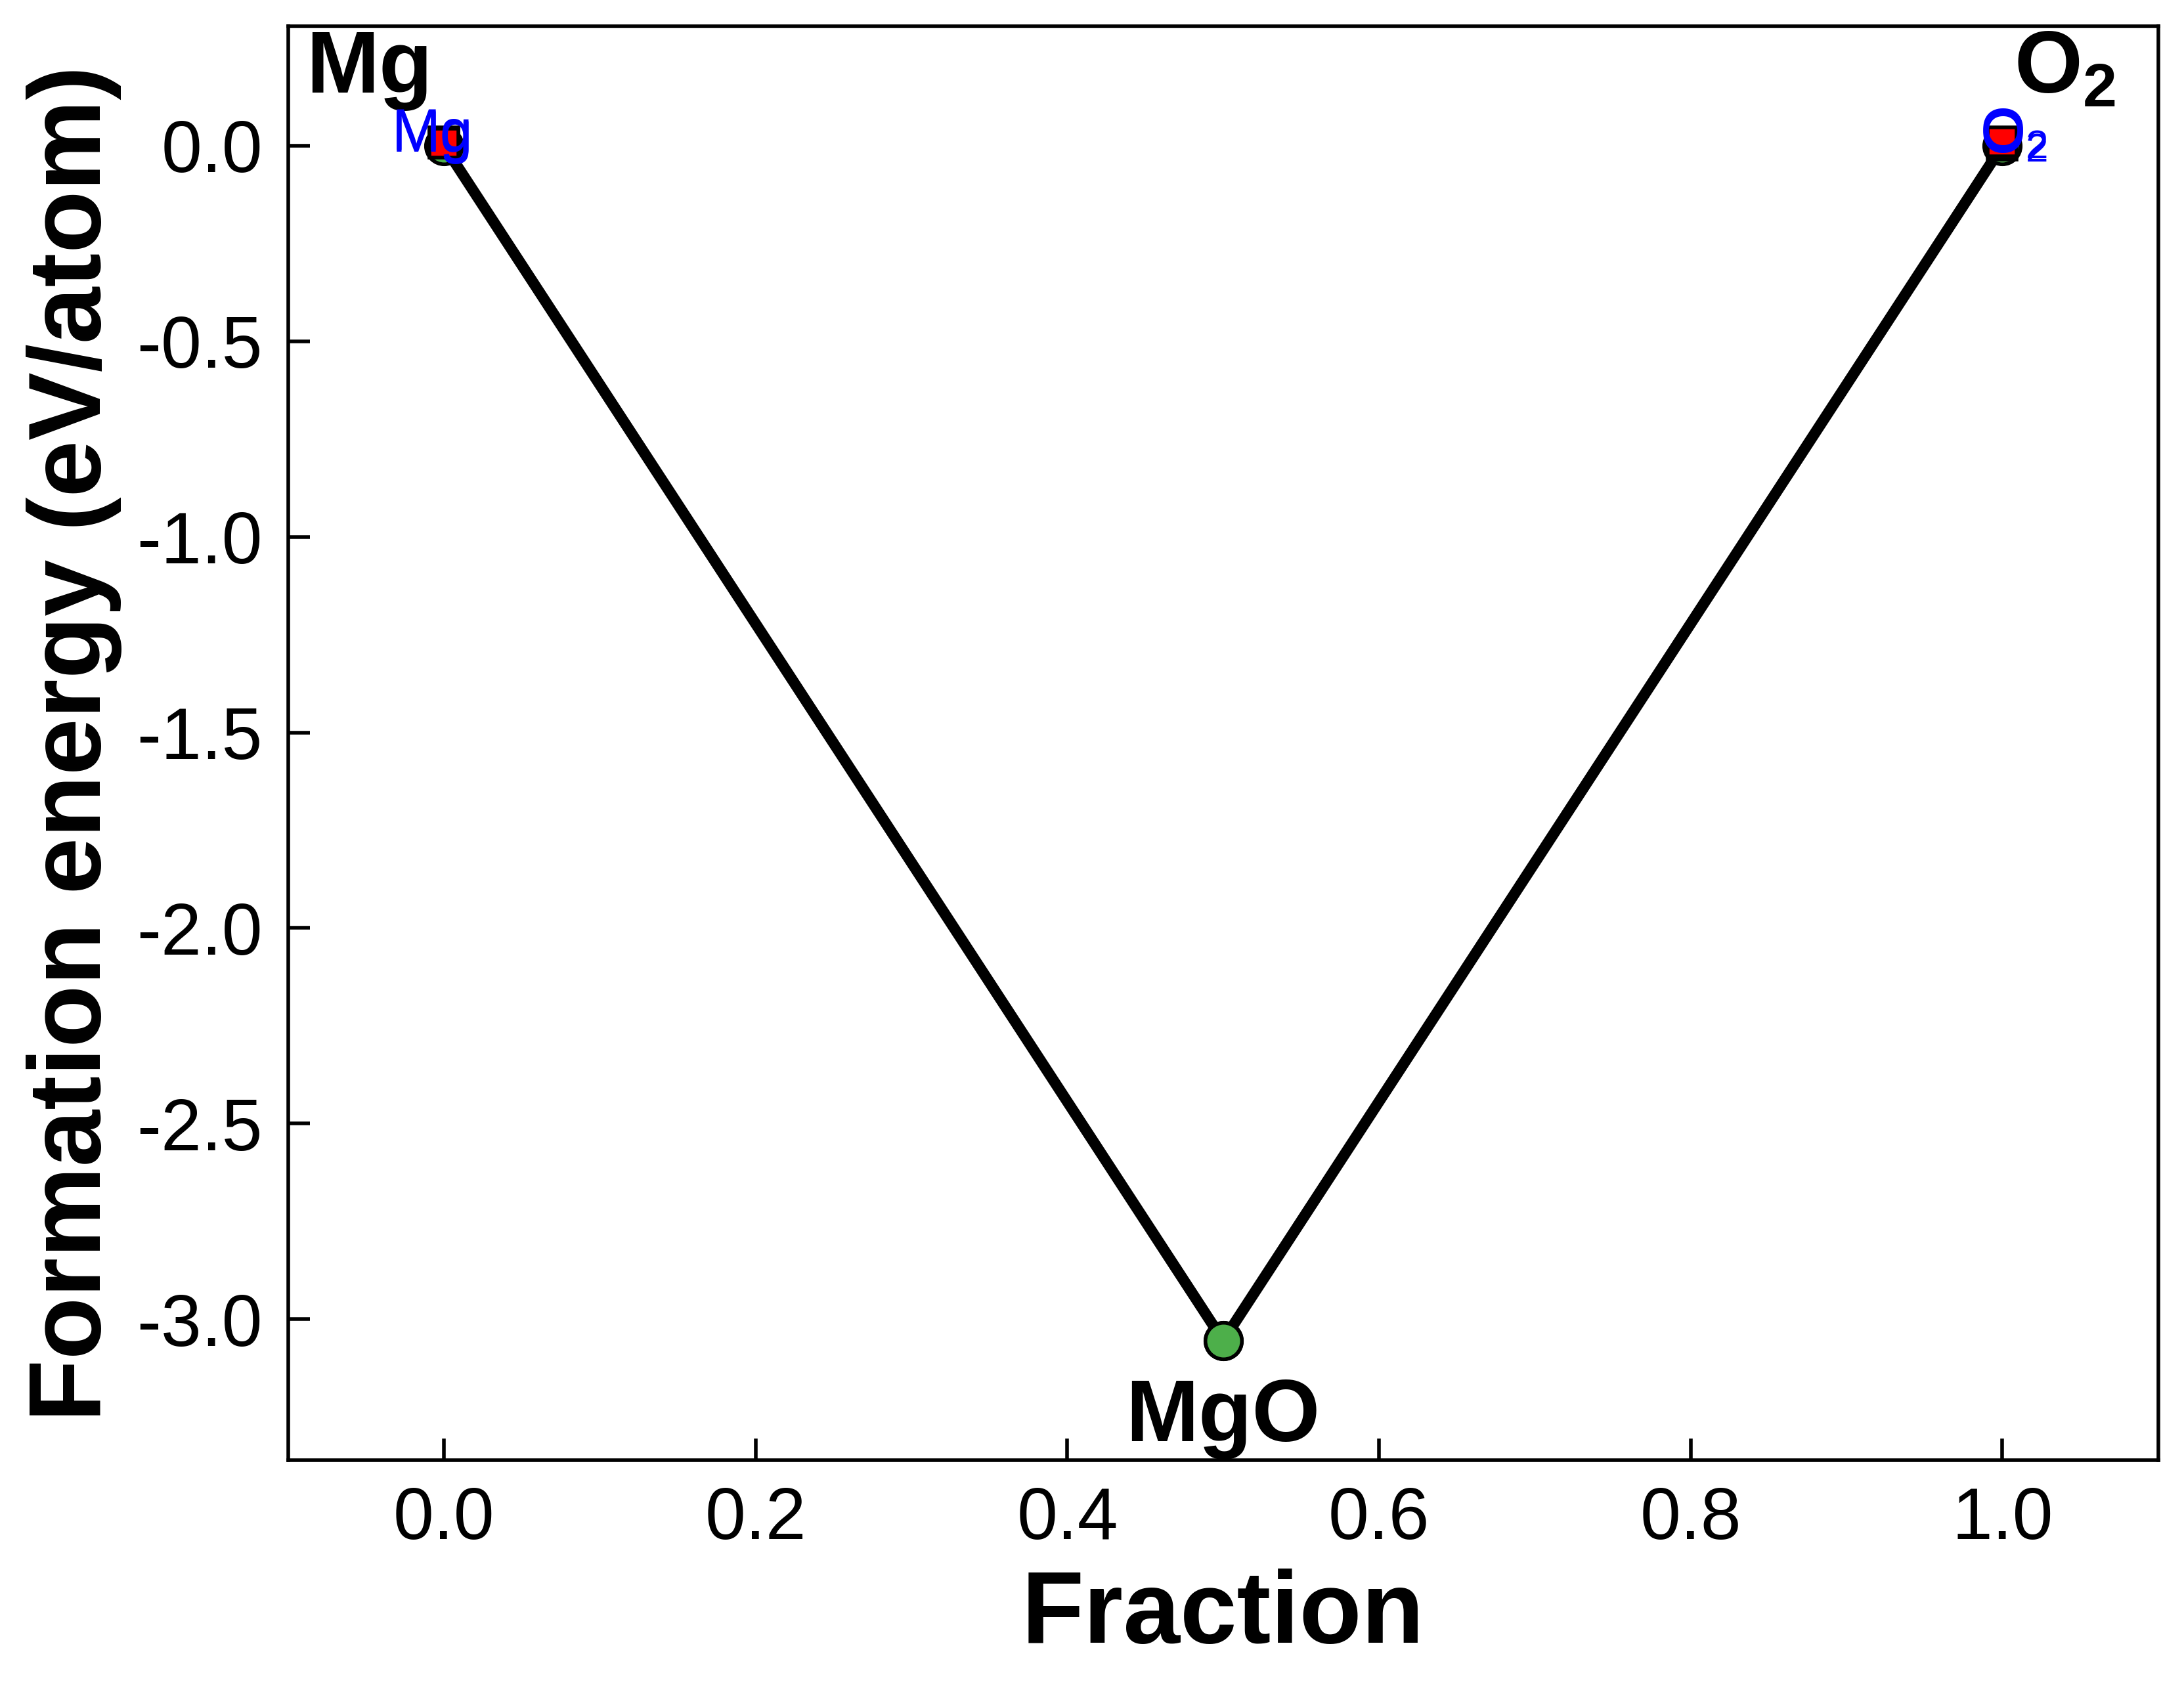

In [18]:
import doped
import matplotlib.pyplot as plt
plt.style.use(f"{doped.__path__[0]}/utils/doped.mplstyle")  # use doped style
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

system = ["Mg", "O"]  # system we want to get phase diagram for
mpr = MPRester()  # object for connecting to MP Rest interface, may need to specify API key here
entries = mpr.get_entries_in_chemsys(system)  # get all entries in the chemical system
pd = PhaseDiagram(entries)  # create phase diagram object
plotter = PDPlotter(pd, show_unstable=e_above_hull, backend="matplotlib")  # plot phase diagram
plotter.get_plot()

Which shows that there are two low-energy polymorphs of Mg on the MP database. 

### 6.1 Generating input files

We can then set up the competing phase calculations with `doped` as described below, or use the `pymatgen` `ComputedStructureEntry` objects in `cp.entries` to set these up in your desired format with `python` / [`atomate`](https://atomate.org/) / [`AiiDA`](https://www.aiida.net/) etc.

k-points convergence testing is done at GGA (PBEsol by default) and is set up to account for magnetic moment convergence as well. Here we interface with [vaspup2.0](https://github.com/kavanase/vaspup2.0) to make it easy to use on the HPCs (with the `generate-converge` command to run the calculations and `data-converge` to quickly parse and analyse the results).

You may want to change the default `ENCUT` (350 eV) or k-point densities that the convergence tests span (5 - 60 kpoints/Å<sup>3</sup> for semiconductors & insulators and 40 - 120 kpoints/Å<sup>3</sup> for metals in steps of 5 kpoints/Å<sup>3</sup>). Note that `ISMEAR = -5` is used for metals by default (better kpoint convergence for energies but should not be used during metal geometry relaxations) and k-point convergence testing is not required for molecules (Γ-point sampling is sufficient).

Note that `doped` generates "molecule in a box" structures for the gaseous elemental phases
H<sub>2</sub>, O<sub>2</sub>, N<sub>2</sub>, F<sub>2</sub> and Cl<sub>2</sub>. The molecule is placed in
 a slightly-symmetry-broken (to avoid metastable electronic solutions) 30 Å cuboid box, and relaxed with Γ-point-only k-point sampling.

The kpoints convergence calculations are set up with:

#### 6.1.1 Convergence calculations

##### Prepare input files

In [23]:
# Update some INCAR settings:
# GGA functional to PBEsol
# NCORE to the correct value for our HPC
# And increase NELM from deafult (60) as metals can take longer to converge
cp.convergence_setup(
    # For custom INCAR settings:
    # any flags that aren't numbers or True/False need to be input as strings with quotation marks:
    user_incar_settings={'GGA': "PS", "LHFCALC": False, "AEXX": 0.0, "HFSCREEN": 0.0, "NCORE": 8, "NELM": 120},
)

O2 is a molecule in a box, does not need convergence testing


In [25]:
!ls competing_phases/Mg_EaH_0.0
!ls competing_phases/Mg_EaH_0.0/kpoint_converge

kpoint_converge
k5,5,5	k6,6,6	k7,7,7


This creates a folder called `competing_phases` with all the relevant competing phases and k-point convergence test calculation directories. The naming format is `<Formula>_EaH_<MP Energy above Hull>` ('EaH' stands for 'Energy above Hull'). These can be quickly run on HPCs using [vaspup2.0](https://github.com/kavanase/vaspup2.0), by creating a `job` file for the HPC scheduler (`vaspup2.0` example [here](https://github.com/kavanase/vaspup2.0/blob/master/input/job)), copying it into each directory and running the calculation with a `bash` loop like:

```bash
for i in *EaH*  # (in the competing_phases directory) – for each competing phase
do cp job $i/kpoint_converge
cd $i/kpoint_converge
for k in k*   # for each kpoint calculation directory
do cp job $k
cd $k
qsub job  # may need to change 'qsub' to 'sbatch' if the HPC scheduler is SLURM
cd ..
done
cd ../..
done
```

Within each competing phase directory in `competing_phases`, the `vaspup2.0` `data-converge` command can be run to quickly parse the results and determine the converged _k_-mesh (see the [vaspup2.0](https://github.com/kavanase/vaspup2.0) homepage for examples).

##### Results

In [78]:
MgO_EaH_0_0="""Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k4,4,4          -12.53218593    -6.2660929
k5,5,5          -12.55608027    -6.2780401        11.9472                   0.0000
k6,6,6          -12.56613572    -6.2830678        5.0277                    0.0000
k7,7,7          -12.55963279    -6.2798163        -3.2515                   0.0000
k8,8,8          -12.56098826    -6.2804941        0.6778                    0.0000
k9,9,9          -12.56017930    -6.2800896        -0.4045                   0.0000"""
Mg_EaH_0_0="""Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k5,5,5          -5.15889639     -1.7196321
k6,6,6          -5.06291012     -1.6876367        -31.7056                  9.9620
k7,7,7          -5.17416496     -1.7247216        36.7951                   -7.6740
k8,8,8          -5.18085534     -1.7269517        2.2301                    -3.1773"""
Mg_EaH_0_0061="""Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k7,7,4          -3.44495771     -1.7224788        1.0233                    0.0000
k8,8,5          -3.45932555     -1.7296627        7.1839                    0.0000
k9,9,5          -3.43738996     -1.7186949        -10.9678                  0.0000
k9,9,6          -3.43344877     -1.7167243        -1.9706                   0.0000
k10,10,6        -3.44291102     -1.7214555"""
Mg_EaH_0_0099="""Directory:     Total Energy/eV: (per atom): Difference (meV/atom): Average Force Difference (meV/Å):
k7,7,2          -6.87041841     -1.7176046        1.3003                    0.0000
k8,8,2          -6.87722253     -1.7193056        1.7010                    0.0000
k9,9,2          -6.85607413     -1.7140185        -5.2871                   0.0000
k9,9,3          -6.84364410     -1.7109110        -3.1075                   0.0000
k10,10,3        -6.86521739     -1.7163043"""

##### Convergence plots

As before, we can use the function `parse_kpoints` to parse the results and plot the convergence:

In [81]:
def parse_kpoints(kpoints, title=None):
    """Function to parse kpoints convergence results from the string produced by vaspup2.0
    and plot them."""
    # Get values from 3rd column into list
    kpoints_energies_per_atom = [float(line.split()[2]) for line in kpoints.split("\n")[1:]]
    # Get encut values from 1st column into list
    data = [line.split() for line in kpoints.split("\n")[1:]]
    kpoints_values = [line[0].split("k")[1].split("_")[-1].split()[0] for line in data]
    # print(kpoints_values)
    #return kpoints_values, kpoints_energies_per_atom
    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(kpoints_values, kpoints_energies_per_atom, marker="o", color="#D4447E")
    # Draw lines +- 5 meV/atom from the last point (our most accurate value)
    for threshold, color in zip([0.005, 0.001], ("#E9A66C", "#5FABA2")):
        ax.hlines(
            y=kpoints_energies_per_atom[-1] + threshold,
            xmin=kpoints_values[0],
            xmax=kpoints_values[-1],
            color=color,
            linestyles="dashed",
            label=f"{1000*threshold} meV/atom"
        )
        ax.hlines(
            y=kpoints_energies_per_atom[-1] - threshold,
            xmin=kpoints_values[0],
            xmax=kpoints_values[-1],
            color=color,
            linestyles="dashed",
        )
        # Fill the area between the lines
        ax.fill_between(
            kpoints_values,
            kpoints_energies_per_atom[-1] - threshold,
            kpoints_energies_per_atom[-1] + threshold,
            color=color,
            alpha=0.08,
        )
    # Add axis labels
    ax.set_xlabel("KPOINTS")
    ax.set_ylabel("Energy per atom (eV)")
    # Rotate xticks
    ax.set_xticklabels(kpoints_values, rotation=90)
    ax.legend(frameon=True)
    if title:
        ax.set_title(title)
    return fig

MgO:

4157755065.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


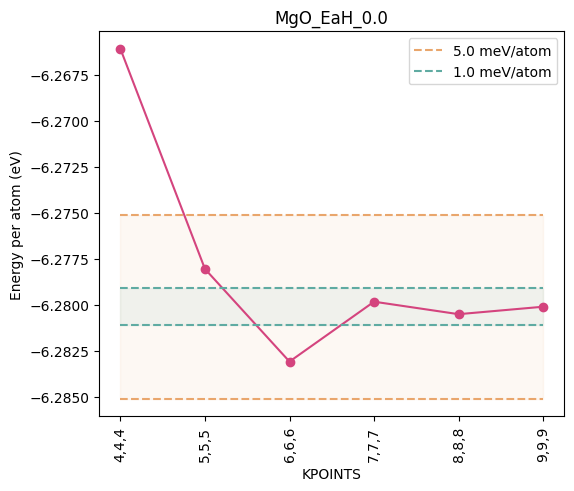

In [82]:
fig = parse_kpoints(MgO_EaH_0_0, title="MgO_EaH_0.0")

`Mg_EaH_0.0`:

4157755065.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


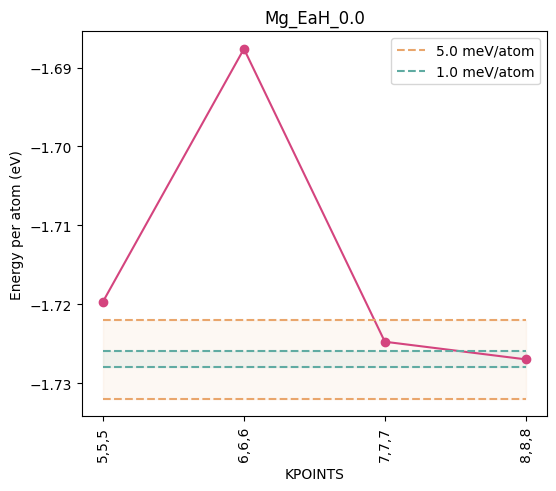

In [83]:
fig = parse_kpoints(Mg_EaH_0_0, title="Mg_EaH_0.0")

`Mg_EaH_0.0061`:

4157755065.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


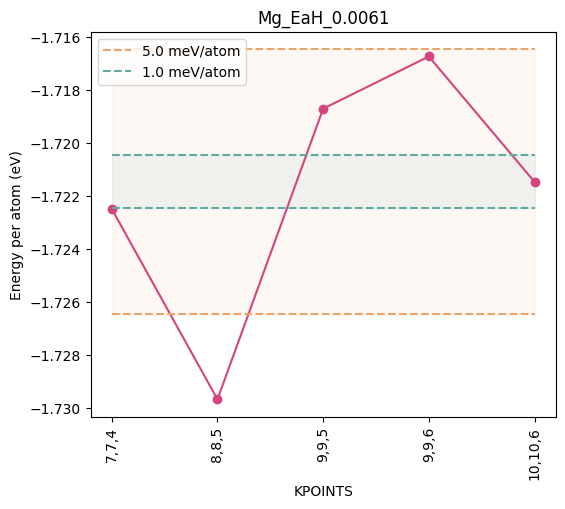

In [84]:
fig = parse_kpoints(Mg_EaH_0_0061, title="Mg_EaH_0.0061")

`Mg_EaH_0.0099`:

4157755065.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


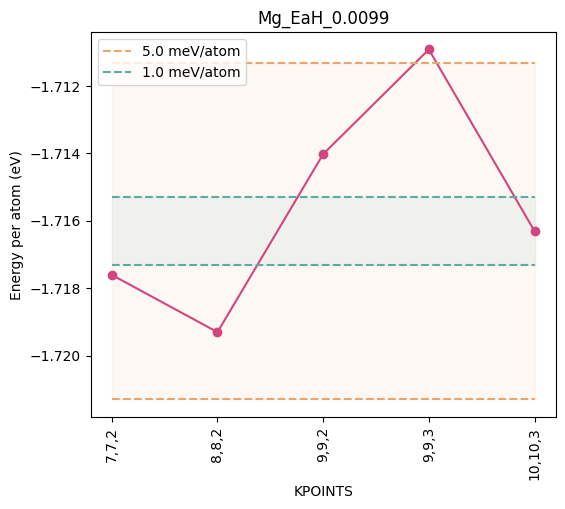

In [85]:
fig = parse_kpoints(Mg_EaH_0_0099, title="Mg_EaH_0.0099")

So the converged values are:
* MgO: `k8x8x8` (used before)
* Mg_EaH_0.0: `k7x7x7` 
* Mg_EaH_0.0061: `k9x9x5`
* Mg_EaH_0.0099: `k7x7x2`

#### 6.1.2 Relaxations of competing phases

Next, you want to relax each competing phase with the converged k-point mesh, and calculate the energy with the same DFT functional and settings as your defect supercell calculations. `doped` can generate these folders for the relaxations of the competing phases.

The _k_-point meshes are Γ-centred (as opposed to Monkhorst-Pack) by default. By default `doped` will
make the inputs assuming a HSE06 `INCAR` (see [`HSESet.yaml`](https://github.com/SMTG-Bham/doped/tree/main/doped/VASP_sets/HSESet.yaml) for default values) and kpoint densities of 95 kpoints/Å<sup>3</sup> for metals and 45 kpoints/Å<sup>3</sup> for semiconductors.   
Since in this qualitative tutorial we're using `PBEsol`, we'll update the `INCAR` settings to use this functional.
In addition, you should change the `KPOINTS` file to match the converged mesh in each case, however the default densities are good starting points. `doped` will automatically set `SIGMA` and `ISMEAR` accordingly depending on whether the phase is a semiconductor or metal, and will set `NUPDOWN` appropriately for molecules (i.e. O<sub>2</sub> has triplet spin). 

These relaxations can be set up with:

In [71]:
user_incar_settings = {
    "ENCUT": 1.3*450, # converged value for bulk MgO multiplied by 1.3 to account for Pulay stress during volume relaxation
    "GGA": "PS", # PBEsol
    "LHFCALC": False, # no hybrid functional
    "AEXX": 0.0, # no hybrid functional
    "HFSCREEN": 0.0, # no hybrid functional
    "NCORE": 8, # Update to the correct value for your HPC!
    "NELM": 120, # Increase NELM for metals
}
cp.vasp_std_setup(
    user_incar_settings=user_incar_settings
)

Update the `KPOINTS` file to match the converged mesh in each case:

In [72]:
from pymatgen.io.vasp.inputs import Kpoints

converged_values = {"MgO_EaH_0.0": (8,8,8), "Mg_EaH_0.0": (7,7,7), "Mg_EaH_0.0061": (9,9,5), "Mg_EaH_0.0099": (7,7,2)}

for k, v in converged_values.items():
    # Update KPOINTS
    path = f"competing_phases/{k}/vasp_std/KPOINTS"
    # Read KPOINTS
    kpoints = Kpoints(kpts=(v,))
    # Write file to path
    kpoints.write_file(path)

Remember that the final `ENCUT` used for the energy calculations should be the same as for your host
material & defects. To ensure this, after relaxing with `1.3*ENCUT`, we resubmit a final quick relaxation with `ENCUT`.

### 6.2 Parse Competing Phases

#### 6.2.1 Read in data from `vasprun.xml` files

Once you've calculated your competing phases, you will want to parse the results to determine the chemical potential limits of your host material. To do this, we need to parse the `vasprun.xml` files from your final
production-run competing phase calculations. To download the `vasprun.xml` files from the HPCs recursively, you can recursively `rsync`:

```bash 
rsync -azvuR hpc:'path/to/the/base/folder/competing_phases/./*_EaH_*/vasp_std/vasprun.xml*' .
```

where the `/./` indicates where you'd like to start the recurse from, so you only keep the folder structure from the `formula_EaH_*` point onwards. If you've done spin-orbit coupling (SOC) calculations with results in `vasp_ncl` folders, then you need to change `vasp_std` to `vasp_ncl` above, or to whatever name you've given the production-run folders. Note that you can compress the `vasprun.xml` files to save space (with e.g. `find . -name vasprun.xml -exec gzip {} \;`) and these will still be parsed fine by `doped`.

All analysis is performed with the `CompetingPhasesAnalyzer` class, and all you need to supply it is the formula of your host system and the path to the base folder in which you have all your `formula_EaH_*/vasp_std/vasprun.xml(.gz)` files.

If you did not generate your competing phases with `doped`, you can still parse them with `doped` by providing a list of paths to the `vasprun.xml(.gz)` files using `pathlib` or `os`, as shown below.

In [89]:
from doped.chemical_potentials import CompetingPhasesAnalyzer
cpa = CompetingPhasesAnalyzer("MgO")

In [90]:
# in this case we have our competing phases in the MgO subfolder of the competing_phases folder,
# with 'vasp_std' subfolders in each <formula>_EaH_<energy above hull> folder
cpa.from_vaspruns(path='./competing_phases/MgO/',
                  folder='vasp_std')

chemical_potentials.py:1198: UserWarning: Multiple `vasprun.xml` files found in directory: competing_phases/MgO/MgO_EaH_0.0/vasp_std. Using competing_phases/MgO/MgO_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.
chemical_potentials.py:1198: UserWarning: Multiple `vasprun.xml` files found in directory: competing_phases/MgO/Mg_EaH_0.0/vasp_std. Using competing_phases/MgO/Mg_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.
chemical_potentials.py:1198: UserWarning: Multiple `vasprun.xml` files found in directory: competing_phases/MgO/Mg_EaH_0.0061/vasp_std. Using competing_phases/MgO/Mg_EaH_0.0061/vasp_std/vasprun.xml to parse the calculation energy and metadata.
chemical_potentials.py:1198: UserWarning: Multiple `vasprun.xml` files found in directory: competing_phases/MgO/O2_EaH_0.0/vasp_std. Using competing_phases/MgO/O2_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.


Parsing 5 vaspruns and pruning to include only lowest-energy polymorphs...


If we want to save the parsed formation energies to a csv file, we can do so by providing a filename to the `csv_path` argument:

In [4]:
cpa.from_vaspruns(path='./competing_phases/MgO/',
                  folder='vasp_std',
                  csv_path='competing_phases/mgo_competing_phase_energies.csv')

Multiple `vasprun.xml` files found in directory: competing_phases/MgO/MgO_EaH_0.0/vasp_std. Using competing_phases/MgO/MgO_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.
Multiple `vasprun.xml` files found in directory: competing_phases/MgO/Mg_EaH_0.0/vasp_std. Using competing_phases/MgO/Mg_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.
Multiple `vasprun.xml` files found in directory: competing_phases/MgO/Mg_EaH_0.0061/vasp_std. Using competing_phases/MgO/Mg_EaH_0.0061/vasp_std/vasprun.xml to parse the calculation energy and metadata.
Multiple `vasprun.xml` files found in directory: competing_phases/MgO/O2_EaH_0.0/vasp_std. Using competing_phases/MgO/O2_EaH_0.0/vasp_std/vasprun.xml to parse the calculation energy and metadata.


Parsing 5 vaspruns and pruning to include only lowest-energy polymorphs...
Competing phase formation energies have been saved to competing_phases/mgo_competing_phase_energies.csv.


### 6.3 Calculate the Chemical Potential Limits

We can then calculate the chemical potential limits for our host material using the `cpa.calculate_chempots()` method. This will print out the chemical potential limits for each element in the host material, and also return a `pandas` dataframe containing the chemical potential limits for each element in the host material.

In [91]:
df =  cpa.calculate_chempots()

Calculated chemical potential limits: 

        Mg        O
0  0.00000 -5.64572
1 -5.64572  0.00000


In [92]:
df = cpa.calculate_chempots(csv_path='competing_phases/mgo_chempots.csv')

Saved chemical potential limits to csv file:  competing_phases/mgo_chempots.csv
Calculated chemical potential limits: 

        Mg        O
0  0.00000 -5.64572
1 -5.64572  0.00000


To use these parsed chemical potential limits for computing the defect formation energies with `doped` (e.g. in `plotting.formation_energy_plot()`, `analysis.formation_energy_table()` etc.) we can use the `cpa.chempots` attribute, which is a dictionary of the chemical potential limits for each element in the host material:

In [93]:
cpa.chempots

{'limits': {'MgO-Mg': {'Mg': -1.7360624375, 'O': -10.7807654025},
  'MgO-O2': {'Mg': -7.38178196, 'O': -5.13504588}},
 'elemental_refs': {'O': -5.13504588, 'Mg': -1.7360624375},
 'limits_wrt_el_refs': {'MgO-Mg': {'Mg': 0.0, 'O': -5.6457195225},
  'MgO-O2': {'Mg': -5.645719522499999, 'O': 0.0}}}

If you want to save it to use at a later date / in a different notebook/environment without having to re-parse your results, you can dump it to a `json` file with `dumpfn` and then load it again with `loadfn`:

In [94]:
from monty.serialization import dumpfn, loadfn

dumpfn(cpa.chempots, 'competing_phases/mgo_chempots.json')
mgo_chempots = loadfn('competing_phases/mgo_chempots.json')

#### 6.3.1 Analyse and visualise the Chemical Potential Limits

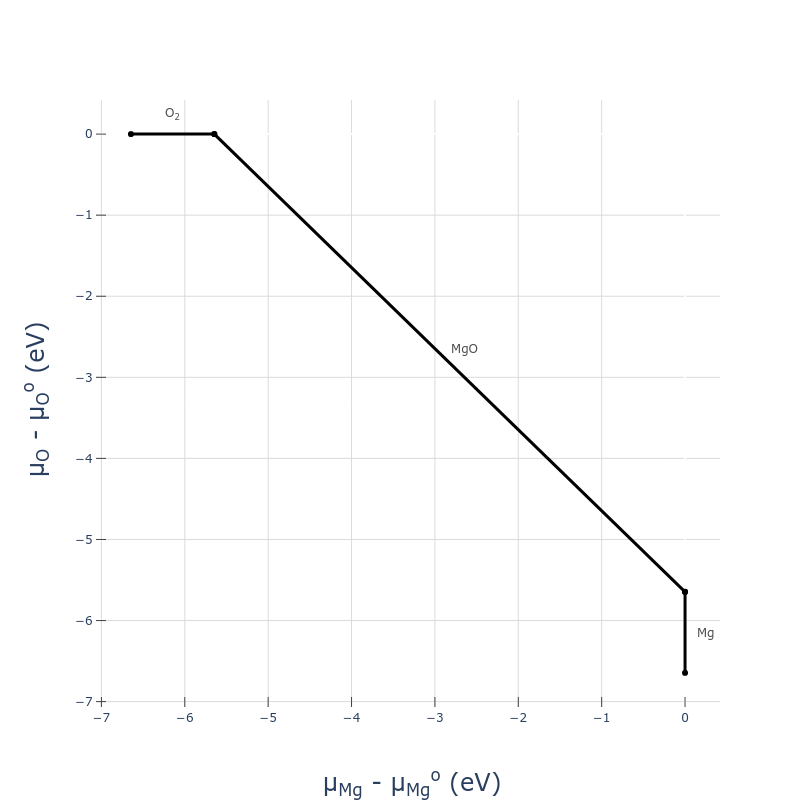

In [95]:
from pymatgen.analysis.chempot_diagram import ChemicalPotentialDiagram

cpd = ChemicalPotentialDiagram(cpa.intrinsic_phase_diagram.entries)
plot = cpd.get_plot()
plot.show("png", dpi=600)

If the previous cell crashes with the error
```
ValueError: 
Image export using the "kaleido" engine requires the kaleido package,which can be installed using pip:
    $ pip install -U kaleido
```
Then uncomment the following cell and run it to install `kaleido`:

In [22]:
# ! pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.4 MB/s eta 0:00:0000:0100:01m


 Because `cpd.get_plot()` returns a `plotly` object, it's almost infinitely customisable using `plot.update_scenes()` - you can change colours, fonts, axes and even data after it's been plotted. See the [docs](https://plotly.com/python/) for more info.

Beware that because we only generated the relevant competing phases on the `Mg-O` phase diagram for our MgO host material, we have not calculated _all_ phase in the `Mg-O` chemical space (just those that are necessary to determine the chemical potential limits of MgO), and so these chemical potential diagram plots are only accurate in the vicinity of our host material.

<a id='dielectric'></a>
## 7. Dielectric constant

For single-crystal semiconductors, the response to a static electric field can be decomposed into two components:

$\epsilon_{0} = \epsilon_{ionic} + \epsilon_{infinity}$

where $\epsilon_{ionic}$ is often called the low-frequency or ionic dielectric constant and $\epsilon_{infinity}$ the high frequency or optical dielectric constant. 

We'll calculate both contributions below.

```{important}
The calculated value for the ionic contribution to the static dielectric constant ($\epsilon_{ionic}$) is quite sensitive to both the plane wave kinetic energy cutoff `ENCUT` and the k-point density, with more expensive parameter values necessary (relative to ground-state-energy-converged values) due to the requirement of accurate ionic forces. Thus, this calculation should be accompanied with convergence tests with respect to these parameters.

In addition, the calculation of the optical dielectric constant ($\epsilon_{optical}$) is sensitive to the number of electronic bands included in the calculation (`NBANDS`), and often requires a high value for [convergence](https://github.com/kavanase/vaspup2.0#optical-dielectric-constant-convergence). 

We can quickly perform these convergence tests with [`vaspup2.0`](https://github.com/kavanase/vaspup2.0), as shown below. 
```

### 7.1 Optical contribution ($\epsilon_{optical}$)

The optical contribution results from the refraction of electromagnetic waves with frequencies **high** compared to lattice vibrations (phonons). We can calculate the optical dielectric functions and take the value of the real component at `E = 0 eV`.

```{important}
Typically, we perform the convergence test of `$\epsilon_{optical}$` with respect to the number of bands (`NBANDS`) using a GGA functional like `PBEsol`, and use the converged `NBANDS` to recalculate `$\epsilon_{optical}$` with a hybrid functional, as explained [here](https://github.com/kavanase/vaspup2.0#note). 

In this tutorial, we're using `PBEsol` so we'll just use the value from the convergence test below. But remember that in a typical study, you'd then use the converged `NBANDS` value for the hybrid functional calculation!
```

#### 7.1.1 Convergence of `NBANDS` for $\epsilon_{optical}$

##### Generate input files

We first generate the input files for the convergence tests and save them to a folder called `Dielectric/Bulk_optical/Convergence/input`:

In [8]:
import os

# Create directory for optical and convergence calcs
os.makedirs("MgO/Dielectric/Optical/Convergence/input", exist_ok=True)

In [50]:
#  Copy input files from bulk relaxation directory
import shutil
from pymatgen.core.structure import Structure

if not os.path.exists("./MgO/Bulk_relax/CONTCAR"):
    print("Please run the bulk relaxation first!")
else:
    shutil.copy("./MgO/Bulk_relax/CONTCAR", "./MgO/Dielectric/Optical/Convergence/input/POSCAR")

# Copy KPOINTS, POTCAR and INCAR
shutil.copy("./MgO/Bulk_relax/KPOINTS", "./MgO/Dielectric/Optical/Convergence/input/KPOINTS")
shutil.copy("./MgO/Bulk_relax/POTCAR", "./MgO/Dielectric/Optical/Convergence/input/POTCAR")

'./MgO/Dielectric/Optical/Convergence/input/POTCAR'

In [22]:
# INCAR for optical convergence
from pymatgen.io.vasp.inputs import Incar
incar = Incar.from_dict(
    {
        # System-dependent parameters
        "ENCUT": 450, # Converged value for your material
        # Optical parameters:
        'LOPTICS': True,
        'CSHIFT': 1e-06,
        'NBANDS': 120,
        'ISMEAR': -5, # Tetrahedron method
        'SIGMA': 0.05, # Smearing
        'NEDOS': 2000,
        'ALGO': 'Normal',
        'ISPIN': 2,
        'LORBIT': 11,
        'LREAL': False,
        # Electronic convergence (tight):
        'EDIFF': 1e-07,
        'NELM': 100,
        # Functional:
        'GGA': 'Ps', # For converging NBANDS we use PBEsol
        'PREC': 'Accurate',
        # Parallelisation:
        'KPAR': 2,
        'NCORE': 6,
    }
)
# Save to file
incar.write_file("./MgO/Dielectric/Optical/Convergence/input/INCAR")

To use `vaspup2.0`, we need to use a `CONFIG` file like the one below. Here we need to decide on the range on `NBANDS` to test. Typically, we our minimum value should be the number of valence electrons in the structure and go up to that ~number+200

In [52]:
# Number of valence electrons in our system
from pymatgen.io.vasp.inputs import Potcar
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element

potcar = Potcar.from_file("./MgO/Bulk_relax/POTCAR")
prim_struc = Structure.from_file("./MgO/Bulk_relax/CONTCAR")
d = prim_struc.composition.as_dict()
d_Z_to_num_atoms = {Element(e).Z: v for e, v in d.items()} # Map atomic number to number of atoms of that element in structure
# Get number of valence electrons in structure
n_elec = 0
for potcar_single in potcar:
    n_elec += potcar_single.nelectrons * d_Z_to_num_atoms[potcar_single.atomic_no] # number of electrons in potcar * number of atoms of that element in structure
print(f"Number of valence electrons: {n_elec}")

Number of valence electrons: 8.0


In [53]:
nbands_start = n_elec
nbands_end = nbands_start + 200
print(f"Start nbands: {nbands_start}. End nbands: {nbands_end}")

Start nbands: 8.0. End nbands: 208.0


In [54]:
config_file = f"""# vaspup2.0 - Seán Kavanagh (sean.kavanagh.19@ucl.ac.uk), 2023
# This is config for automating NBANDS convergence.
# (For LOPTICS calculation)(High-frequency dielectric constant)

conv_nbands="1"		# 1 for ON, 0 for OFF
nbands_start="{int(nbands_start)}"	# Value to start NBANDS calcs from
# Need to include NBANDS flag in INCAR
nbands_end="{int(nbands_end)}"		# Value to end NBANDS calcs on
nbands_step="20"		# NBANDS increment

run_vasp="1"		# Run VASP after generating the files? (1 for ON, 0 for OFF)
#name="Optical" # Optional name to append to each jobname (remove "#")
"""
# Save it to input
with open("./MgO/Dielectric/Optical/Convergence/input/CONFIG", "w") as f:
    f.write(config_file)

We transfer the `input` folder to the HPC and run the convergence tests with `vaspup2.0` by running the command `nbands-generate-converge` from the directory **above** the input directory.

After the calculations finished, we can parse the results by executing the command `nbands-epsopt-data-converge` from the `nbands_converge` directory, which outputs:

##### Results

In [22]:
# Output from vaspup2.0 nbands-converge
optical_conv = """
Directory:                   Epsilon_Opt X,Y,Z:                     Difference EpsOpt X,Y,Z:
nbands8         2.033336        2.033336        2.033336
nbands28        2.097091        2.097091        2.097091        0.0701           0.0701          0.0701
nbands48        2.100513        2.100513        2.100513        -0.0034          -0.0034         -0.0034
nbands68        2.103436        2.103436        2.103436        -0.0029          -0.0029         -0.0029
nbands88        2.101419        2.101419        2.101419        -0.0681          -0.0681         -0.0681
nbands_108      2.102865        2.102865        2.102865        -0.0014          -0.0014         -0.0014
nbands_128      2.102674        2.102674        2.102674        0.0002           0.0002          0.0002
nbands_148      2.103785        2.103785        2.103785        -0.0011          -0.0011         -0.0011
nbands_168      2.104084        2.104084        2.104084        -0.0003          -0.0003         -0.0003
nbands_188      2.102393        2.102393        2.102393        0.0017           0.0017          0.0017
nbands_208      2.103104        2.103104        2.103104        -0.0007          -0.0007         -0.0007
"""

We can plot it to see the convergence:

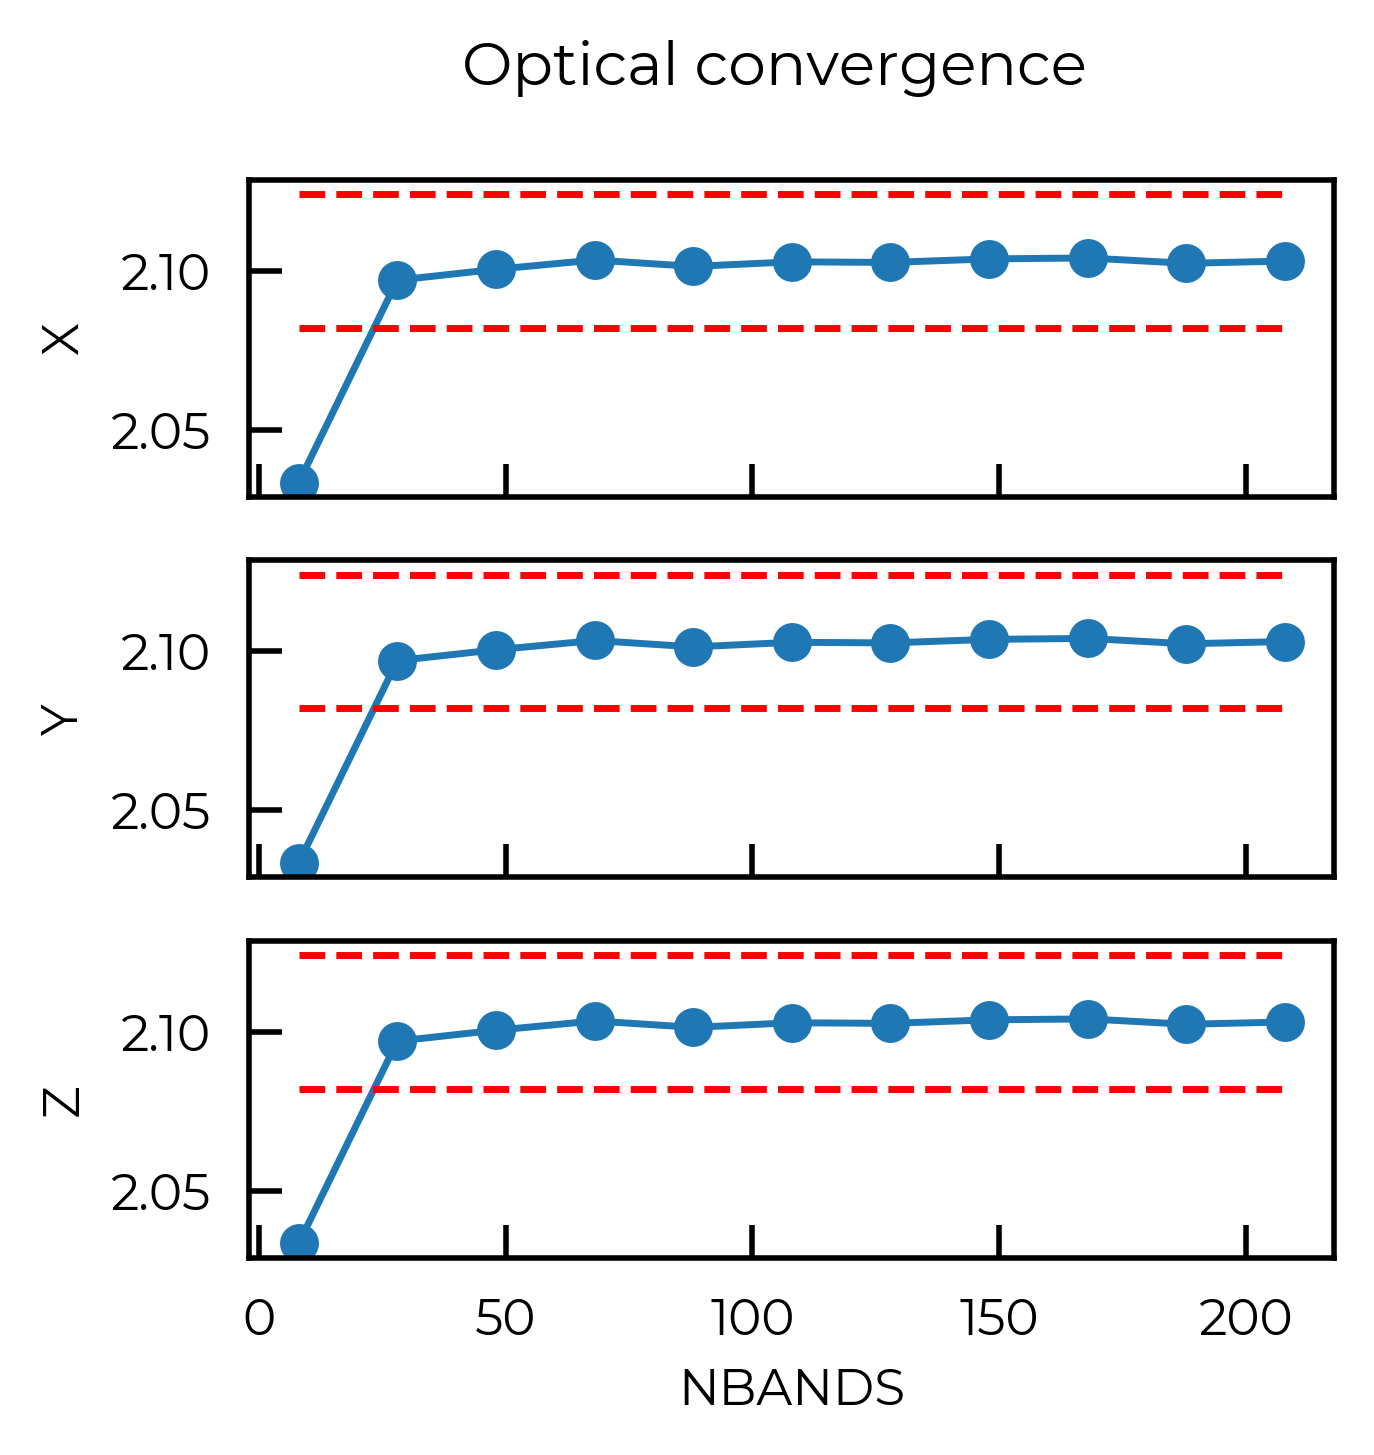

In [23]:
# Parse x,y,z values from optical convergence
optical_conv = optical_conv.split("\n")[1:]
optical_conv = [line.split() for line in optical_conv][1:-1]
nbands = [int(line[0].split("nbands")[1].split("_")[-1]) for line in optical_conv]
optical_conv = [line[1:4] for line in optical_conv]
# print(optical_conv)
# Plot x,y,z values in different subplots
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Optical convergence')
axs[0].plot(nbands, [float(line[0]) for line in optical_conv], marker="o")
axs[0].set_ylabel("X")
axs[1].plot(nbands, [float(line[1]) for line in optical_conv], marker="o")
axs[1].set_ylabel("Y")
axs[2].plot(nbands, [float(line[2]) for line in optical_conv], marker="o")
axs[2].set_ylabel("Z")
axs[2].set_xlabel("NBANDS")
# Horizontal lines +-1% of last value
for i in range(3):
    axs[i].hlines(
        y=1.01 * float(optical_conv[-1][i]),
        xmin=nbands[0],
        xmax=nbands[-1],
        color="red",
        linestyles="dashed",
    )
    axs[i].hlines(
        y=0.99 * float(optical_conv[-1][i]),
        xmin=nbands[0],
        xmax=nbands[-1],
        color="red",
        linestyles="dashed",
    )

Which shows that with `NBANDS = 28` (second point in the plot), `$\epsilon_{optical}$` is within 1% of the converged value.

In [24]:
# Values for nbands = 28
index = nbands.index(28)
# Values of epsilon_opt for nbands = 28
epsilon_optical_converged = [float(line) for line in optical_conv[index]]
print(f"Converged Epsilon_optical: {epsilon_optical_converged}")

Converged Epsilon_optical: [2.097091, 2.097091, 2.097091]


```{tip}
Note that in a proper defect study, you'd know recompute `$\epsilon_{optical}$` with a hybrid functional (e.g. `HSE06`), using the converged `NBANDS` value from the (`PBEsol`) convergence test above.  
This is important, since this calculation is very sensitive to the band gap. Since LDA/GGA typically underestimates the band gap, the resulting dielectric constant is overestimated. 

You could set the input for that calculation it with the following (commented) cell:
```

### 7.2 Ionic contribution ($\epsilon_{ionic}$)

To calculate the low-frequency behaviour, we need to compute the response of the lattice vibrations (phonons) to an applied electric field.

```{important}
Typically, $\epsilon_{ionic}$ is calculated with `PBEsol`, since this functional is accurate for phonons (and thus $\epsilon_{ionic}$). 
Accordingly, in a typical defect stude we use a hybrid functional (e.g. `HSE06`) for our bulk/defect calculations and for $\epsilon_{optical}$, and `PBEsol` for $\epsilon_{ionic}$, e.g.:

$ \epsilon_0 = \epsilon_{optical}$ (from hybrid optics calc) $+ \epsilon_{ionic}$ (from PBEsol DFPT)

But remember that if you're changing functional (e.g. if you've used `HSE06` to relax your bulk structure and now you'll use `PBEsol` to calculate $\epsilon_{ionic}$), you first have to re-relax the bulk structure again with `PBEsol` before calculating $\epsilon_{ionic}$ with `PBEsol`! 
```

```{note}
In addition, note that the calculation of `$\epsilon_{ionic}$` is very sensitive to the input geometry, and requires a well converged relaxed structure. Otherwise, negative phonon modes can give unreasonably large values of the ionic response. Thus, we'll perform a very tight relaxation of our primitive structure (e.g. `EDIFFG = -1E-6` and `EDIFF = 1E-8`).
```

#### 7.2.1 Tight relaxation

In [35]:
#  Copy input files from bulk relaxation directory
import shutil
from pymatgen.core.structure import Structure
import os

# Create directory
os.makedirs("MgO/Dielectric/Ionic/Relax_tight", exist_ok=True)

if not os.path.exists("./MgO/Bulk_relax/CONTCAR"):
    print("Please run the bulk relaxation first!")
else:
    shutil.copy("./MgO/Bulk_relax/CONTCAR", "./MgO/Dielectric/Ionic/Relax_tight/POSCAR")

# Copy KPOINTS, POTCAR and INCAR
shutil.copy("./MgO/Bulk_relax/KPOINTS", "./MgO/Dielectric/Ionic/Relax_tight/KPOINTS")
shutil.copy("./MgO/Bulk_relax/POTCAR", "./MgO/Dielectric/Ionic/Relax_tight/POTCAR")

'./MgO/Dielectric/Ionic/Relax_tight/POTCAR'

In [36]:
incar = Incar.from_file("./MgO/Input_files/INCAR_bulk_relax")
incar.update(
    {
        "ENCUT": 450 * 1.3, # Increase ENCUT by 30% because we're relaxing volume (Pulay stress)
        # Paralelisation
        "KPAR": 2,
        "NCORE": 8, # Might need updating for your HPC!
        # Functional
        "GGA": "PS",
        # Relaxation
        "IBRION": 2,
        "ISIF": 3, # Relax cell
        "NSW": 800, # Max number of steps
        # Accuracy and thresholds
        "ISYM": 2, # Symmetry on
        "PREC": "Accurate",
        "EDIFF": 1e-8, # Tight electronic convergence
        "EDIFFG": -1e-4, # Tight ionic convergence
        "ALGO": "Normal",
        "LREAL": "False",
    }
)
incar
# Save to file
incar.write_file("./MgO/Dielectric/Ionic/Relax_tight/INCAR")

After the relaxation finished, we copy the `CONTCAR` from the HPC to the current directory and parse it with `pymatgen`:

If we also transfer the `vasprun.xml` file we can check the relaxation is converged like:

In [42]:
import os

if os.path.exists("./MgO/Dielectric/Ionic/Relax_tight/CONTCAR"):
    prim_struc_tight = Structure.from_file("./MgO/Dielectric/Ionic/Relax_tight/CONTCAR")
else:
    print(f"Perform the relaxation first!")

In [44]:
from pymatgen.io.vasp.outputs import Vasprun

# Can check if relaxation is converged by parsing the vasprun.xml
if os.path.exists("MgO/Dielectric/Ionic/Relax_tight/vasprun.xml"):
    vr = Vasprun("MgO/Dielectric/Ionic/Relax_tight/vasprun.xml")
    print(f"Relaxation converged?", vr.converged)
else:
    print(f"No vasprun.xml found!")

Relaxation converged? True


#### 7.2.2 Convergence of `ENCUT` and kpoints for $\epsilon_{ionic}$

##### Generate input files

In [45]:
import os

# Create directory for optical and convergence calcs
os.makedirs("MgO/Dielectric/Ionic/Convergence/input", exist_ok=True)

In [46]:
#  Copy input files from bulk relaxation directory
import shutil
from pymatgen.core.structure import Structure

if not os.path.exists("./MgO/Dielectric/Ionic/Relax_tight/CONTCAR"):
    print("Please run the tight bulk relaxation first!")
else:
    shutil.copy("./MgO/Dielectric/Ionic/Relax_tight/CONTCAR", "./MgO/Dielectric/Ionic/Convergence/input/POSCAR")

# Copy KPOINTS, POTCAR and INCAR
shutil.copy("./MgO/Bulk_relax/KPOINTS", "./MgO/Dielectric/Ionic/Convergence/input/KPOINTS")
shutil.copy("./MgO/Bulk_relax/POTCAR", "./MgO/Dielectric/Ionic/Convergence/input/POTCAR")

'./MgO/Dielectric/Ionic/Convergence/input/POTCAR'

In [47]:
# INCAR for optical convergence
from pymatgen.io.vasp.inputs import Incar
incar = Incar.from_dict(
    {
        # System-dependent parameters
        "ENCUT": 450, # Converged value for your material
        # Parameters to calculated ionic dielectric constant:
        'LEPSILON': True, # DFPT Calculation
        'IBRION': 8, # Phonons
        'ISYM': -1, # Symmetry off (if using NCORE)
        'EDIFFG': -0.003,
        'ISIF': 2, # Keep cell volume fixed for DFPT calcs
        'NSW': 1,
        'LWAVE': True,
        # Electronic convergence:
        'EDIFF': 1e-07,
        'ALGO': 'Normal',
        'NELM': 100,
        'ISMEAR': 0, # Gaussian smearing
        'SIGMA': 0.05,
        'NEDOS': 2000,
        'ISPIN': 1, # off for non-magnetic systems
        # Others:
        'LREAL': False,
        'LORBIT': 11,
        'LASPH': True,
        # Functional:
        'GGA': 'Ps',
        'PREC': 'Accurate',
        # Parallelisation:
        'KPAR': 2,
        'NCORE': 8,
    }
)
# Save to file
incar.write_file("./MgO/Dielectric/Ionic/Convergence/input/INCAR")

And finally we set the kpoint meshes that we'll try in the `CONFIG` file. We can get a list of of kpoint grids for our system by using the `kgrid` package (which can be installed by running `pip install kgrid`):

In [9]:
from kgrid.series import cutoff_series
from kgrid import calc_kpt_tuple
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor

def generate_kgrids_cutoffs(
    structure: Structure,
    kmin: int = 4,
    kmax: int = 20,
) -> list:
    """Generate a series of kgrids for your lattice between a real-space cutoff range of `kmin` and `kmax` (in A).
    For semiconductors, the default values (kmin: 4; kmax: 20) are generally good.
    For metals you might consider increasing a bit the cutoff (kmax~30).
    Returns a list of kmeshes.
    Args:
        atoms (ase.atoms.Atoms): _description_
        kmin (int, optional): _description_. Defaults to 4.
        kmax (int, optional): _description_. Defaults to 20.

    Returns:
        list: list of kgrids
    """
    # Transform struct to atoms
    aaa = AseAtomsAdaptor()
    atoms = aaa.get_atoms(structure=structure)
    # Calculate kgrid samples for the given material
    kpoint_cutoffs = cutoff_series(
        atoms=atoms,
        l_min=kmin,
        l_max=kmax,
    )
    kgrid_samples = [
        calc_kpt_tuple(atoms, cutoff_length=(cutoff - 1e-4))
        for cutoff in kpoint_cutoffs
    ]
    print(f"Kgrid samples: {kgrid_samples}")

    return kgrid_samples

In [49]:
from pymatgen.core.structure import Structure

prim_struc = Structure.from_file("MgO/Bulk_relax/CONTCAR")
kgrids = generate_kgrids_cutoffs(prim_struc)
kgrids = list(set(kgrids)) # Avoid duplicates
# Sort
kgrids.sort()
# # As string, to copy to vaspup2.0 CONFIG file
kpoints_string = ""
for k in kgrids:
    kpoints_string += f"{k[0]} {k[1]} {k[2]},"
kpoints_string

Kgrid samples: [(4, 4, 4), (5, 5, 5), (6, 6, 6), (7, 7, 7), (8, 8, 8), (9, 9, 9), (10, 10, 10), (11, 11, 11), (12, 12, 12), (13, 13, 13), (14, 14, 14), (15, 15, 15), (16, 16, 16)]


'4 4 4,5 5 5,6 6 6,7 7 7,8 8 8,9 9 9,10 10 10,11 11 11,12 12 12,13 13 13,14 14 14,15 15 15,16 16 16,'

In [73]:
config=f"""# vaspup2.0 - Seán Kavanagh (sean.kavanagh.19@ucl.ac.uk), 2023
# This is the default config for automating convergence.
# Works for ground-state energy convergence and DFPT convergence.

conv_encut="1"		# 1 for ON, 0 for OFF (ENCUT Convergence Testing)
encut_start="300"	# Value to start ENCUT calcs from.
encut_end="900"		# Value to end ENCUT calcs on.
encut_step="50"		# ENCUT increment.

conv_kpoint="1"		# 1 for ON, 0 for OFF (KPOINTS Convergence Testing)
kpoints="{kpoints_string}" # All the kpoints meshes
# you want to try, separated by a comma

run_vasp="1"		# Run VASP after generating the files? (1 for ON, 0 for OFF)
#name="DFPT" # Optional name to append to each jobname (remove "#")
"""
# Save it to input directory
with open("./MgO/Dielectric/Ionic/Convergence/input/CONFIG", "w") as f:
    f.write(config)

After the calculations finish we can run `dfpt-data-converge` in the `cutoff_converge` and `kpoint_converge` directories to parse the results:


##### Results

In [25]:
ionic_encut_str="""
ArithmeticErrorDirectory:               Epsilon 100,010,001:                     Difference 100,010,001:
e300            6.411938        6.411951        6.411951
e350            6.649273        6.649267        6.649273        -0.2373          -0.2373         -0.2373
e400            6.828065        6.828061        6.828065        -0.1788          -0.1788         -0.1788
e450            6.805369        6.805371        6.805390        0.0227           0.0227          0.0227
e500            6.818039        6.818043        6.818032        -0.0127          -0.0127         -0.0126
e550            6.814258        6.814268        6.814261        0.0038           0.0038          0.0038
e600            6.818120        6.818120        6.818116        -0.0039          -0.0039         -0.0039
e650            6.850394        6.850393        6.850403        -0.0323          -0.0323         -0.0323
e700            6.859188        6.859174        6.858902        -0.0088          -0.0088         -0.0085
e750            6.864191        6.863926        6.863944        -0.0050          -0.0048         -0.0050
e800            6.866957        6.866955        6.866964        -0.0028          -0.0030         -0.0030
e850            6.867236        6.867240        6.867218        -0.0003          -0.0003         -0.0003
e900            6.862659        6.862657        6.862674        0.0046           0.0046          0.0045
"""

In [26]:
ionic_kpoint_str="""
Directory:               Epsilon 100,010,001:                     Difference 100,010,001:
k4,4,4          7.157532        7.157509        7.157532
k5,5,5          6.889848        6.889842        6.889834        0.2677           0.2677          0.2677
k6,6,6          6.822478        6.822475        6.822464        0.0674           0.0674          0.0674
k7,7,7          6.805369        6.805371        6.805390        0.0171           0.0171          0.0171
k8,8,8          6.800997        6.800992        6.801008        0.0044           0.0044          0.0044
k9,9,9          6.799887        6.799889        6.799889        0.0011           0.0011          0.0011
k_10,10,10      6.799197        6.799197        6.799202        0.0007           0.0007          0.0007
k_11,11,11      6.799392        6.799393        6.799397        -0.0002          -0.0002         -0.0002
k_12,12,12      6.799260        6.799248        6.799270        0.0001           0.0001          0.0001
k_13,13,13      6.799323        6.799327        6.799331        -0.0001          -0.0001         -0.0001
k_14,14,14      6.799111        6.799112        6.799113        0.0002           0.0002          0.0002
k_15,15,15      6.799089        6.799088        6.799096        0.0000           0.0000          0.0000
k_16,16,16      6.799236        6.799239        6.799244        -0.0001          -0.0002         -0.0001
"""

And we can plot the convergence:

Encuts: [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
Epsilon: [['6.411938', '6.411951', '6.411951'], ['6.649273', '6.649267', '6.649273'], ['6.828065', '6.828061', '6.828065'], ['6.805369', '6.805371', '6.805390'], ['6.818039', '6.818043', '6.818032'], ['6.814258', '6.814268', '6.814261'], ['6.818120', '6.818120', '6.818116'], ['6.850394', '6.850393', '6.850403'], ['6.859188', '6.859174', '6.858902'], ['6.864191', '6.863926', '6.863944'], ['6.866957', '6.866955', '6.866964'], ['6.867236', '6.867240', '6.867218'], ['6.862659', '6.862657', '6.862674']]


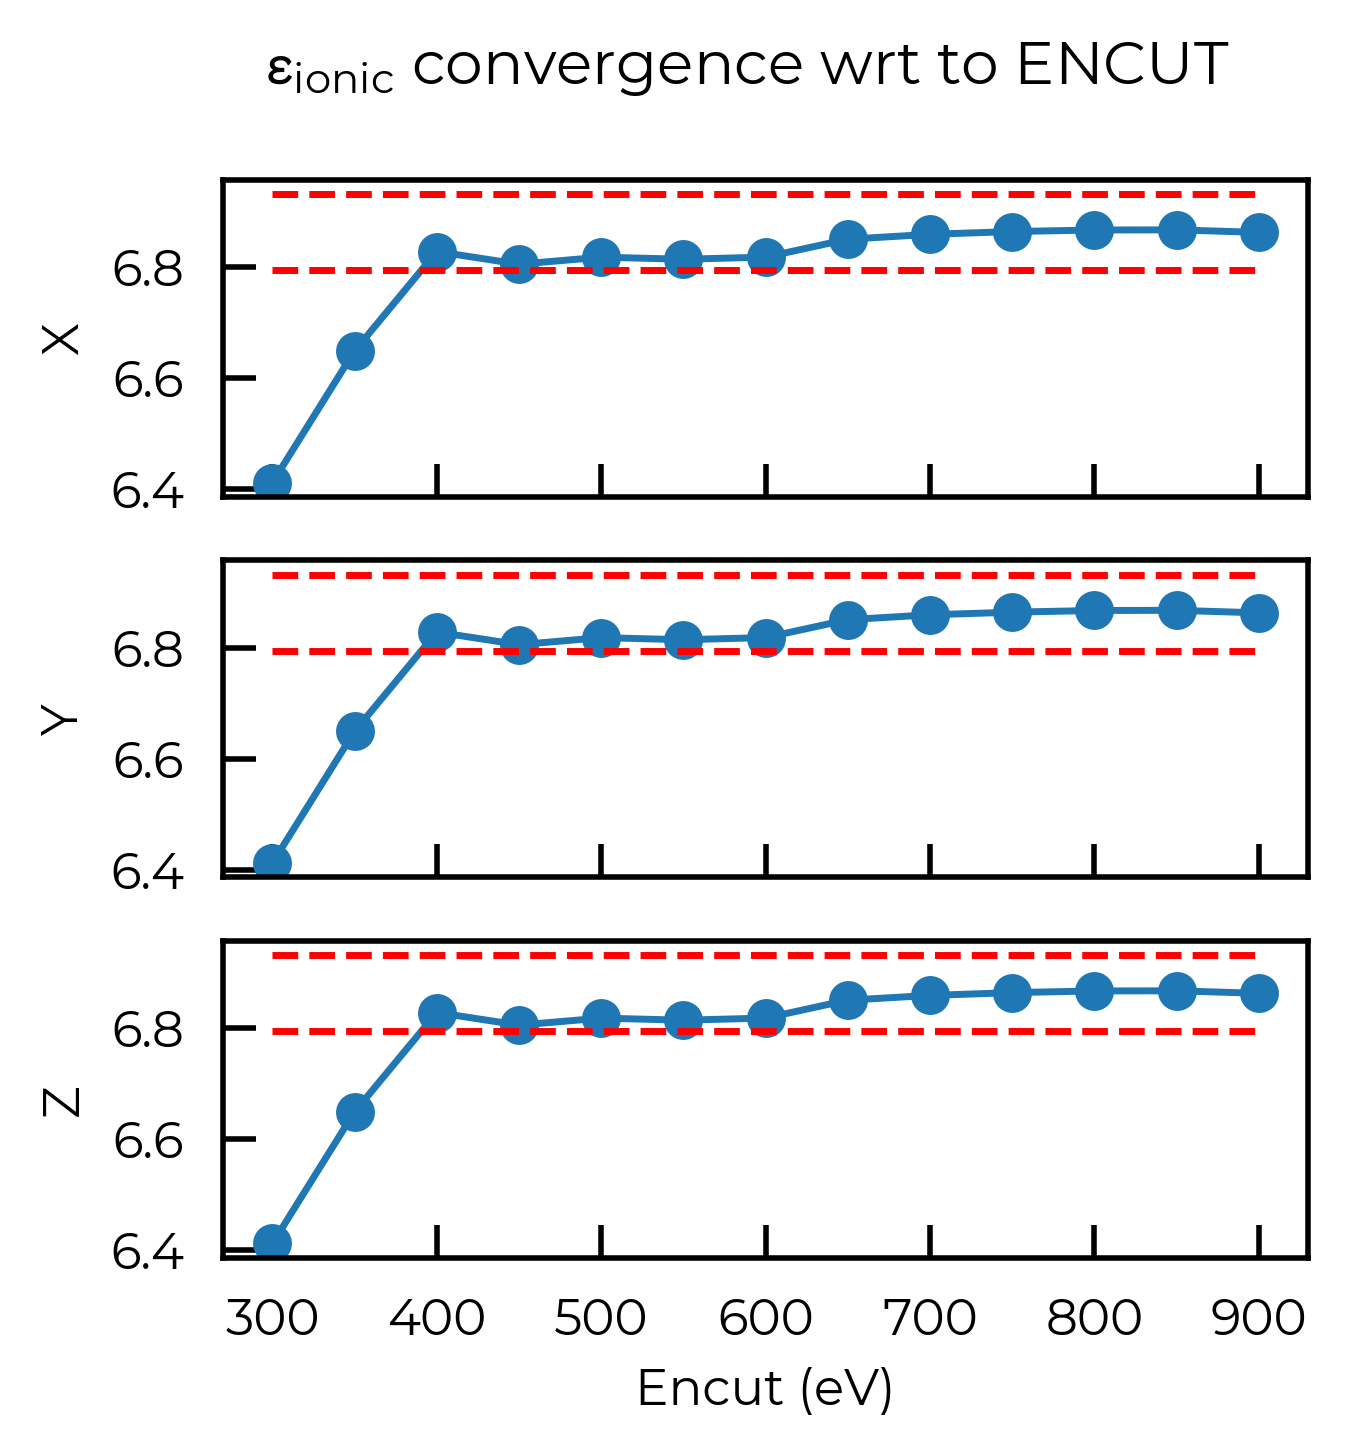

In [27]:
# Parse x,y,z values from optical convergence
ionic_encut = ionic_encut_str.split("\n")[1:]
ionic_encut = [line.split() for line in ionic_encut][1:-1]
encuts = [int(line[0].split("e")[1]) for line in ionic_encut]
print("Encuts:", encuts)
ionic_encut = [line[1:4] for line in ionic_encut]
print("Epsilon:", ionic_encut)
# print(optical_conv)
# Plot x,y,z values in different subplots
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('$\epsilon_{ionic}$ convergence wrt to ENCUT')
axs[0].plot(encuts, [float(line[0]) for line in ionic_encut], marker="o")
axs[0].set_ylabel("X")
axs[1].plot(encuts, [float(line[1]) for line in ionic_encut], marker="o")
axs[1].set_ylabel("Y")
axs[2].plot(encuts, [float(line[2]) for line in ionic_encut], marker="o")
axs[2].set_ylabel("Z")
axs[2].set_xlabel("Encut (eV)")
# Horizontal lines +-1% of last value
for i in range(3):
    axs[i].hlines(
        y=1.01 * float(ionic_encut[-1][i]),
        xmin=encuts[0],
        xmax=encuts[-1],
        color="red",
        linestyles="dashed",
    )
    axs[i].hlines(
        y=0.99 * float(ionic_encut[-1][i]),
        xmin=encuts[0],
        xmax=encuts[-1],
        color="red",
        linestyles="dashed",
    )

Encuts: [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
Epsilon: [['7.157532', '7.157509', '7.157532'], ['6.889848', '6.889842', '6.889834'], ['6.822478', '6.822475', '6.822464'], ['6.805369', '6.805371', '6.805390'], ['6.800997', '6.800992', '6.801008'], ['6.799887', '6.799889', '6.799889'], ['6.799197', '6.799197', '6.799202'], ['6.799392', '6.799393', '6.799397'], ['6.799260', '6.799248', '6.799270'], ['6.799323', '6.799327', '6.799331'], ['6.799111', '6.799112', '6.799113'], ['6.799089', '6.799088', '6.799096'], ['6.799236', '6.799239', '6.799244']]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '4,4,4'),
  Text(1, 0, '5,5,5'),
  Text(2, 0, '6,6,6'),
  Text(3, 0, '7,7,7'),
  Text(4, 0, '8,8,8'),
  Text(5, 0, '9,9,9'),
  Text(6, 0, '10,10,10'),
  Text(7, 0, '11,11,11'),
  Text(8, 0, '12,12,12'),
  Text(9, 0, '13,13,13'),
  Text(10, 0, '14,14,14'),
  Text(11, 0, '15,15,15'),
  Text(12, 0, '16,16,16')])

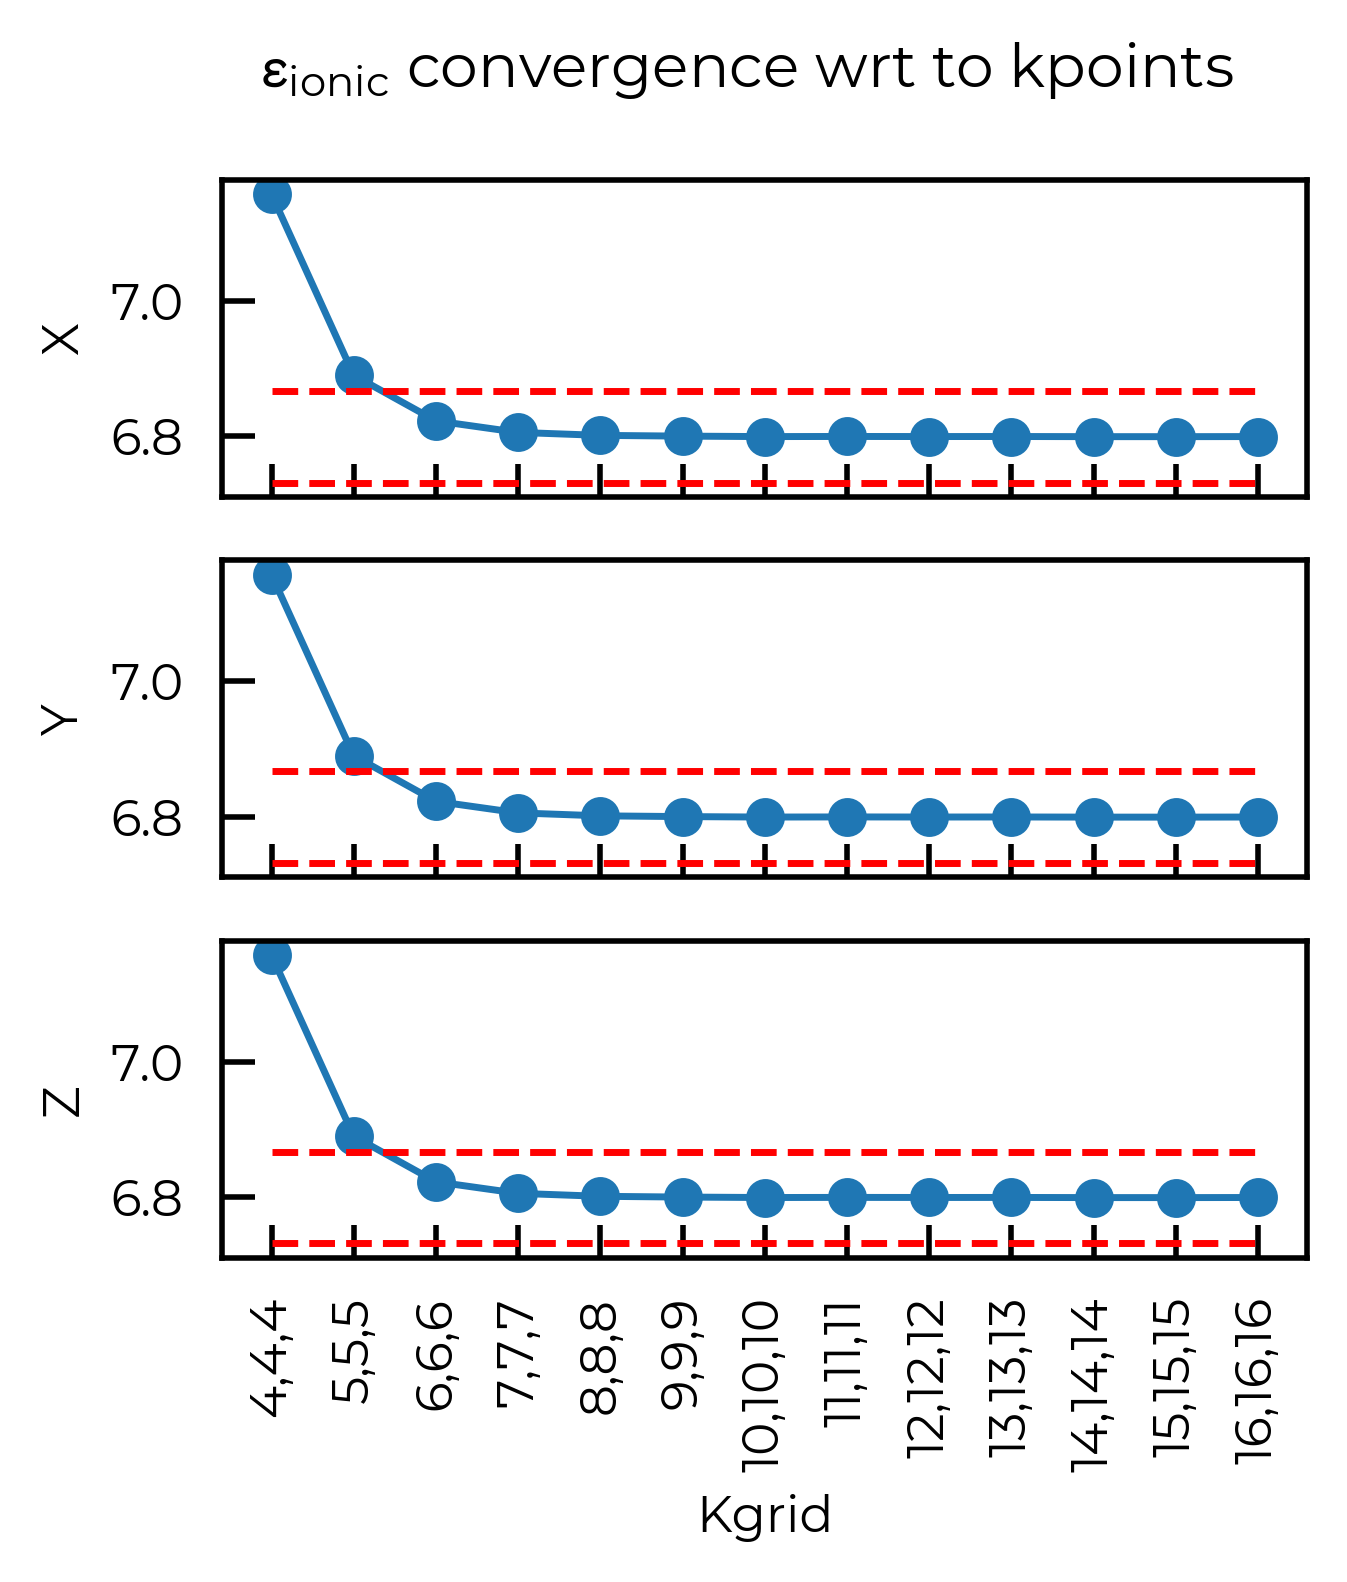

In [28]:
# Parse x,y,z values from optical convergence
data = ionic_kpoint_str.split("\n")[1:]
data = [line.split() for line in data][1:-1]
x = [line[0].split("k")[1].split("_")[-1].split()[0] for line in data]
print("Encuts:", encuts)
data = [line[1:4] for line in data]
print("Epsilon:", data)
# print(optical_conv)
# Plot x,y,z values in different subplots
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('$\epsilon_{ionic}$ convergence wrt to kpoints')
axs[0].plot(x, [float(line[0]) for line in data], marker="o")
axs[0].set_ylabel("X")
axs[1].plot(x, [float(line[1]) for line in data], marker="o")
axs[1].set_ylabel("Y")
axs[2].plot(x, [float(line[2]) for line in data], marker="o")
axs[2].set_ylabel("Z")
axs[2].set_xlabel("Kgrid")
# Horizontal lines +-1% of last value
for i in range(3):
    axs[i].hlines(
        y=1.01 * float(data[-1][i]),
        xmin=x[0],
        xmax=x[-1],
        color="red",
        linestyles="dashed",
    )
    axs[i].hlines(
        y=0.99 * float(data[-1][i]),
        xmin=x[0],
        xmax=x[-1],
        color="red",
        linestyles="dashed",
    )
# Rotate xtick labels
plt.xticks(rotation=90)

We see that for `ENCUT=400` and `kgrid=(6,6,6)`, $\epsilon_{ionic}$ is within 1% of the converged value. 
Since for the kpoint convergence, we used an `ENCUT=450`, we can take the value of $\epsilon_{ionic}$ from the `kgrid=(16,16,16)` calculation. But note that this is not typically the case, where you should do a final calculation with the converged `ENCUT` value and kgrid.

In [29]:
# Print last value of epsilon in data
epsilon_ionic_converged = [float(line) for line in data[-1]]
print(f"Converged ionic epsilon: {epsilon_ionic_converged}")

Converged ionic epsilon: [6.799236, 6.799239, 6.799244]


### 7.3 Total dielectric ($\epsilon_{total}$)

In [30]:
print(f"Converged ionic dielectric: {epsilon_ionic_converged}")
print(f"Converged optical dielectric: {epsilon_optical_converged}")

total_dielectric = np.array(epsilon_ionic_converged) + np.array(epsilon_optical_converged)
print(f"Converged total dielectric: {total_dielectric}")

Converged ionic dielectric: [6.799236, 6.799239, 6.799244]
Converged optical dielectric: [2.097091, 2.097091, 2.097091]
Converged total dielectric: [8.896327 8.89633  8.896335]


## 8. Defect analysis

### 8.1 Parse defect calculations

For parsing defect calculation results with `doped`, we need the following VASP output files
from our bulk and defect supercell calculations:
- `vasprun.xml(.gz)`
- Either:
    - `OUTCAR(.gz)`, if using the Kumagai-Oba (eFNV) charge correction scheme (compatible with isotropic
     or anisotropic (non-cubic) dielectric constants; **recommended**), or
    - `LOCPOT(.gz)`, if using the Freysoldt (FNV) charge correction scheme (isotropic dielectric
    screening only).

Note that `doped` can read the compressed versions of these files (`.gz`/`.xz`/`.bz`/`.lzma`), so we can
 do e.g. `gzip OUTCAR` to reduce the file sizes when downloading and storing these files on our local
 system.

To quickly compress these output files on our HPC, we can run the following from our top-level folder
containing the defect directories (e.g. `Mg_O_0` etc):

```bash
for defect_dir in */vasp_*; do cd $defect_dir; gzip vasprun.xml OUTCAR; cd ../..; done
```

(change `OUTCAR` to `LOCPOT` if using the FNV isotropic charge correction), and then download the files
to the relevant folders by running the following from our local system:

```bash
for defect_dir in */vasp_*; do cd $defect_dir;
scp [remote_machine]:[path to doped folders]/${defect_dir}/\*gz .;
cd ../..; done
```

changing `[remote_machine]` and `[path to doped folders]` accordingly.

```{note}
If you want to use the example outputs shown in this parsing tutorial, you can do so by cloning the `doped` GitHub repository and following the ``dope_gga_workflow.ipynb`` Jupyter notebook.
```
<!--- SK comment: For generating tutorial version, temporarily comment out `if multiple:...` for OUTCAR parsing and comment out "check if same type of charge correction" warning block for multiple corrections  --->

In [31]:
from doped.analysis import DefectsParser
%matplotlib inline

In [2]:
bulk_path = "./MgO/Defects/MgO_bulk/vasp_std"  # path to our bulk supercell calculation
dielectric = 8.8963 # dielectric constant (this can be a single number (isotropic), or a 3x1 array or 3x3 matrix (anisotropic))

In [3]:
dp = DefectsParser(
    output_path="MgO/Defects/",  # directory containing the defect calculation folders
    dielectric=dielectric,  # dielectric needed for charge corrections
    # processes=1,  # Can set the number of processes to 1 if you're having issues with multiprocessing
)

Parsing Mg_O_+4/vasp_std:   0%|          | 0/5 [00:00<?, ?it/s]Parsing Mg_O_+3/vasp_std: 100%|██████████| 5/5 [01:31<00:00, 18.29s/it]  
analysis.py:902: UserWarning: Multiple `vasprun.xml` files found in certain defect directories:
(directory: chosen file for parsing):
MgO/Defects/Mg_O_0/vasp_std: vasprun.xml.gz
MgO/Defects/Mg_O_+1/vasp_std: vasprun.xml.gz
vasprun.xml files are used to parse the calculation energy and metadata.


`DefectsParser` uses multiprocessing by default to speed up parsing when we have many defect supercell calculations to parse. As described in its docstring shown below, it automatically searches the supplied `output_path` for the bulk and defect supercell calculation folders, then automatically determines the defect types, sites (from the relaxed structures) and charge states.

It also checks that appropriate `INCAR`, `KPOINTS`, `POTCAR` settings have been used, and will warn you if it detects any differences that could affect the defect formation energies, as shown in the example above with the mismatching `ADDGRID` tag (here we have manually checked that this choice did not affect the defect formation energies).

`doped` automatically attempts
to perform the appropriate finite-size charge correction method for each defect, based on
the supplied `dielectric` constant and calculation outputs, and will
warn you if any required outputs are missing. 

Additionally, the `DefectsParser` class automatically checks the consistency and estimated error of the defect finite-size charge correction (using the standard error of the mean potential difference in the sampling region, times the defect charge), and will warn you if the estimated error is above `error_tolerance` – 50 meV by default.  As shown later in the [Charge Corrections](#charge_corrections) section, we can directly visualise the 
finite-size charge correction plots (showing how they are being computed) easily with `doped`, which is 
recommended if any of these warnings about the charge correction accuracy are printed.


With our dictionary of parsed defect entries, we can then query some of the defect-specific results, such as the finite-size charge corrections, the defect site, and energy (without accounting for chemical potentials yet):

In [4]:
 dp.defect_dict

{'Mg_O_+4': doped DefectEntry: Mg_O_+4, with bulk composition: MgO and defect: Mg_O. Available attributes:
 {'name', 'sc_defect_frac_coords', 'entry_id', 'degeneracy_factors', 'corrections_metadata', 'defect_supercell_site', 'conventional_structure', 'defect_supercell', 'bulk_entry', 'bulk_supercell', 'charge_state_guessing_log', 'conv_cell_frac_coords', 'equivalent_supercell_sites', 'equiv_conv_cell_frac_coords', 'wyckoff', 'calculation_metadata', 'charge_state', 'corrections', 'sc_entry', 'defect'}
 
 Available methods:
 {'formation_energy', 'from_dict', 'get_ediff', 'get_summary_dict', 'validate_monty_v1', 'as_dict', 'equilibrium_concentration', 'to_json', 'unsafe_hash', 'get_kumagai_correction', 'plot_site_displacements', 'get_freysoldt_correction', 'validate_monty_v2', 'from_json'},
 'Mg_O_0': doped DefectEntry: Mg_O_0, with bulk composition: MgO and defect: Mg_O. Available attributes:
 {'name', 'sc_defect_frac_coords', 'entry_id', 'degeneracy_factors', 'corrections_metadata', 'de

In [5]:
for name, defect_entry in dp.defect_dict.items():
    print(f"{name}:")
    if defect_entry.charge_state != 0:  # no charge correction for neutral defects
        print(f"Charge = {defect_entry.charge_state:+} with finite-size charge correction: {list(defect_entry.corrections.values())[0]:+.2f} eV")
    print(f"Supercell site: {defect_entry.defect_supercell_site.frac_coords.round(3)}\n")

Mg_O_+4:
Charge = +4 with finite-size charge correction: +2.59 eV
Supercell site: [0.501 0.578 0.577]

Mg_O_0:
Supercell site: [0.428 0.546 0.545]

Mg_O_+1:
Charge = +1 with finite-size charge correction: +0.20 eV
Supercell site: [0.436 0.553 0.551]

Mg_O_+2:
Charge = +2 with finite-size charge correction: +0.72 eV
Supercell site: [0.559 0.444 0.44 ]

Mg_O_+3:
Charge = +3 with finite-size charge correction: +1.57 eV
Supercell site: [0.443 0.441 0.556]


As mentioned in the previous [Generate Defects](#generate_defects),
we can save `doped` outputs to JSON files and then share or reload them later on, without needing to
re-run the parsing steps above. Here we save our parsed defect entries using the `dumpfn`
function from `monty.serialization`:

In [6]:
from monty.serialization import dumpfn, loadfn

dumpfn(dp.defect_dict, "./MgO/MgO_defect_dict.json")  # save parsed defect entries to file

The parsed defect entries can then be reloaded from the `json` file with:

In [1]:
from monty.serialization import loadfn

MgO_defect_dict = loadfn("MgO/MgO_defect_dict.json")

### 8.2 Defect Formation Energy / Transition Level Diagrams

```{tip}
Defect formation energy (a.k.a. transition level diagrams) are one of the key results from a
computational defect study, giving us a lot of information on the defect thermodynamics and electronic behaviour.
```

```{important}
To calculate and plot the defect formation energies, we generate a `DefectPhaseDiagram` object, which
can be created using the `get_defect_thermodynamics()` method of the DefectParser() class. It outputs a `DefectThermodynamics` object:
```

In [8]:
# generate DefectPhaseDiagram object, with which we can plot/tabulate formation energies, calculate charge transition levels etc:

MgO_thermo = dp.get_defect_thermodynamics()

To calculate and plot defect formation energies, we need to know the chemical potentials of the elements
 in the system (see the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg) for more details on
 this).
Since we have calculated the chemical potentials in the previous ``Chemical Potentials`` section, we can just load the results from the JSON file here:

In [9]:
from monty.serialization import dumpfn, loadfn
MgO_chempots = loadfn('competing_phases/MgO/mgo_chempots.json')
print(MgO_chempots)

{'limits': {'MgO-Mg': {'Mg': -1.7360624375, 'O': -10.7807654025}, 'MgO-O2': {'Mg': -7.38178196, 'O': -5.13504588}}, 'elemental_refs': {'O': -5.13504588, 'Mg': -1.7360624375}, 'limits_wrt_el_refs': {'MgO-Mg': {'Mg': 0.0, 'O': -5.6457195225}, 'MgO-O2': {'Mg': -5.645719522499999, 'O': 0.0}}}


And we can feed them into the `dp.get_defect_thermodynamics()` method to store them as a class attribute:

In [10]:
MgO_thermo = dp.get_defect_thermodynamics(
    chempots=MgO_chempots,
)
dumpfn(MgO_thermo, "./MgO/MgO_thermo.json")  # save parsed DefectPhaseDiagram to file, so we don't need to regenerate it later

In [11]:
MgO_thermo.chempots

{'limits': {'MgO-Mg': {'Mg': -1.7360624375, 'O': -10.7807654025},
  'MgO-O2': {'Mg': -7.38178196, 'O': -5.13504588}},
 'elemental_refs': {'O': -5.13504588, 'Mg': -1.7360624375},
 'limits_wrt_el_refs': {'MgO-Mg': {'Mg': 0.0, 'O': -5.6457195225},
  'MgO-O2': {'Mg': -5.645719522499999, 'O': 0.0}}}

Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. chemical potential limits),
 rather than typing out the chemical potentials obtained from a different method / manually.
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `limits_wrt_el_refs` entry in the `CdTe_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

plotting.py:34: UserWarning: Unable to import pycairo. Defaulting to matplotlib's pdf backend, so default doped fonts may not be used. Try setting `save_format` to 'png' or doing `conda remove pycairo; conda install pycairo` if you want doped's default font.


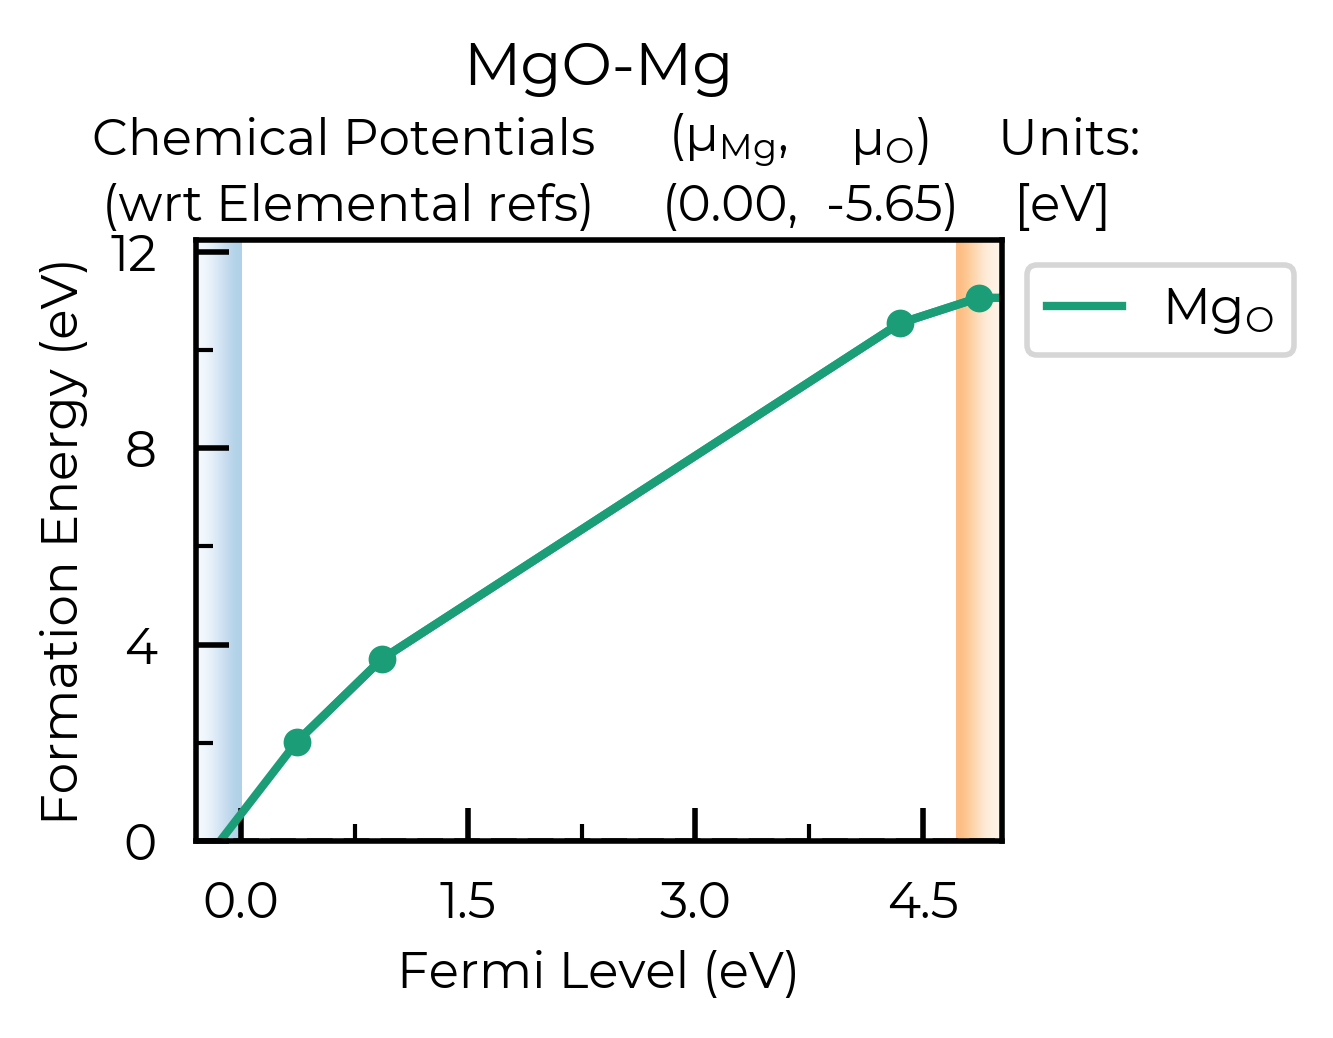

In [12]:
from doped.utils import plotting

fig = MgO_thermo.plot(
    limit="MgO-Mg",  # can specify chemical potential conditions
    filename="MgO/Mg_O_Mg-Rich.pdf",  # save figure to file
)

```{tip}
As shown above, can specify the chemical potential limit at which to obtain and plot the defect formation energies using the ``limit`` parameter, which we can set to either ``"X-rich"/"X-poor"`` where X is an element in the system, in which case the most X-rich/poor limit will be used (e.g. "Cd-rich"), or a key in the ``chempots["limits"]`` dictionary (e.g. ``"Cd-CdTe"`` from that shown above). Alternatively, one can also provide a single chemical potential limit in the form of a dictonary to the ``DefectThermodynamics`` methods – see docstrings for more details.
``` 

There are a lot of options for making the formation energy plot prettier:

In [13]:
# you can run this cell to see the possible arguments for this function:
MgO_thermo.plot?
# or go to the python API documentation for this function:
# https://doped.readthedocs.io/en/latest/doped.thermodynamics.html#doped.thermodynamics.DefectThermodynamics.plot

Signature:
MgO_thermo.plot(
    chempots: Optional[Dict] = None,
    limit: Optional[str] = None,
    el_refs: Optional[Dict] = None,
    chempot_table: bool = True,
    all_entries: Union[bool, str] = False,
    style_file: Optional[str] = None,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
    fermi_level: Optional[float] = None,
    colormap: Union[str, matplotlib.colors.Colormap, NoneType] = None,
    auto_labels: bool = False,
    filename: Optional[str] = None,
) -> Union[matplotlib.figure.Figure, List[matplotlib.figure.Figure]]
Docstring:
Produce a defect formation energy vs Fermi level plot (a.k.a. a defect
formation energy / transition level diagram). Returns the Matplotlib
Figure object to allow further plot customisation.

Args:
    chempots (dict):
        Dictionary of chemical potentials to use for calculating the defect
        formation energies. If None (default), will use self.chempots.
        This can have the form of {"limits": [{'limit': [che

We could also manually input the chemical potentials like this:

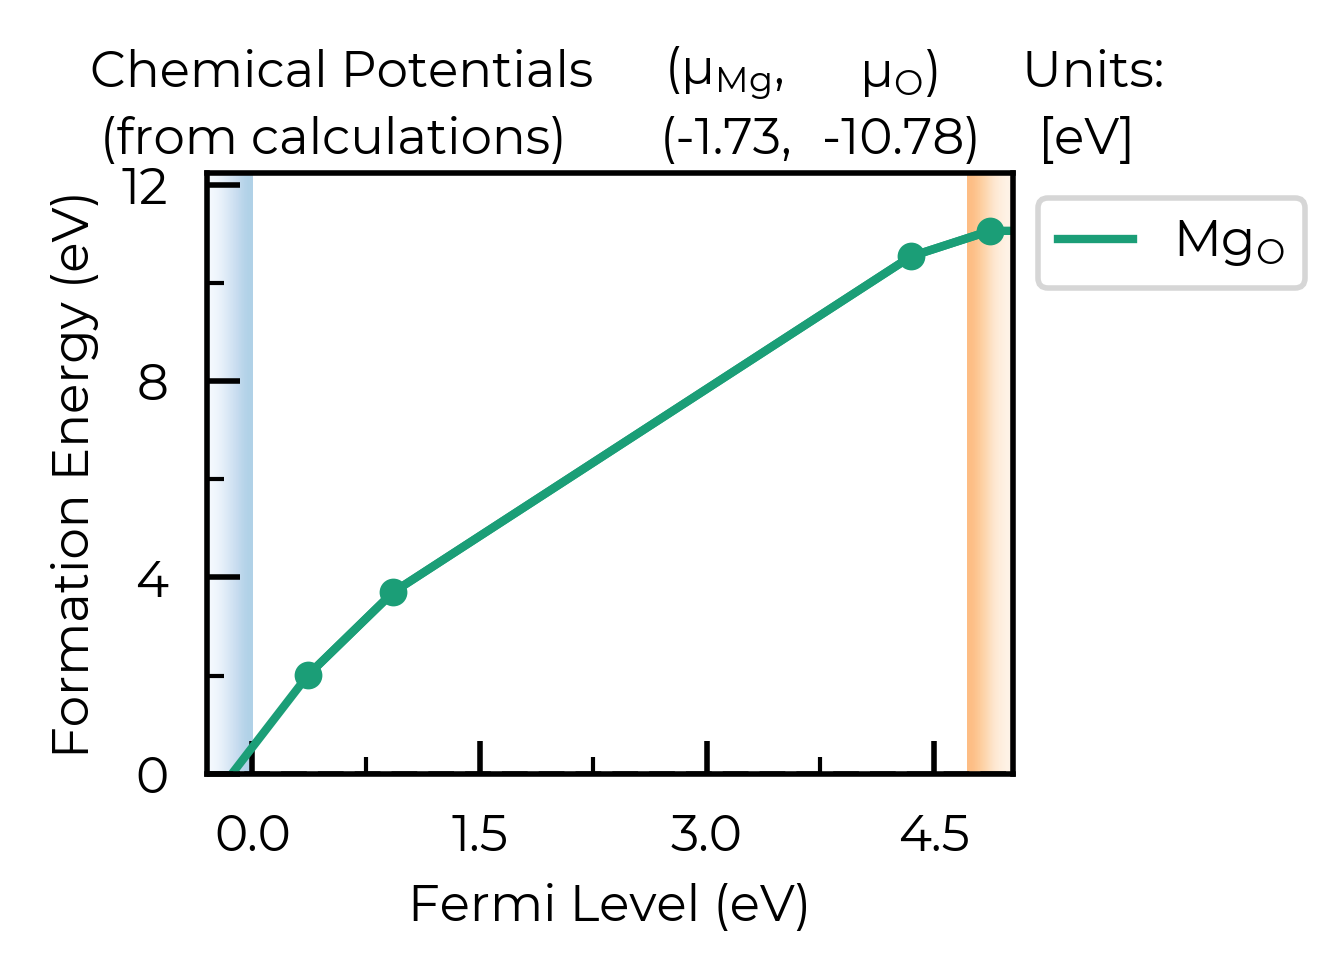

In [14]:
from doped.utils import plotting

fig = MgO_thermo.plot(
    chempots={"Mg": -1.73, "O": -10.78},  # manually inputting the chemical potentials
)

#### Formation Energy Tables

We can also get tables of the defect formation energies (including terms in the formation energy equation,
such as the charge correction and chemical potentials), as shown below:

In [15]:
list_of_formation_energy_dfs = MgO_thermo.get_formation_energies()
list_of_formation_energy_dfs

Fermi level was not set, so using mid-gap Fermi level (E_g/2 = 2.36 eV relative to the VBM).


[  Defect  q   ΔEʳᵃʷ  qE_VBM   qE_F  Σμ_ref  Σμ_formal  E_corr  ΔEᶠᵒʳᵐ  \
 0   Mg_O  4  -5.511  12.517  9.444  -3.399     -5.646   2.586   9.991   
 1   Mg_O  3  -0.999   9.388  7.083  -3.399     -5.646   1.572   7.999   
 2   Mg_O  2   3.908   6.259  4.722  -3.399     -5.646   0.723   6.567   
 3   Mg_O  1  11.911   3.129  2.361  -3.399     -5.646   0.199   8.555   
 4   Mg_O  0  20.109   0.000  0.000  -3.399     -5.646   0.000  11.064   
 
                            Path  
 0  MgO/Defects/Mg_O_+4/vasp_std  
 1  MgO/Defects/Mg_O_+3/vasp_std  
 2  MgO/Defects/Mg_O_+2/vasp_std  
 3  MgO/Defects/Mg_O_+1/vasp_std  
 4   MgO/Defects/Mg_O_0/vasp_std  ,
   Defect  q   ΔEʳᵃʷ  qE_VBM   qE_F  Σμ_ref  Σμ_formal  E_corr  ΔEᶠᵒʳᵐ  \
 0   Mg_O  4  -5.511  12.517  9.444  -3.399      5.646   2.586  21.283   
 1   Mg_O  3  -0.999   9.388  7.083  -3.399      5.646   1.572  19.290   
 2   Mg_O  2   3.908   6.259  4.722  -3.399      5.646   0.723  17.859   
 3   Mg_O  1  11.911   3.129  2.361  -3.399    

```{tip}
The `get_formation_energies` function returns a list of `pandas.DataFrame` objects (or a single
`DataFrame` object if a certain chemical potential `limit` was chosen), which we can save to csv as
shown below. As a `csv` file, this can then be easily imported to `Microsoft Word` or to `LaTeX` (using
e.g.
<a href="https://www.tablesgenerator.com/latex_tables">https://www.tablesgenerator.com/latex_tables</a>)
 to be included in Supporting Information of papers or
 in theses, which we would recommend for open-science, queryability and reproducibility!
```

In [16]:
list_of_formation_energy_dfs[0]  # First dataframe in list corresponds to Magnesium rich conditions

Defect  q   ΔEʳᵃʷ  qE_VBM   qE_F  Σμ_ref  Σμ_formal  E_corr  ΔEᶠᵒʳᵐ  \
0   Mg_O  4  -5.511  12.517  9.444  -3.399     -5.646   2.586   9.991   
1   Mg_O  3  -0.999   9.388  7.083  -3.399     -5.646   1.572   7.999   
2   Mg_O  2   3.908   6.259  4.722  -3.399     -5.646   0.723   6.567   
3   Mg_O  1  11.911   3.129  2.361  -3.399     -5.646   0.199   8.555   
4   Mg_O  0  20.109   0.000  0.000  -3.399     -5.646   0.000  11.064   

                           Path  
0  MgO/Defects/Mg_O_+4/vasp_std  
1  MgO/Defects/Mg_O_+3/vasp_std  
2  MgO/Defects/Mg_O_+2/vasp_std  
3  MgO/Defects/Mg_O_+1/vasp_std  
4   MgO/Defects/Mg_O_0/vasp_std

In [17]:
list_of_formation_energy_dfs[1]  # First dataframe in list corresponds to Oxygen rich conditions

Defect  q   ΔEʳᵃʷ  qE_VBM   qE_F  Σμ_ref  Σμ_formal  E_corr  ΔEᶠᵒʳᵐ  \
0   Mg_O  4  -5.511  12.517  9.444  -3.399      5.646   2.586  21.283   
1   Mg_O  3  -0.999   9.388  7.083  -3.399      5.646   1.572  19.290   
2   Mg_O  2   3.908   6.259  4.722  -3.399      5.646   0.723  17.859   
3   Mg_O  1  11.911   3.129  2.361  -3.399      5.646   0.199  19.847   
4   Mg_O  0  20.109   0.000  0.000  -3.399      5.646   0.000  22.356   

                           Path  
0  MgO/Defects/Mg_O_+4/vasp_std  
1  MgO/Defects/Mg_O_+3/vasp_std  
2  MgO/Defects/Mg_O_+2/vasp_std  
3  MgO/Defects/Mg_O_+1/vasp_std  
4   MgO/Defects/Mg_O_0/vasp_std

In [18]:
list_of_formation_energy_dfs[0].to_csv(f"MgO/Mg_O_Formation_Energies_Mg_rich.csv", index=False)

<a id='defect_concentrations'></a>
### 8.3 Defect concentrations

To calculate defect concentrations one should account for the defect degeneracies (see [10.1039/D2FD00043A](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d2fd00043a) or [10.1039/D3CS00432E](https://pubs.rsc.org/en/content/articlehtml/2023/cs/d3cs00432e) for more details). 
Mainly, these degeneracies include the spin and orientational degeneracy. The spin degeneracy results from the equivalent electronic configurations that a defect with an unpaired electron can adopt (the electron can have up or down spin). By default, `doped` assumes singlet (S=0) state for even-electron defects and doublet (S=1/2) state for odd-electron defects, which is typically the case but can have triplets (S=1) or other multiplets for e.g. bipolarons, quantum / d-orbital / magnetic defects etc.    
The orientational degeneracy accounts for the inequivalent orientations of the defect at the same site due to a lowering of the local symmetry. Formally, they are given by:

$ g_{\rm spin} = 2S+1$ where $S$ is the total spin angular momentum

$ g_{\rm orient} = \frac{Z_{\rm defect}}{Z_{\rm bulk}} = \frac{N_{\rm bulk}}{N_{\rm defect}}$ where $N$ is the number of point symmetry operations for the defect site in the pristine ($N_{\rm bulk}$) and defective structures ($N_{\rm defect}$).

With `doped`, the defect degeneracies are calculated automatically when parsing the defect results. 
We can inspect them with the `get_symmetries_and_degeneracies()` method of the `DefectThermodynamics` class:

In [19]:
from monty.serialization import loadfn

# Load from json
MgO_thermo = loadfn("./MgO/MgO_thermo.json")

In [20]:
MgO_thermo.get_symmetries_and_degeneracies()

Defect   q Site_Symm Defect_Symm  g_Orient  g_Spin  g_Total  Mult
0   Mg_O  +4        Oh         C2v      12.0       1     12.0   1.0
1   Mg_O  +3        Oh         C3v       8.0       2     16.0   1.0
2   Mg_O  +2        Oh         C3v       8.0       1      8.0   1.0
3   Mg_O  +1        Oh          Cs      24.0       2     48.0   1.0
4   Mg_O   0        Oh          Cs      24.0       1     24.0   1.0

The total degeneracy ($g_{\rm total}$) enters the defect concentration equation as:
$c = \frac{g_{\rm total}}{N_{\rm sites}} \exp\left(-\frac{E_{\rm form}}{kT}\right)$

where $N_{\rm sites}$ is the number of defect sites in the supercell, $E_{\rm form}$ is the defect formation energy and $kT$ is the thermal energy at temperature $T$.

```{important}
The defect formation energy (and thus its concentration) depends on the Fermi level, which depends itself in the defect concentrations. Accordingly, both the concentrations and the Fermi level have to be calculated self-consistently. 
```

Here, since we have only considered one defect for demonstration purposes, we can't calculate the equilibrium Fermi level. But we can still calculate the defect concentrations at a given Fermi level, as shown below.

In [37]:
MgO_thermo.get_equilibrium_concentrations?

Signature:
MgO_thermo.get_equilibrium_concentrations(
    chempots: Optional[dict] = None,
    limit: Optional[str] = None,
    fermi_level: Optional[float] = None,
    temperature: float = 300,
    per_charge: bool = True,
    per_site: bool = False,
    skip_formatting: bool = False,
) -> pandas.core.frame.DataFrame
Docstring:
Compute the `equilibrium` concentrations (in cm^-3) for all
``DefectEntry``\s in the ``DefectThermodynamics`` object, at a given
chemical potential limit, fermi_level and temperature, assuming the
dilute limit approximation.

Note that these are the `equilibrium` defect concentrations!
DefectThermodynamics.get_quenched_fermi_level_and_concentrations() can
instead be used to calculate the Fermi level and defect concentrations
for a material grown/annealed at higher temperatures and then cooled
(quenched) to room/operating temperature (where defect concentrations
are assumed to remain fixed) - this is known as the frozen defect
approach and is typically the most 

In [38]:
# If we don't specify the fermi level, the default is to use a mid-gap fermi level
MgO_thermo.get_equilibrium_concentrations(chempots=MgO_chempots, limit="MgO-Mg")

Fermi level was not set, so using mid-gap Fermi level (E_g/2 = 2.36 eV relative to the VBM).


Defect Charge  Formation Energy (eV) Concentration (cm^-3)  \
0   Mg_O     +4                  9.991            9.253e-145   
1   Mg_O     +3                  7.999            3.670e-111   
2   Mg_O     +2                  6.567             2.043e-87   
3   Mg_O     +1                  8.555            4.941e-120   
4   Mg_O      0                 11.064            1.740e-162   

  Charge State Population  
0                    0.0%  
1                    0.0%  
2                  100.0%  
3                    0.0%  
4                    0.0%

which shows that the concentrations of the Mg_O antisite are very small, as expected for a defect with such a large formation energy, which is common for cation on anion or anion on cation antisites in highly ionic compounds like MgO.

<a id='site_displacements'></a>
### 8.4 Analysing site displacements

We can check that our supercell is large enough by plotting the site displacements as a function of the site distance to the defect. The site displacements are calculated by comparing to the original position of the site in the pristine supercell.   
If the supercell is large enough, the displacements should decay to zero as the distance from the defect increases.

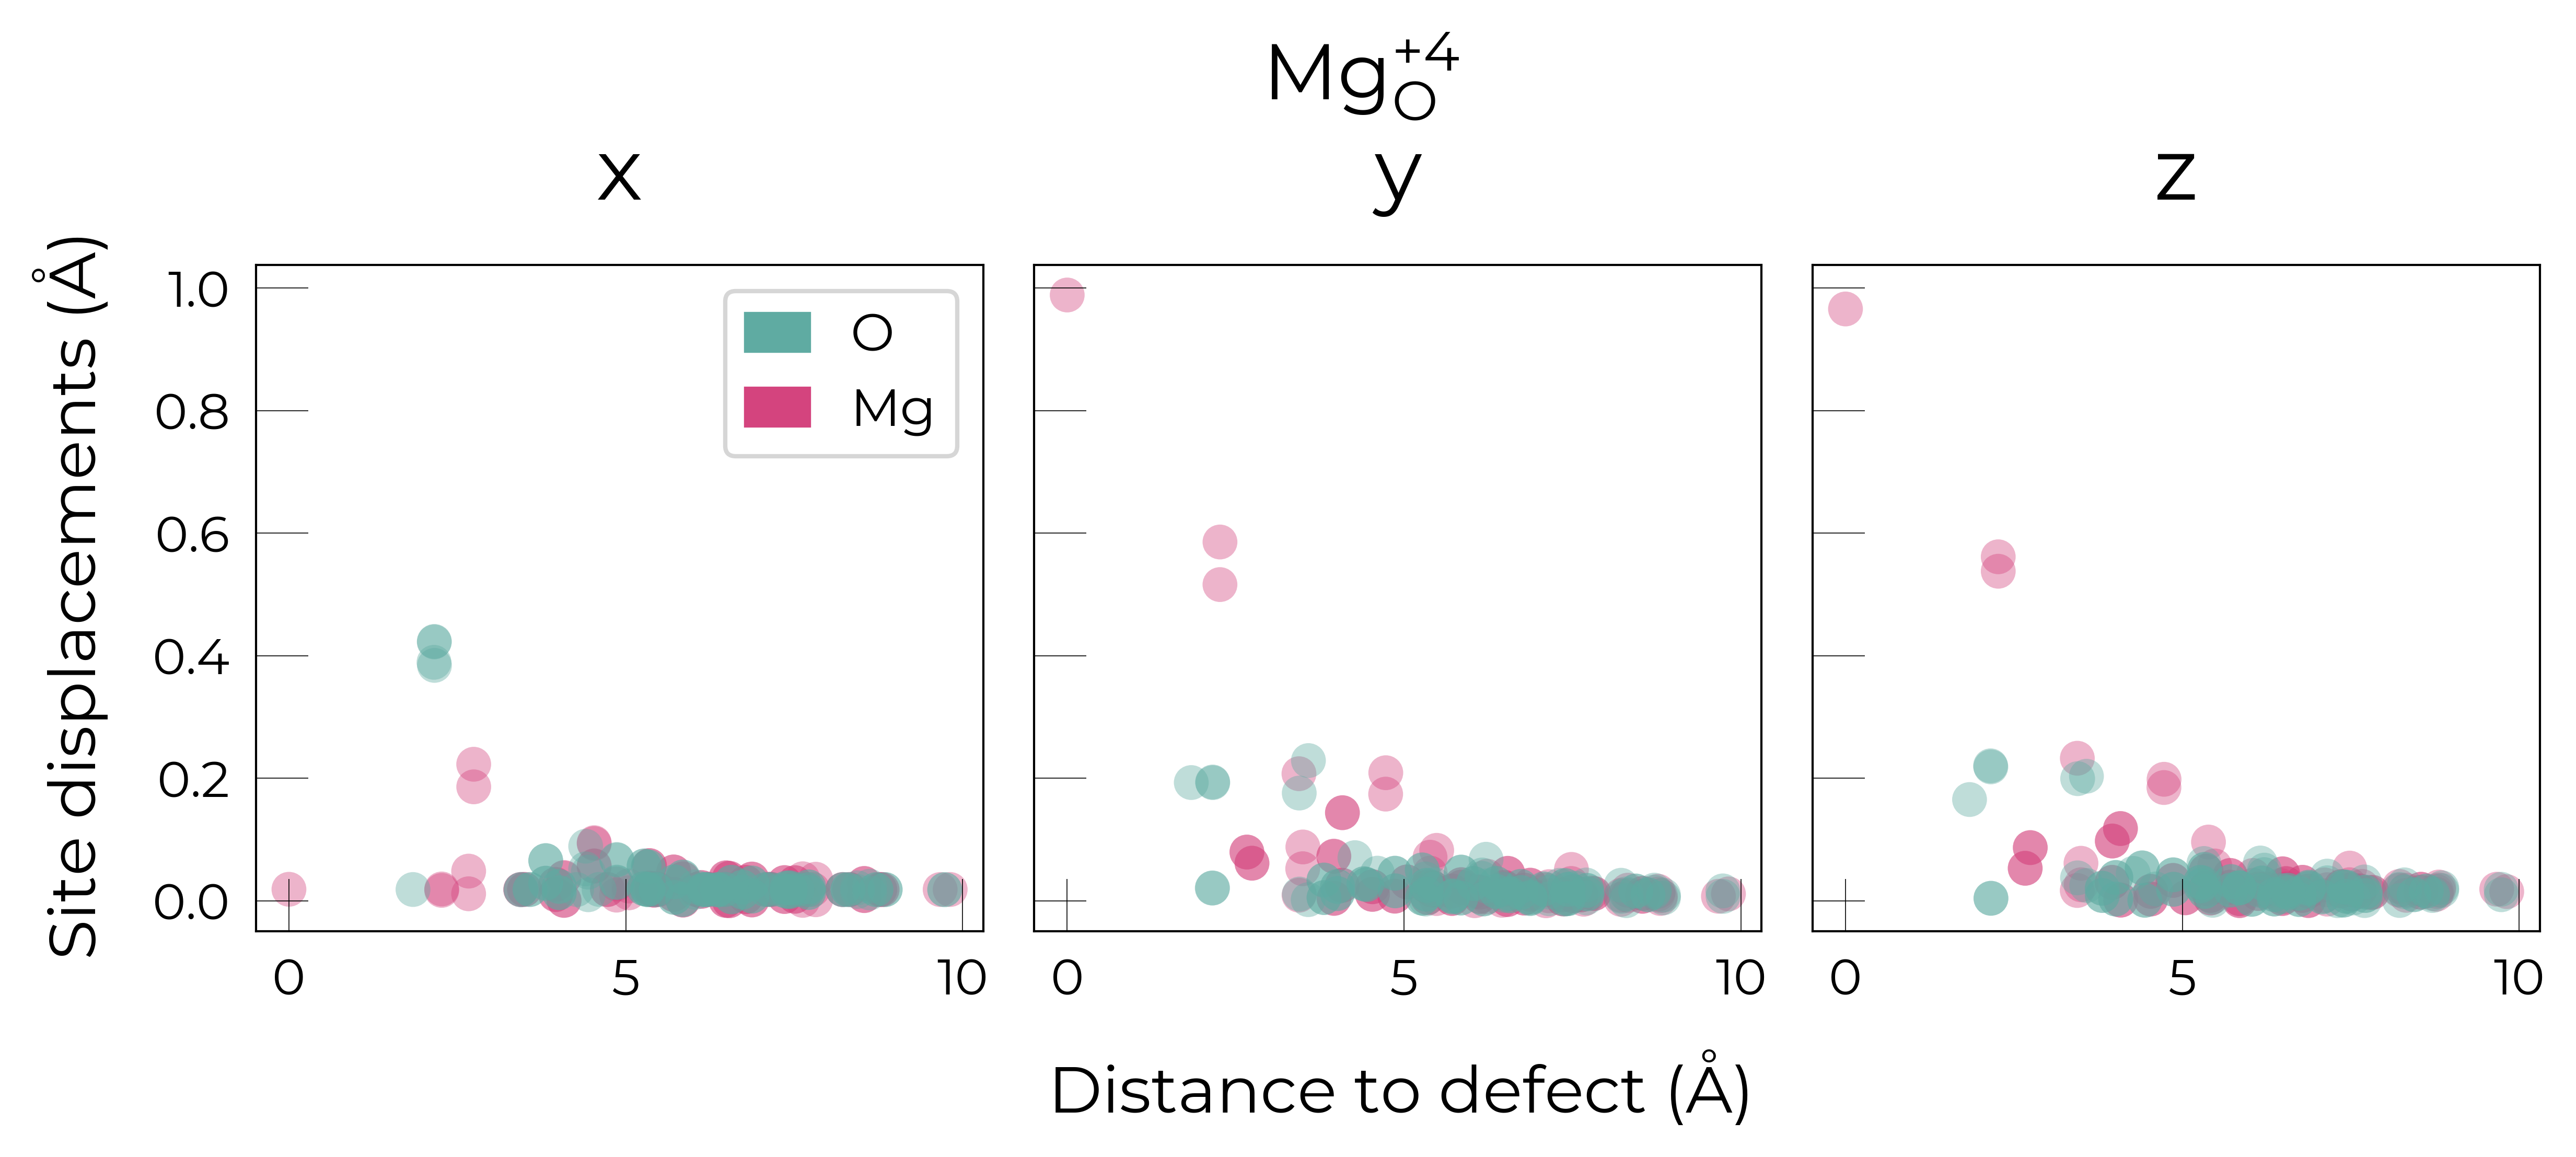

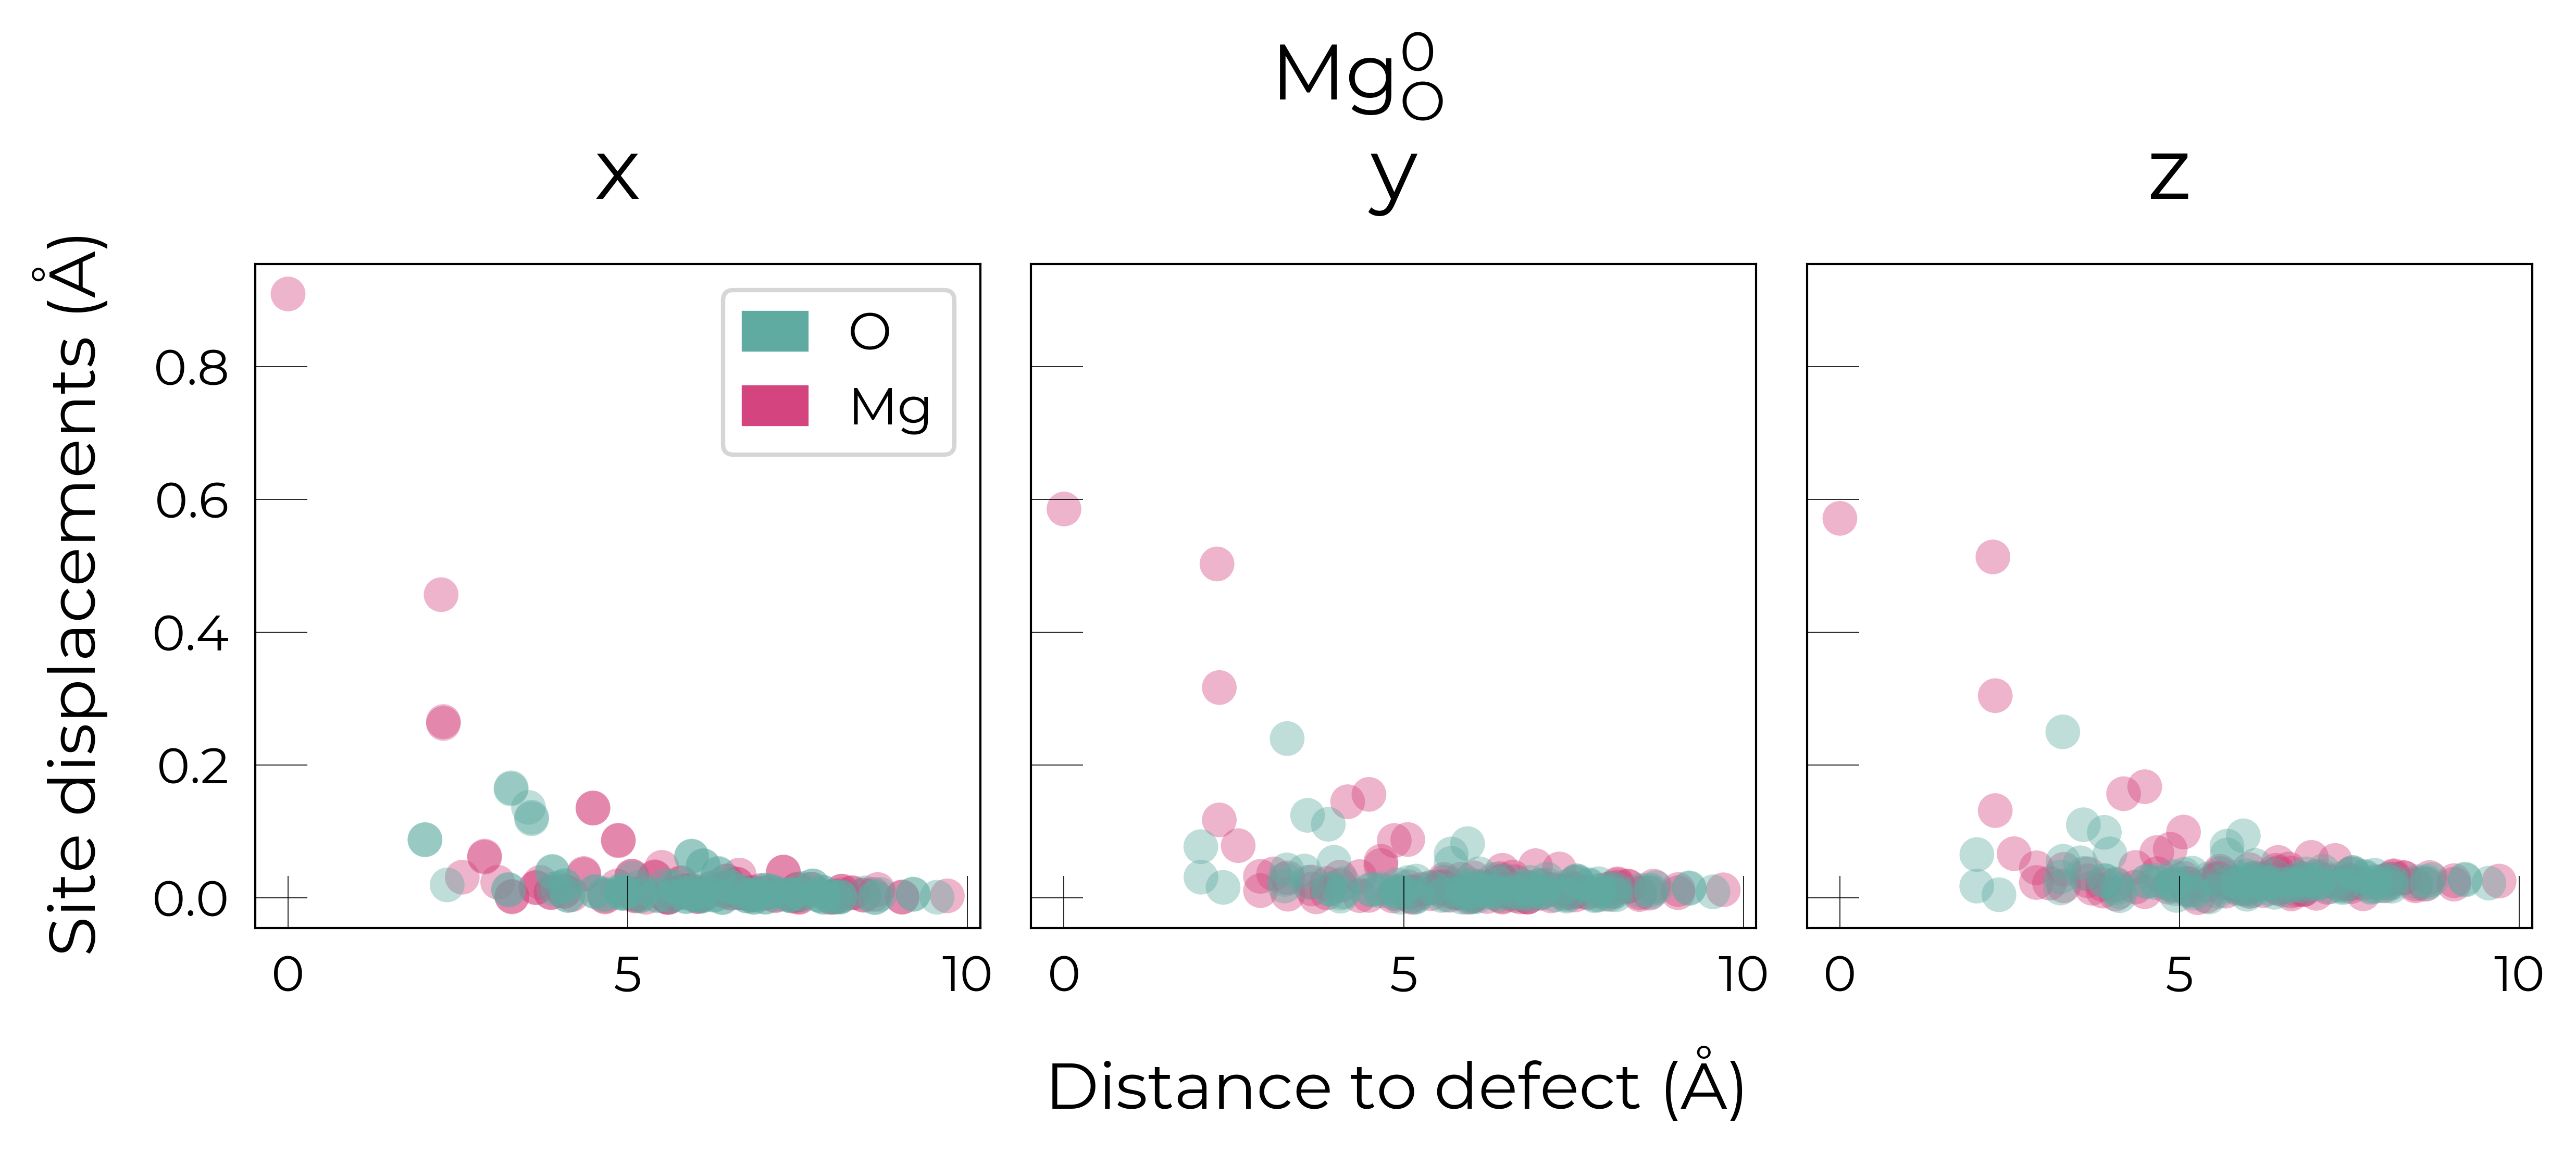

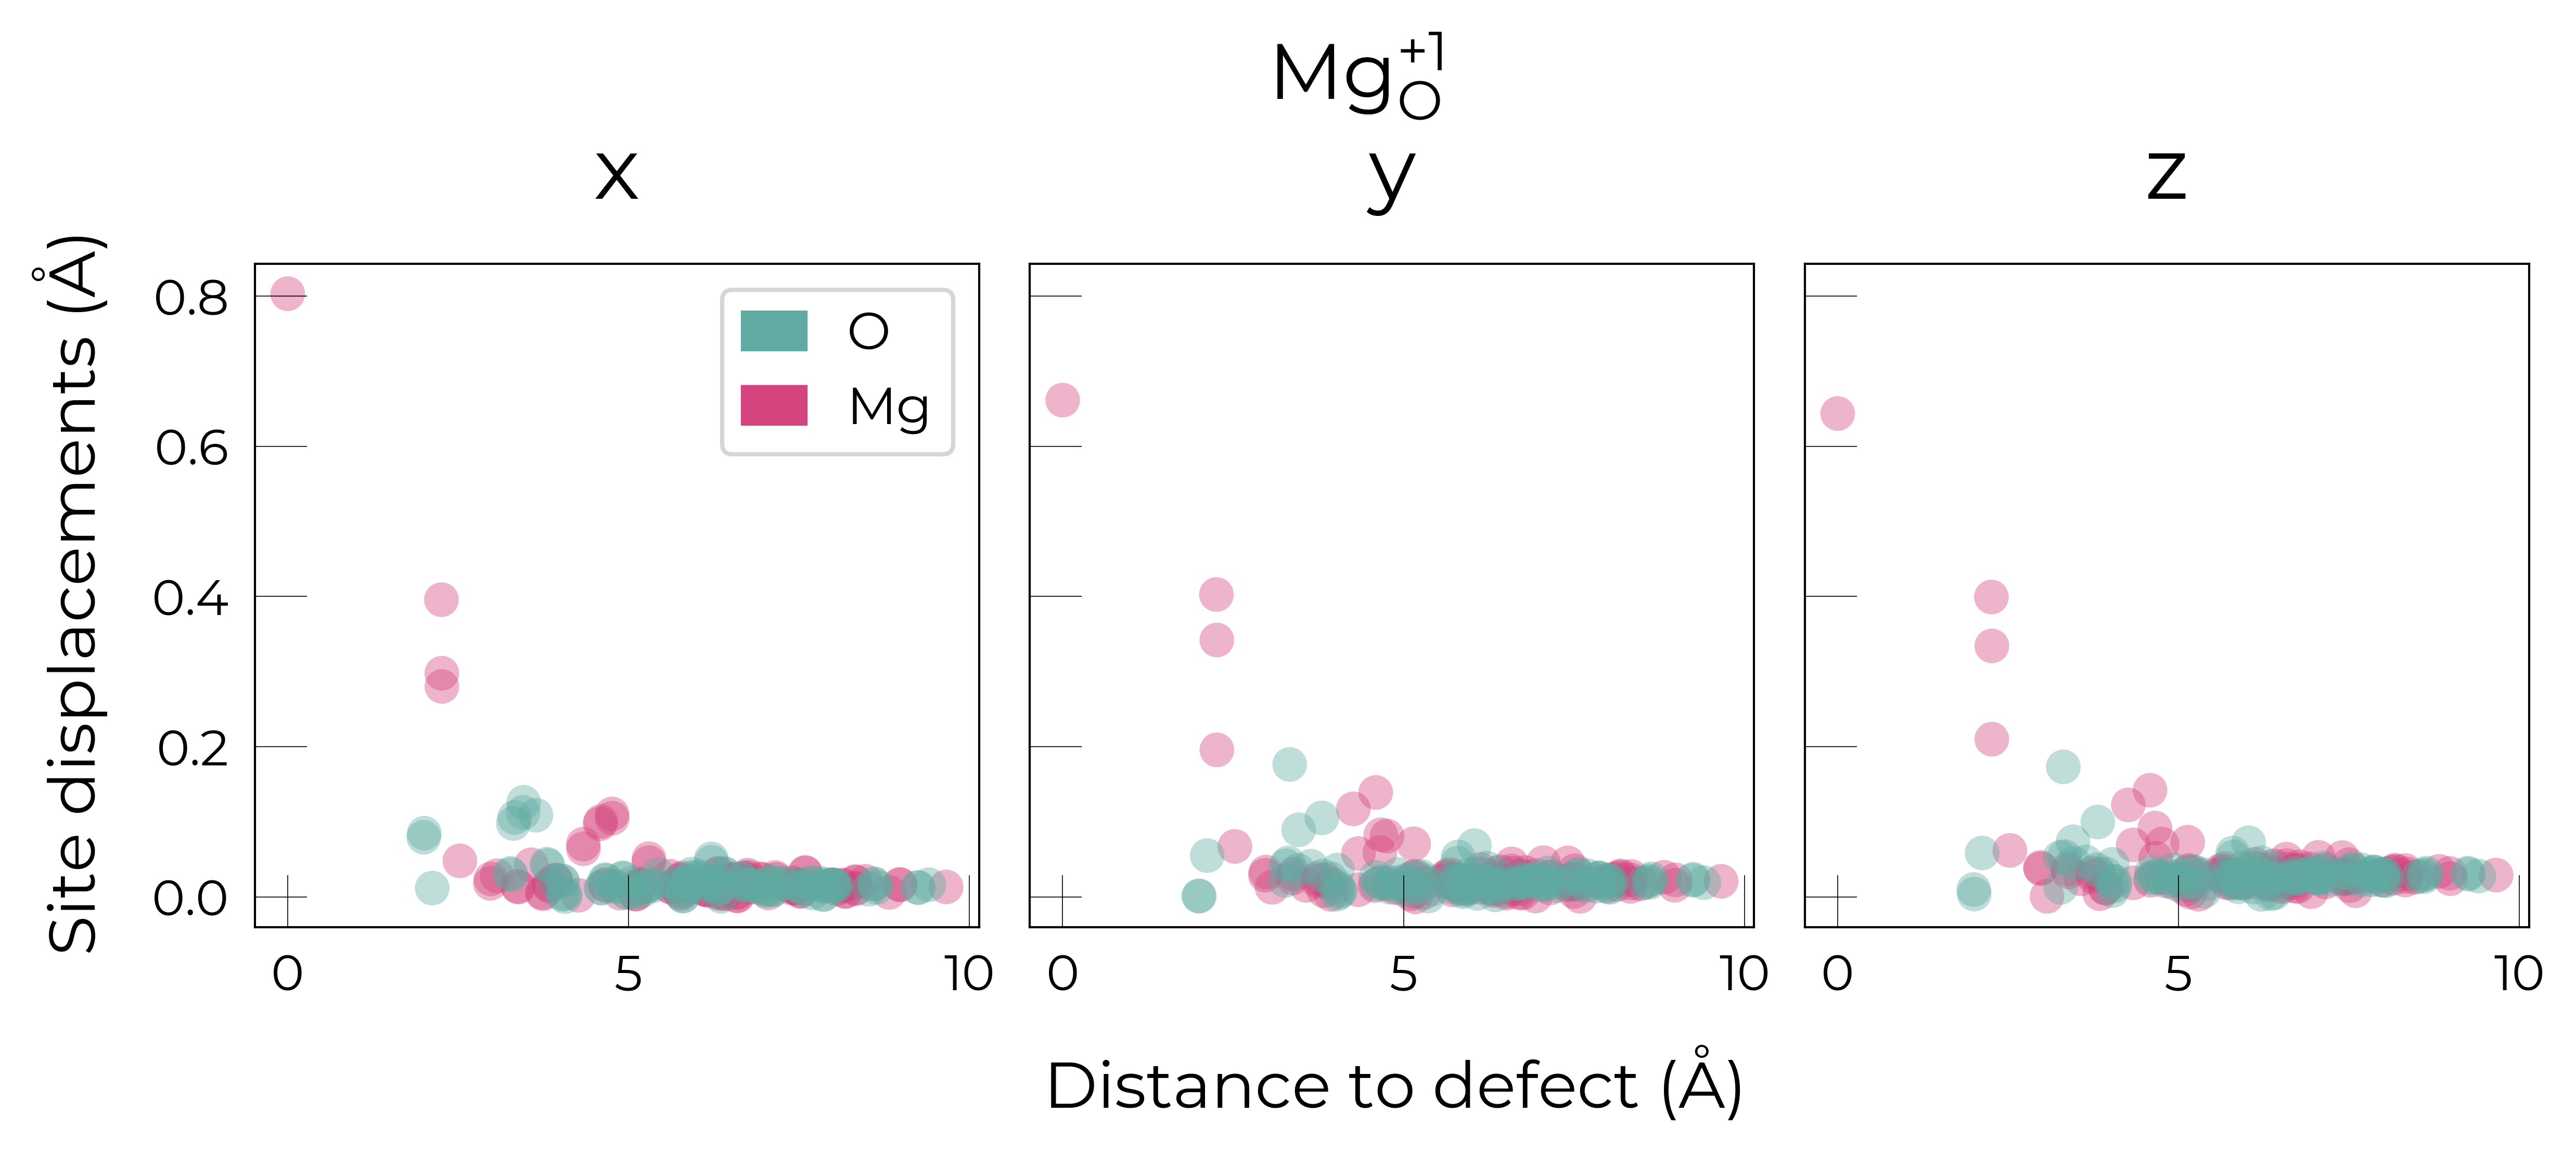

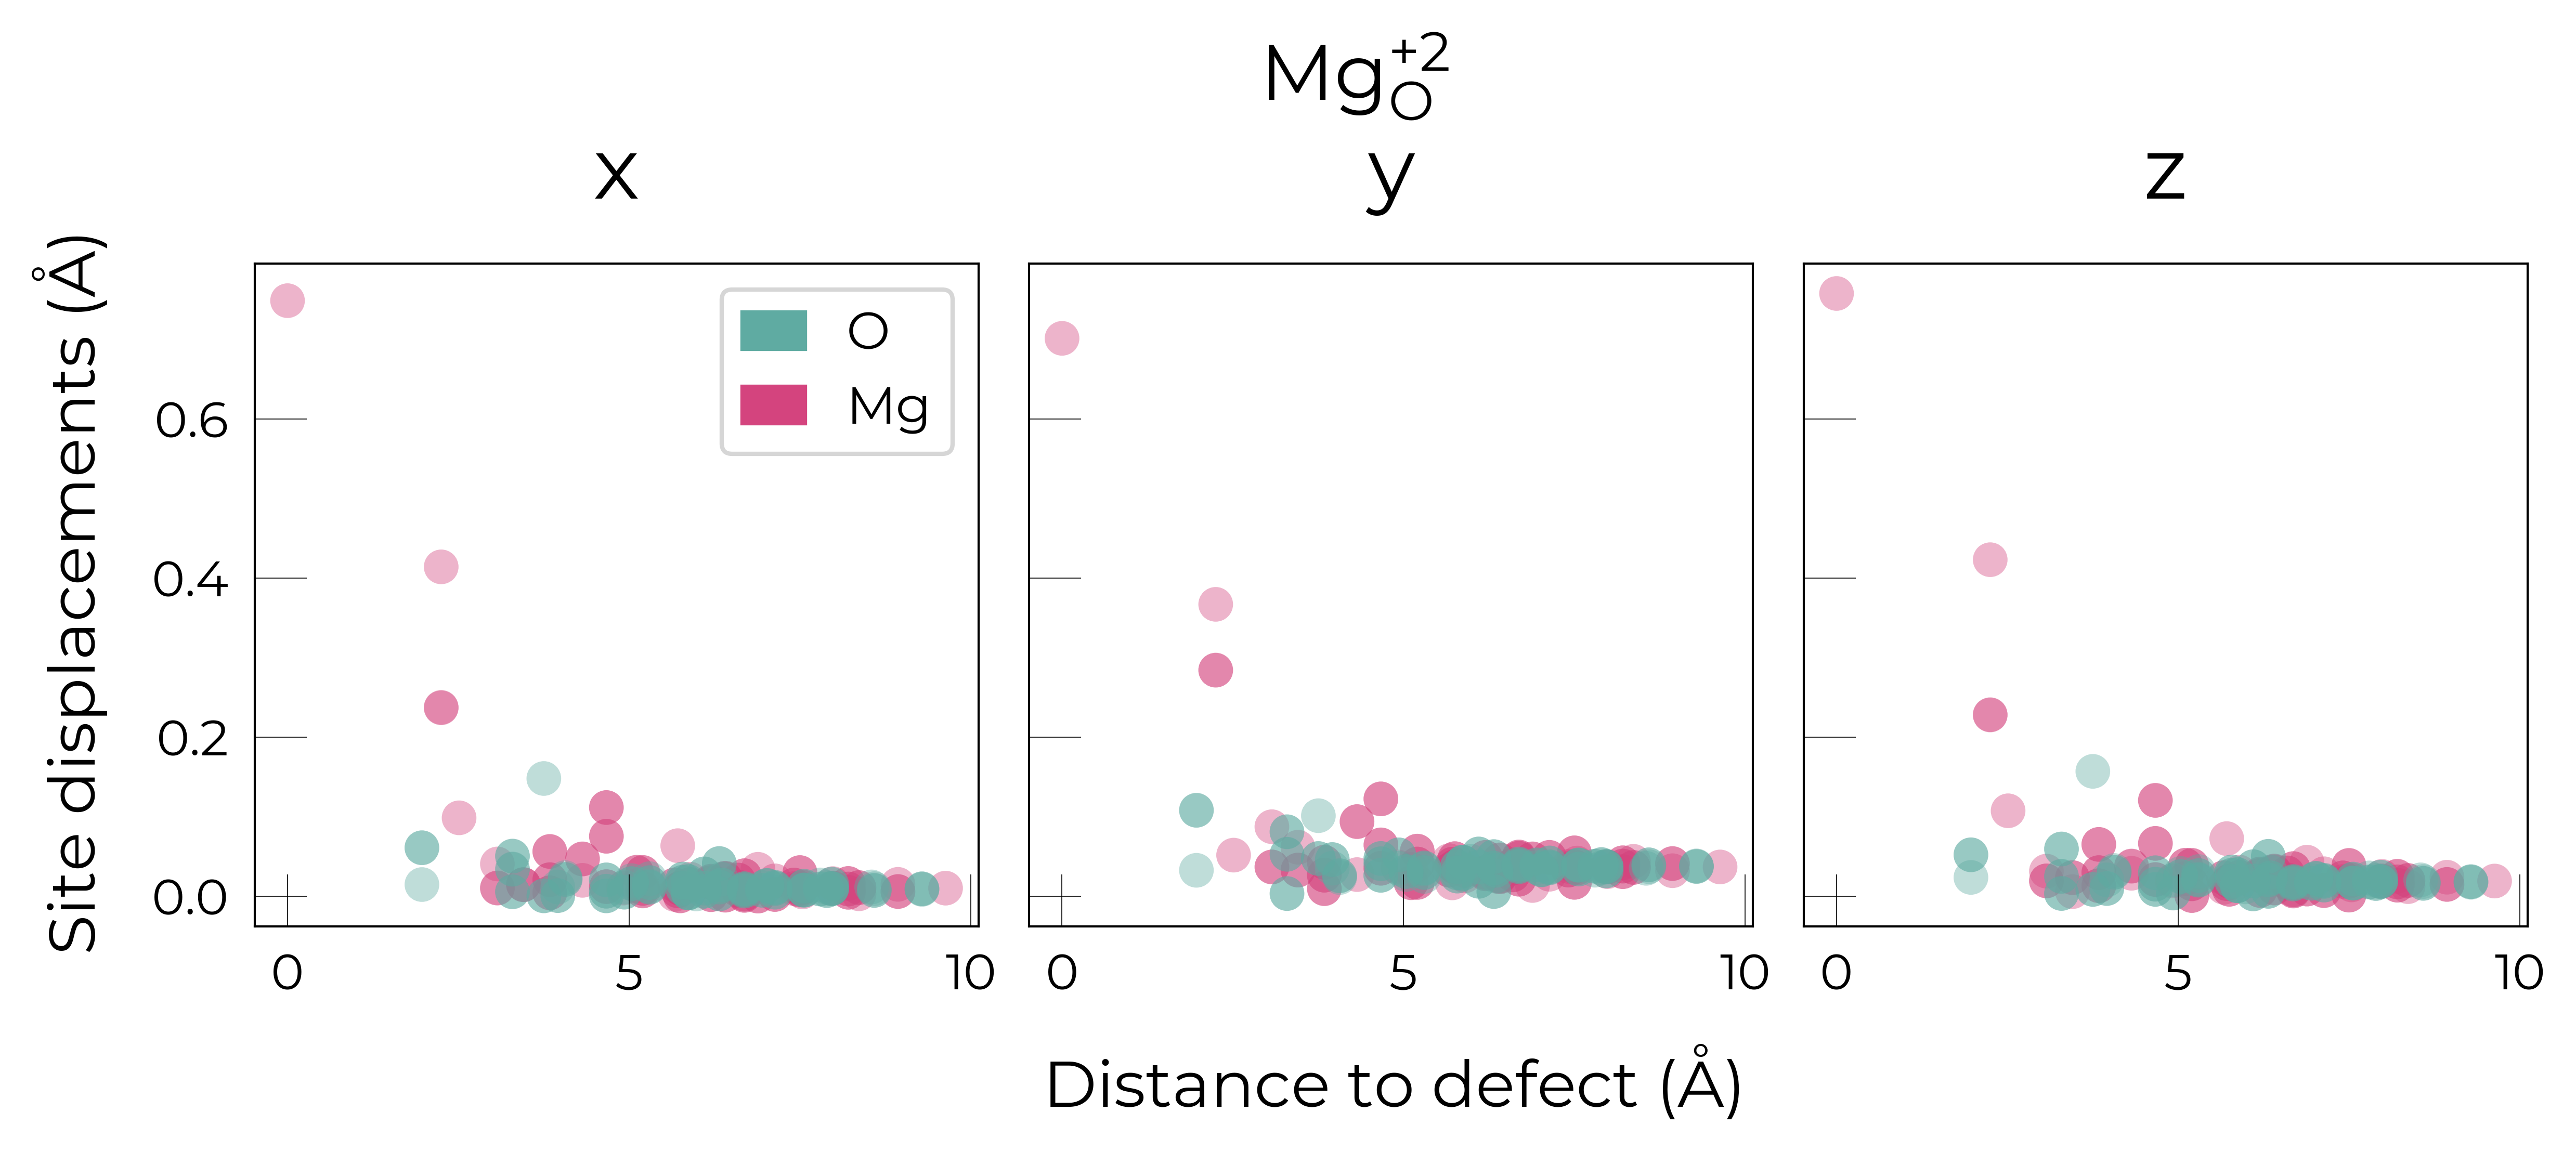

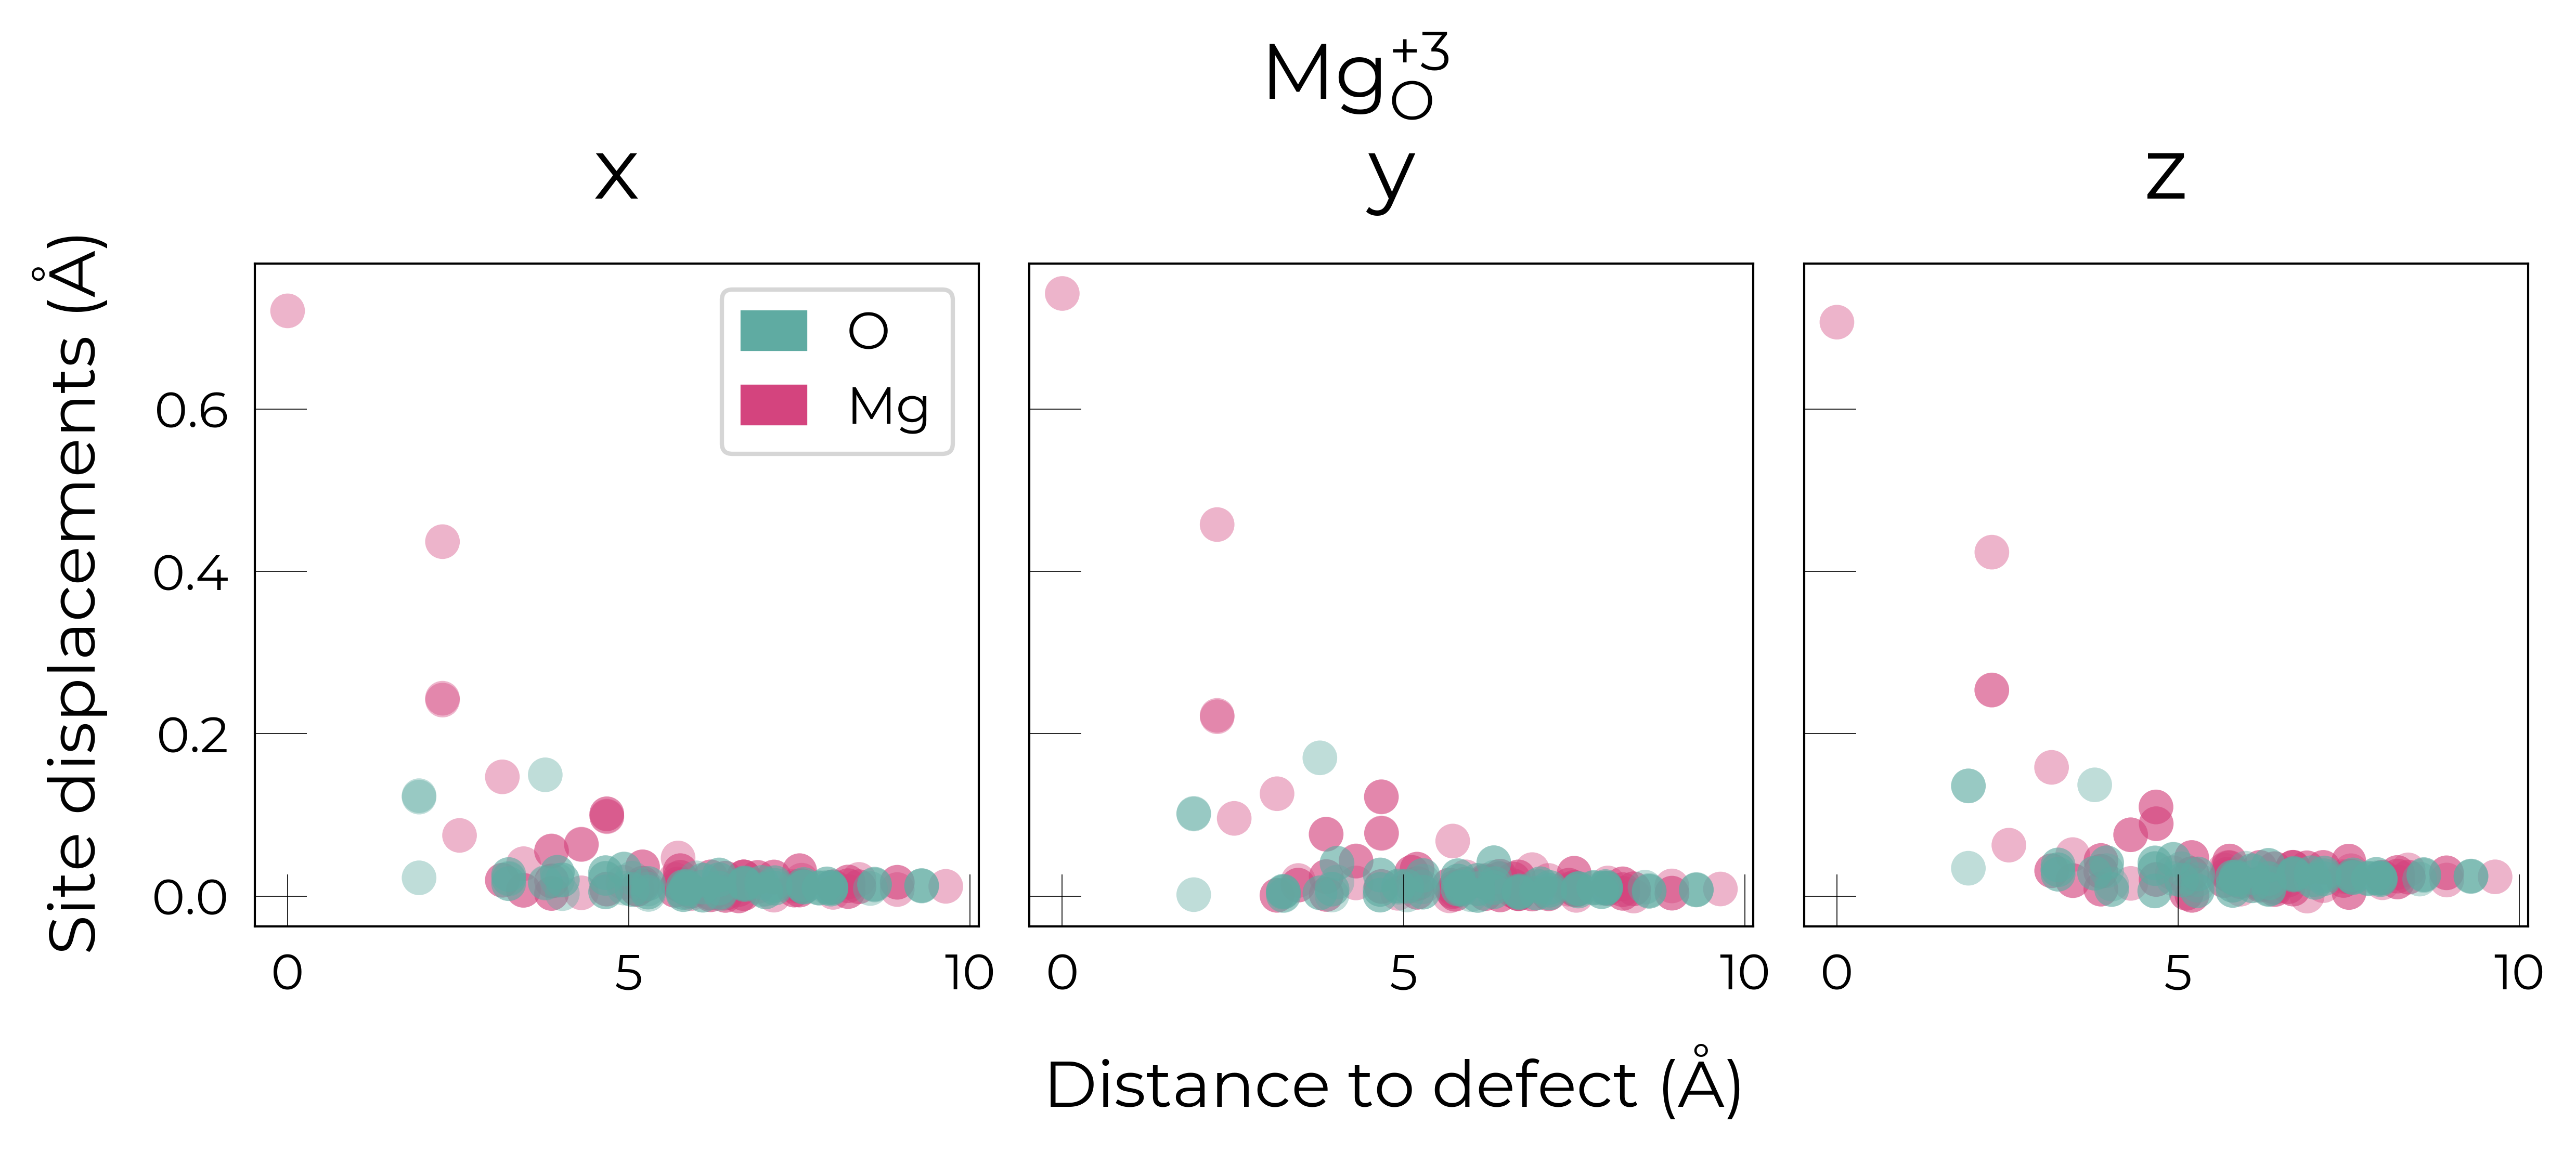

In [39]:
from doped.utils.plotting import format_defect_name

for defect_name, defect_entry in dp.defect_dict.items():
    formatted_defect_name = format_defect_name(defect_name, include_site_info_in_name=False)  # format name for plot title
    fig = defect_entry.plot_site_displacements()
    # Add title to figure with defect name, avoid overlap with subfigure titles
    fig.suptitle(formatted_defect_name, y=1.15)


These displacement plots clearly show how the defect perturbation of the host structure tails off as we move away from the defect site. This is important for ensuring that the defect supercell is large enough.  

In addition, we can also plot the site displacements relative to the defect. This can be useful to visualise which atoms move closer / further away from the defect (e.g. cases the 1st NN shell of the defect compresses (negative displacement) but 2nd NN expands (positve displacement)):

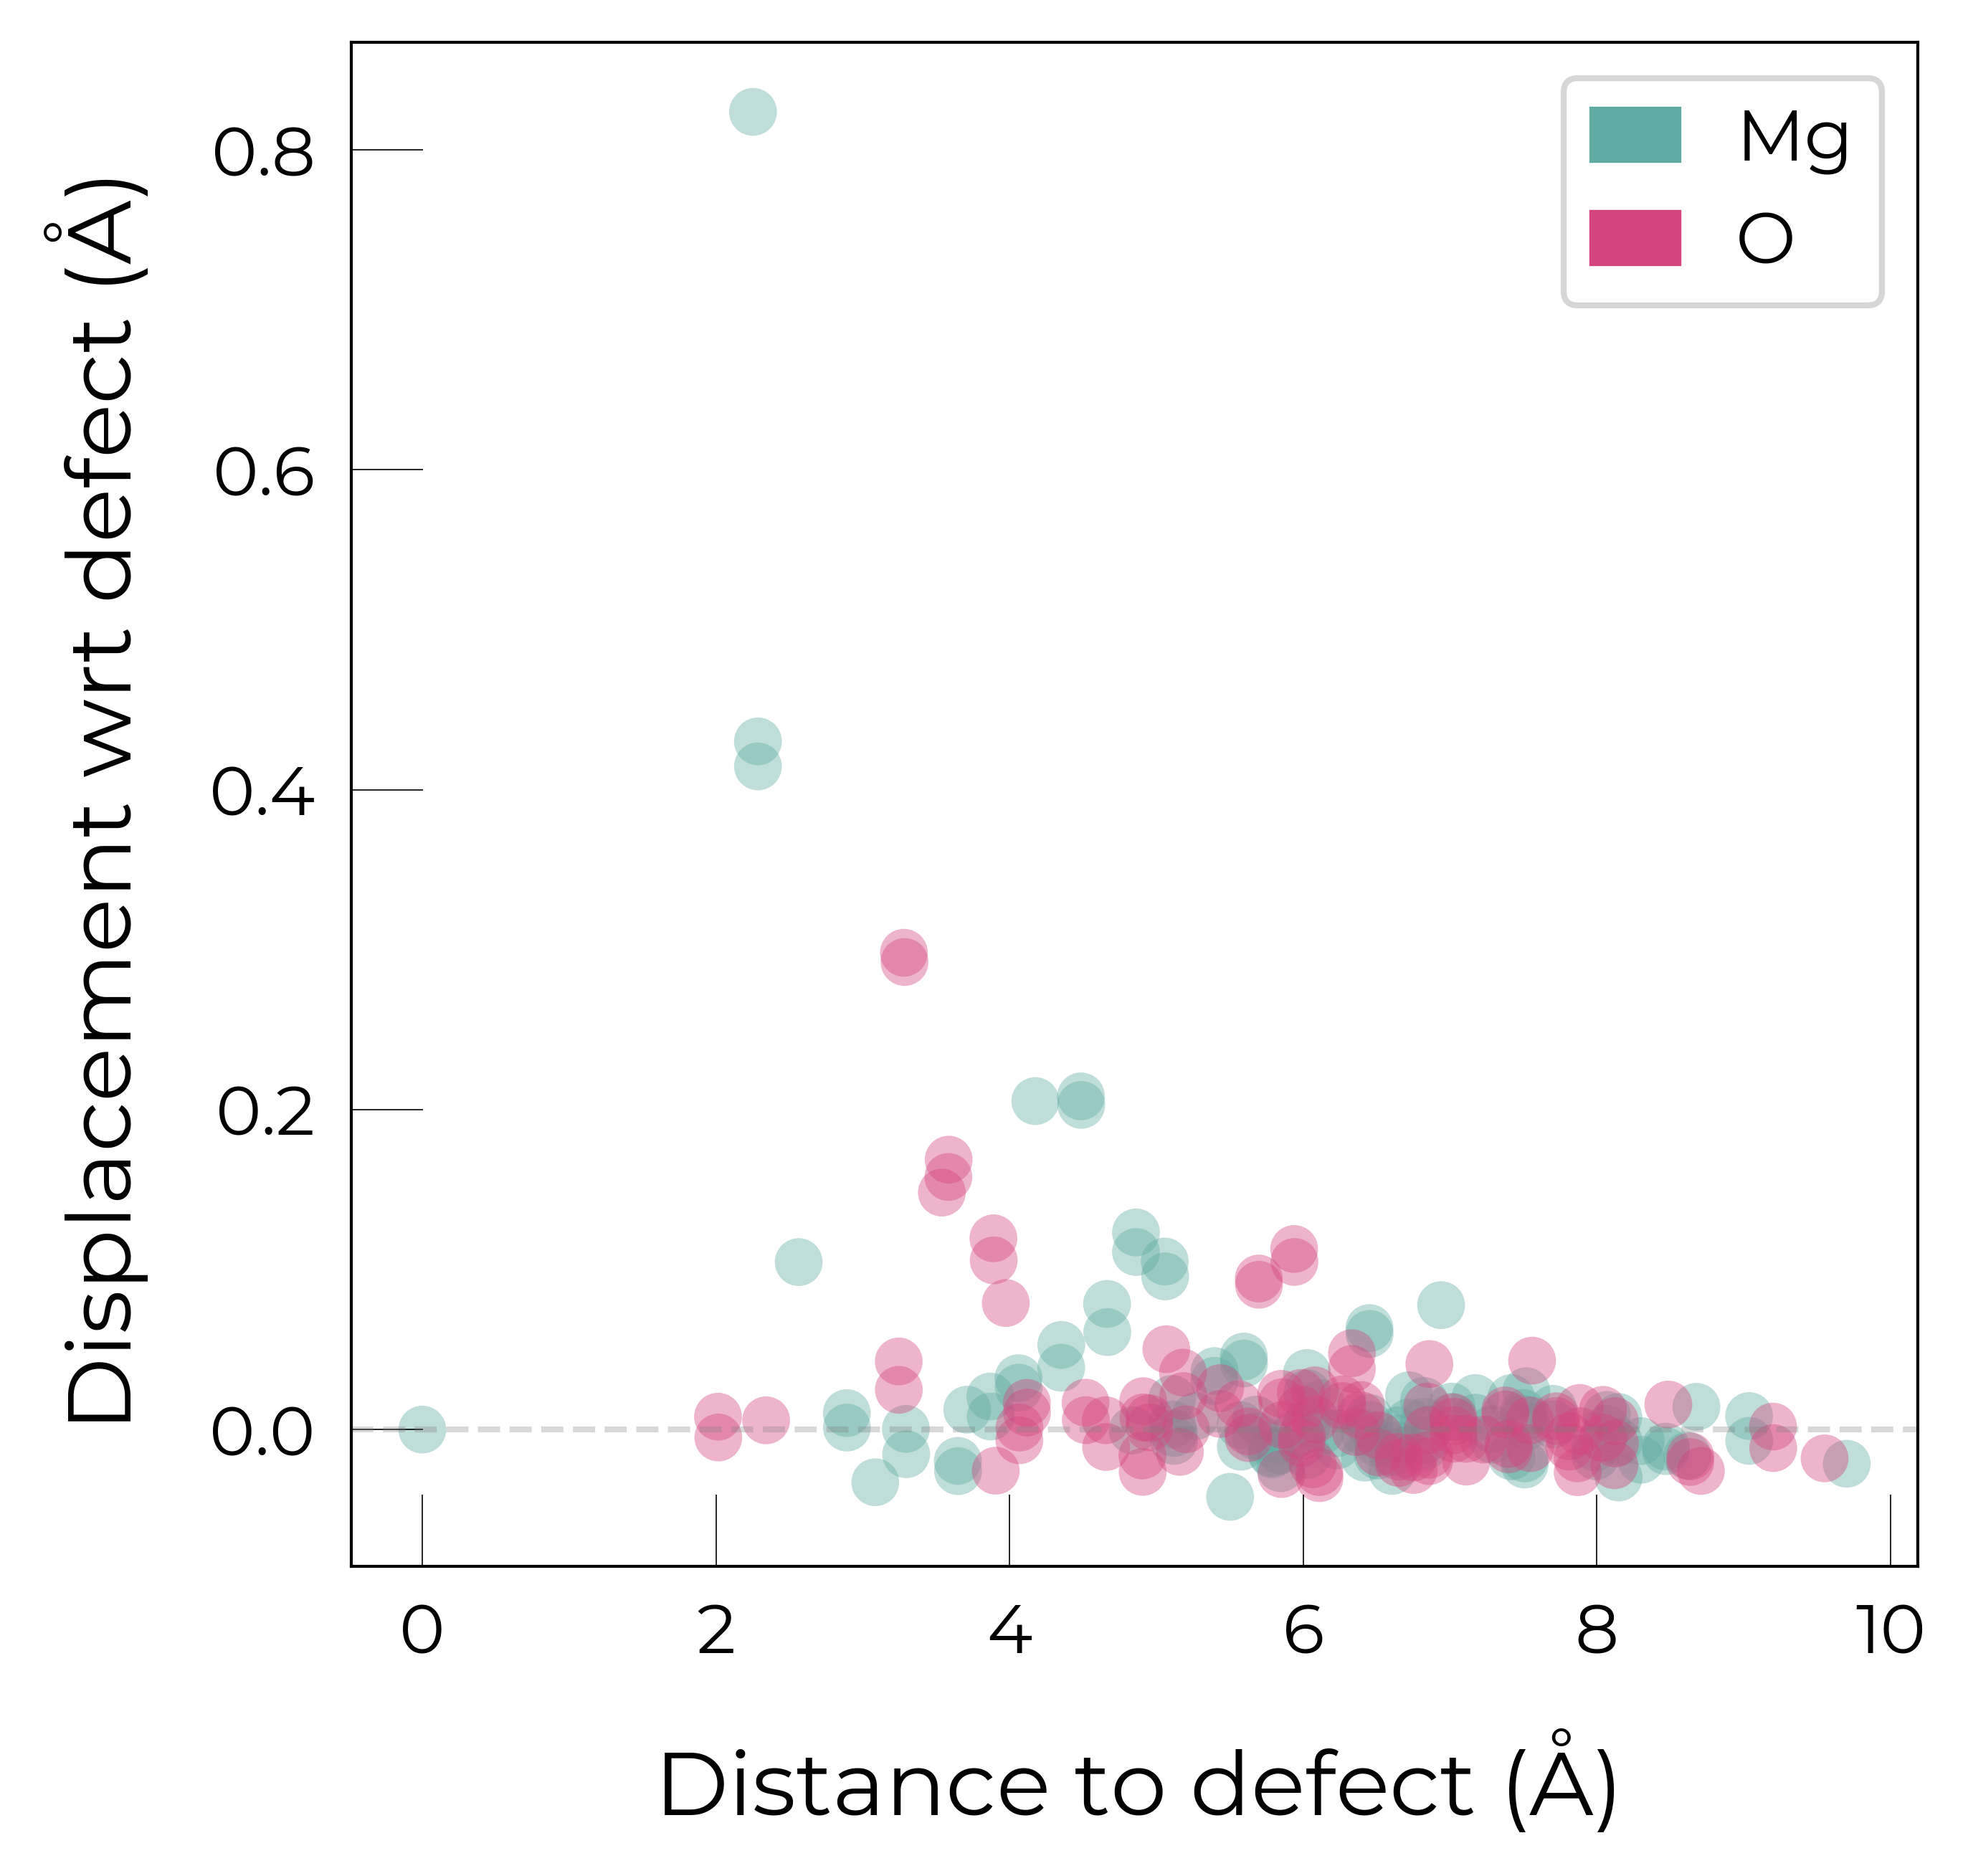

In [1]:
from monty.serialization import loadfn

# Loading defect dictionary from json
MgO_defect_dict = loadfn("MgO/MgO_defect_dict.json")
defect_entry = MgO_defect_dict['Mg_O_0']  # Neutral defect
fig = defect_entry.plot_site_displacements(
    relative_to_defect=True,
)

Which shows that the 3 Mg atoms in the 1st NN shell of the Mg antisite defect are displaced away the defect. 
You can also project the displacements along a specified vector using the option `vector_to_project_on`:

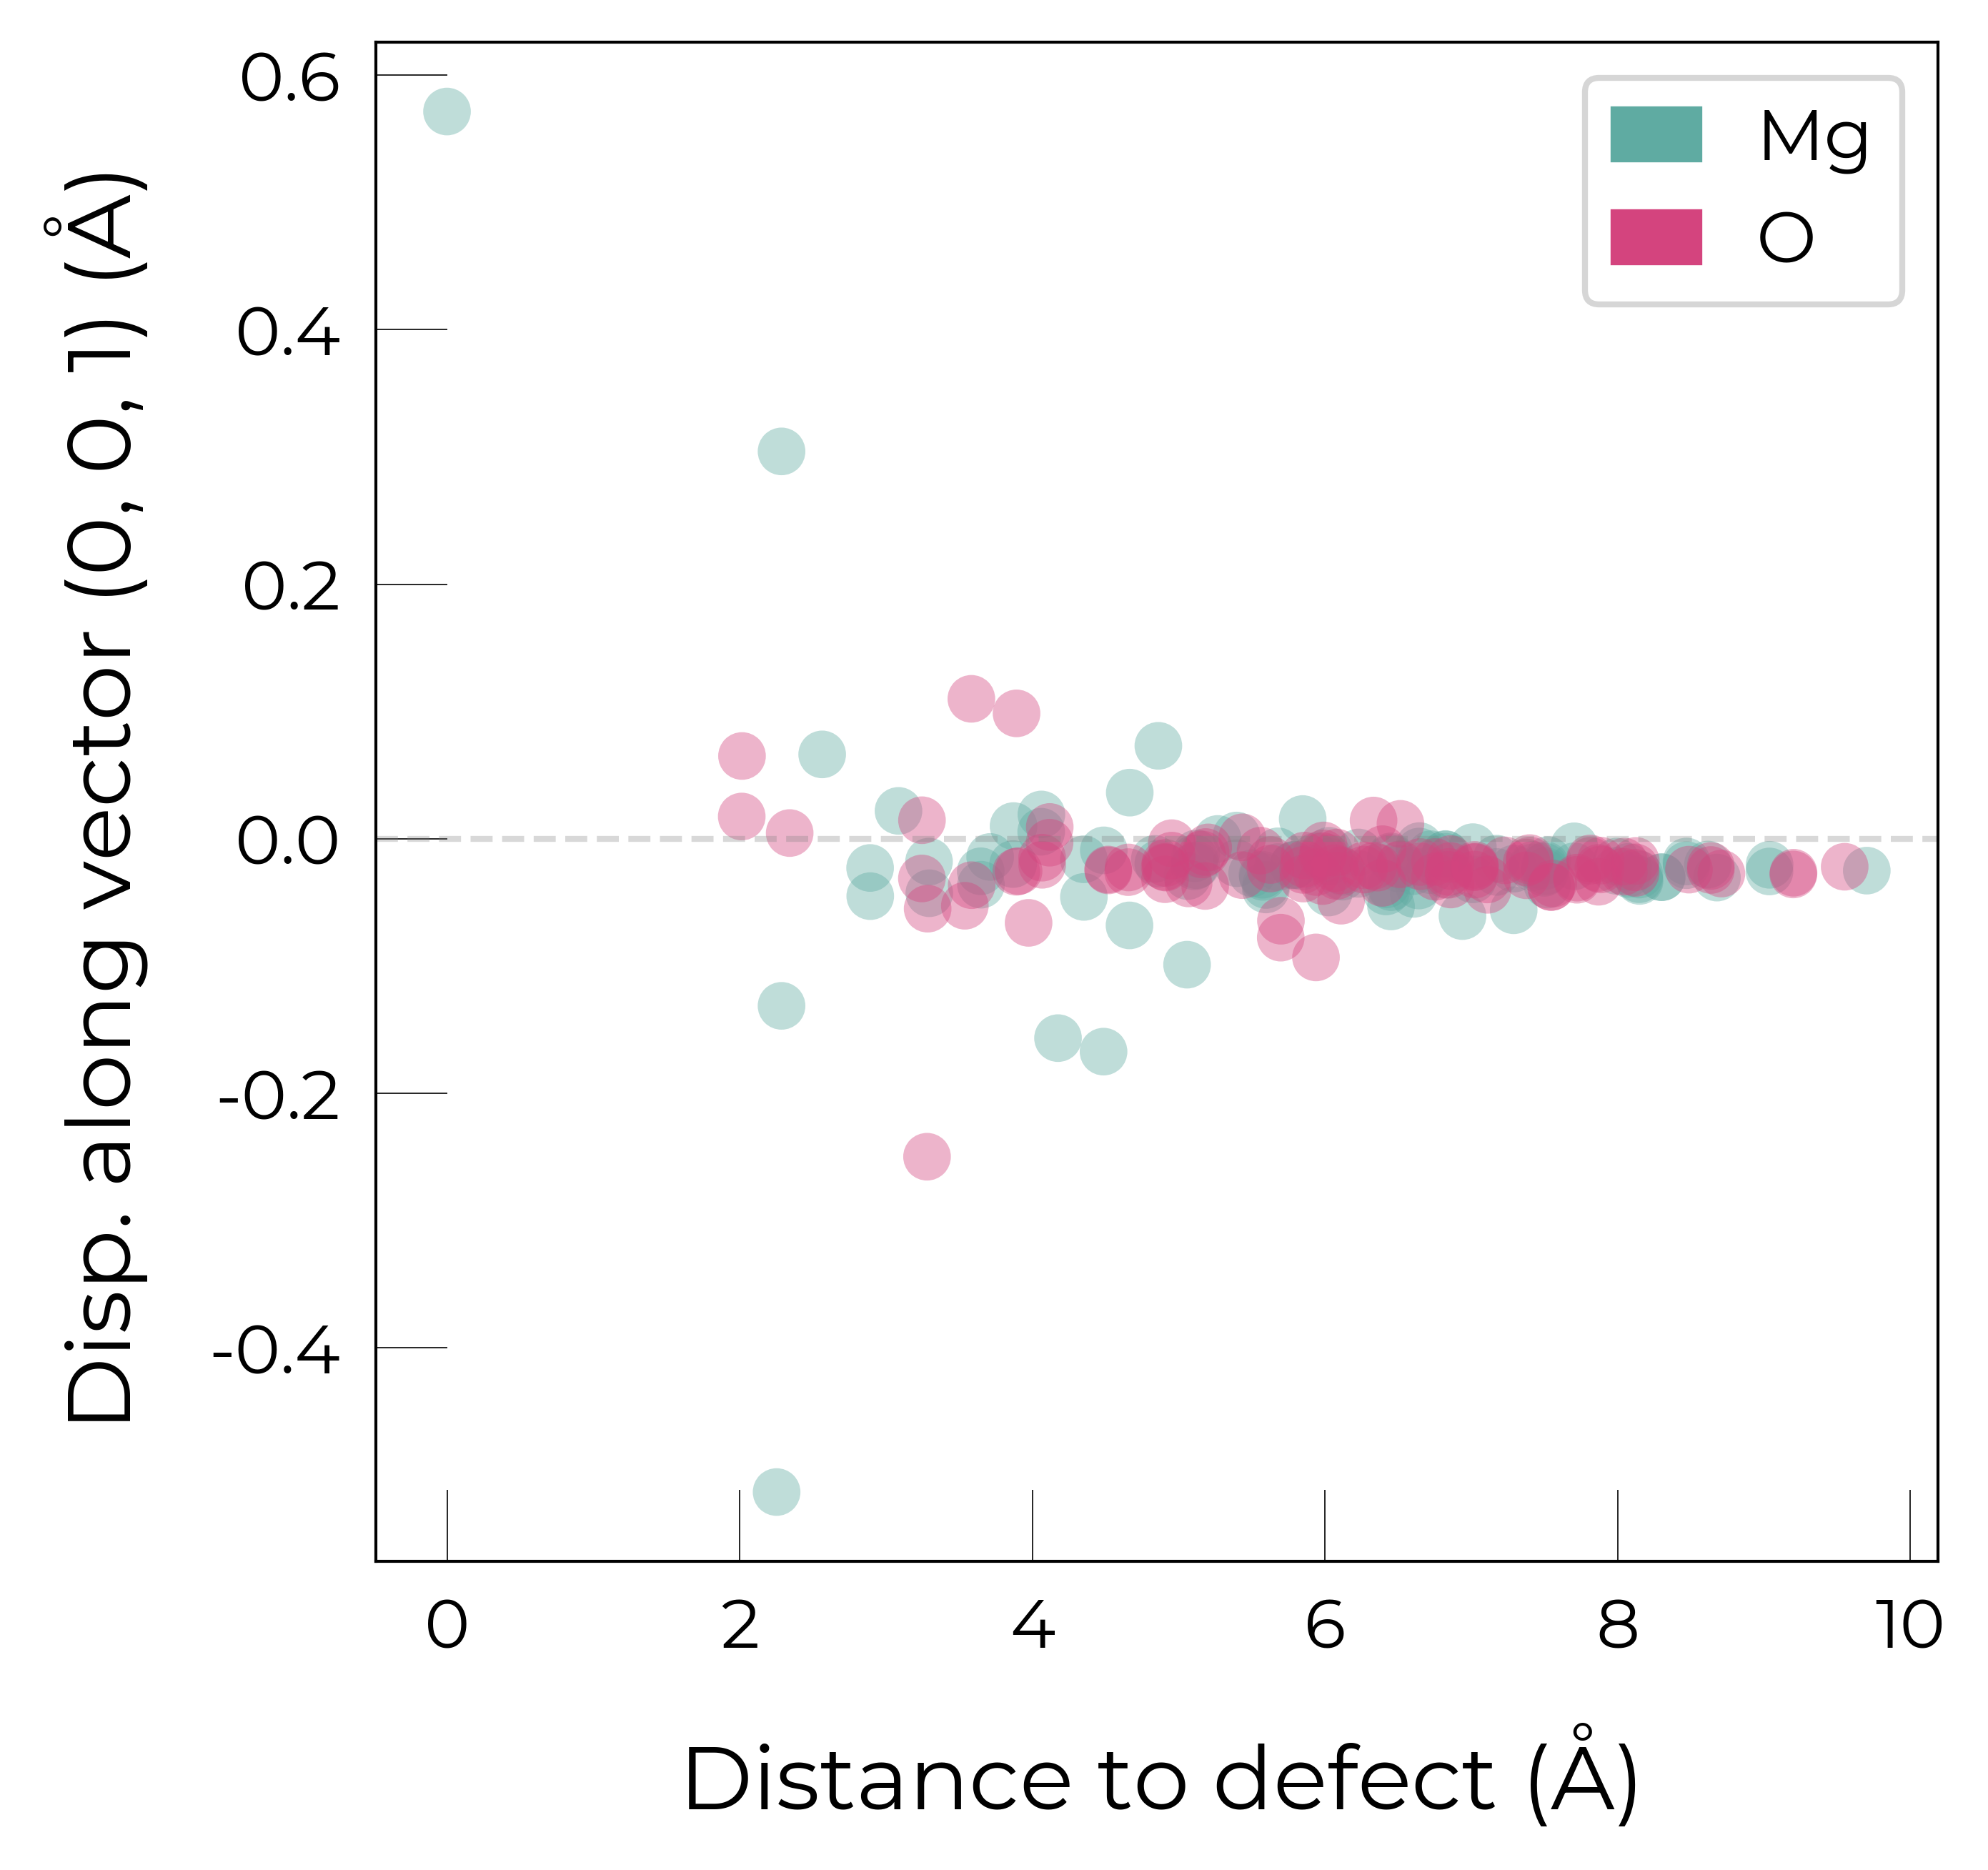

In [2]:
fig = defect_entry.plot_site_displacements(
    vector_to_project_on=(0, 0, 1),  # Project on z-axis
)
fig

<a id='charge_corrections'></a>
### 8.5 Analysing Finite-Size Charge Corrections
#### Kumagai-Oba (eFNV) Charge Correction Example:

As mentioned above, `doped` can automatically compute either the Kumagai-Oba (eFNV) or Freysoldt (FNV) 
finite-size charge corrections, to account for the spurious image charge interactions in the defect 
supercell approach (see the [YouTube tutorial](https://youtu.be/FWz7nm9qoNg) for more details).
The eFNV correction is used by default if possible (if the required `OUTCAR(.gz)` files are available), 
as it is more general – can be used for both isotropic and
 anisotropic systems – and the numerical implementation is more efficient, requiring smaller file sizes 
 and running quicker.

Below, we show how to directly visualising the charge correction plots (showing how they are 
computed), which is recommended if any warnings about the charge correction accuracy are printed when 
parsing our defects (also useful for understanding how the corrections are performed!).

In [40]:
dp.defect_dict.keys()

dict_keys(['Mg_O_+4', 'Mg_O_0', 'Mg_O_+1', 'Mg_O_+2', 'Mg_O_+3'])

In [42]:
from doped.analysis import DefectParser  # can use DefectParser to parse individual defects if desired

defect_entry = dp.defect_dict["Mg_O_+4"]
print(f"Charge: {defect_entry.charge_state:+} at site: {defect_entry.defect_supercell_site.frac_coords}")
print(f"Finite-size charge corrections: {defect_entry.corrections}")

Charge: +4 at site: [0.50148977 0.57845999 0.57665118]
Finite-size charge corrections: {'kumagai_charge_correction': 2.585978512957518}


Above, the defect has been parsed and the anisotropic (eFNV) charge correction correctly applied, with no warnings thrown. We can directly plot the atomic site potentials which are used to compute this charge correction if we want:
(Though typically we only do this if there has been some warning or error related to the application of the defect charge correction – here we're just showing as a demonstration)

```{note}
Typically we only analyze the charge correction plots like this if there has been some warning
 or error related to the defect charge correction (or to aid our understanding of the underlying 
formation energy calculations). Here we're just showing as a demonstration.
```

Calculated Kumagai (eFNV) correction is 2.586 eV


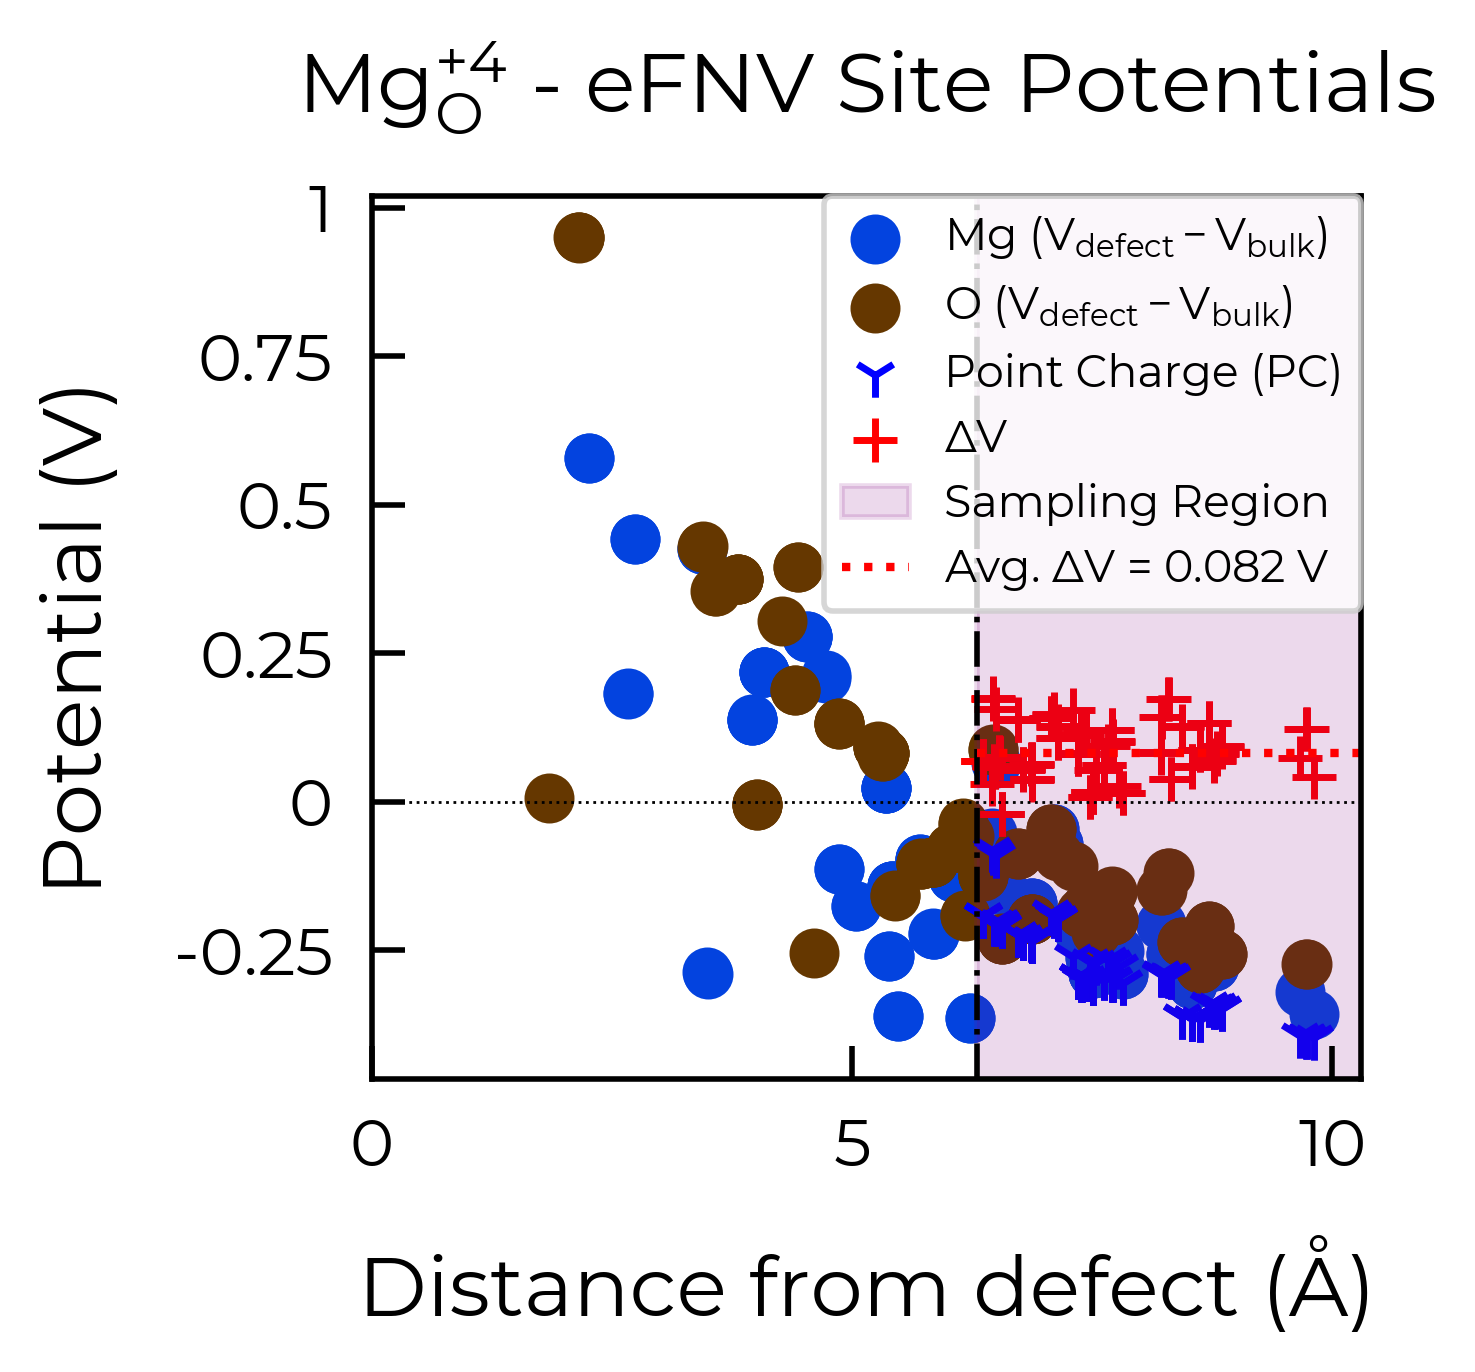

In [43]:
correction, plot = defect_entry.get_kumagai_correction(plot=True)

Here we can see we obtain a good plateau in the atomic potential differences (ΔV) between the 
defect and bulk supercells in the 'sampling region' (i.e. region of defect supercell furthest from the 
defect site), the average of which is used to obtain our potential alignment ('Avg. ΔV') and 
thus our final charge correction term.

If there is still significant variance in the site potential differences in the sampling region (i.e. a 
converged plateau is not obtained), then this suggests that the charge correction may not be as accurate
 for that particular defect or supercell. This error range of the charge correction is automatically 
 computed by `doped`, and can be returned using the `return_correction_error` argument in 
 `get_kumagai_correction`/`get_freysoldt_correction`, or also by adjusting the `error_tolerance` argument: 

In [44]:
correction, error = defect_entry.get_kumagai_correction(return_correction_error=True)
error  # calculated error range of 18.2 meV in our charge correction here

Calculated Kumagai (eFNV) correction is 2.586 eV


0.018215609608678178

In [45]:
print(f"Relative error: {100*0.018215 / 2.586:.3f}%")

Relative error: 0.704%


which is a small error! ✅

### 8.6 Further Defect Analysis

As briefly discussed in the [YouTube defects tutorial](https://youtu.be/FWz7nm9qoNg), you will likely
want to further analyse the key defect species in your material, by e.g. visualising the relaxed
structures with `VESTA`/`CrystalMaker`, looking at the defect single-particle energy levels using the
[sumo](https://smtg-ucl.github.io/sumo/) DOS plotting functions (`sumo-dosplot`), charge density
distributions (e.g. this [Figure](https://doi.org/10.1021/acsenergylett.1c00380#fig2)).

In particular, you may want to further analyse the behaviour and impact on material properties of your
defects using advanced defect analysis codes such as [py-sc-fermi](https://py-sc-fermi.readthedocs.io/en/latest/) (to analyse defect concentrations, doping and Fermi level tuning), [easyunfold](https://smtg-ucl.github.io/easyunfold/) (to analyse the electronic structure of defects in your
material), or [nonrad](https://nonrad.readthedocs.io/en/latest/) / [CarrierCapture.jl](https://wmd-group.github.io/CarrierCapture.jl/dev/) (to analyse non-radiative electron-hole recombination at defects).
The outputs from `doped` are readily ported as inputs to these codes.